# Alan Saul Bonilla Vizcarra
UNIVERSIDAD AUTÓNOMA DE NAYARIT

UNIDAD ACADÉMICA DE CIENCIAS BÁSICAS E INGENIERÍAS

PROGRAMA DE MAESTRÍA EN CIENCIAS E INGENIERÍA


Aplicación de técnicas de Machine Learning para la detección de ataques en comunicaciones de VoIP  

# Importar librerias

In [ ]:
# pip install --upgrade pip pandas matplotlib seaborn scikit-learn statsmodels xgboost tensorflow optuna IPython pydotplus graphviz keras shap

In [2]:
#Librerias basicas
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import perf_counter
import os
import math

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE #Para Regresion Logistica
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFECV


#Metricas de desempeño
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, average_precision_score, log_loss, matthews_corrcoef 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

#Dividir conjutno
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#Estandarizacion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Modelos ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import GaussianNB

#Optimizacion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
from optuna.samplers import TPESampler

#Visualizacion de desempeño
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from xgboost import plot_importance
import shap




# Importar Dataset

Comenzamos leyendo el dataset con el metodo `pd.read_csv()`

In [ ]:
dfataque=pd.read_csv('AtaquesRIT.csv')
dfvalidacion=pd.read_csv('prueba-10-0905-2.csv')
dfsaneado=pd.read_csv('Saneado.csv')

print('dfataque',dfataque.shape,'dfvalidacion',dfvalidacion.shape,'dfsaneado',dfsaneado.shape)

df = pd.concat([dfataque, dfvalidacion, dfsaneado], ignore_index=True)
df.shape

dfataque (52866, 52) dfvalidacion (1887, 52) dfsaneado (735, 52)


(55488, 52)

## Acerca del dataset

Para el presente trabajo, se utliza el dataset proveido del paper *"Dataset of attacks on a live enterprise VoIP network for machine learning based intrusion detection and prevention systems"* del Rochester Institute of Technology, Dubai, United Arab Emirates.
Este dataset proporciona acceso a datos en bruto de una red VoIP empresarial gestionada por medio de Asterisk 17.0, programa de software libre que proporciona funcionalidades de una central telefónica.
Contiene registros de varios tipos de ataques que proporcionan a los investigadores una variedad de escenarios de ataque para investigar y/o entrenar modelos.


Para trabajar el dataset, es necesario utilizar una herramienta de conversion dado que los archivos vienen en formato PCAP el cual es un método para la captura, almacenamiento y análisis del tráfico de red.
Se utilizo la herramienta **3FEx: Fast Flow Feature Extractor** la cual agrupa los paquetes en flujos y los almacena en un archivo csv, extrayendo las siguientes caracteristicas

## Descripcion de las features
En la literatura de la herramienta utilizada para obtener los datos tenemos una descripcion detallada de lo que significa cada feature
| No. | Feature Name | Description |
| --- | --- | --- |
|0|proto| Protocol type|
|1|ts|Session time stamp|
|2|srcIP|IPv4 source address|
|3|srcPort| Source port|
|4|dstIP|IPv4 destination address|
|5|dstPort|Destination port|
|6|flowduration|Session duration|
|7|total_fpackets|Number of packets in the forward direction|
|8|total_bpackets|Number of packets in the backward direction|
|9|total_fpktl|Transmited bytes in forward direction|
|10|total_bpktl|Transmited bytes in backward direction|
|11|min_fpktl|Minimum packet size in forward direction|
|12|min_bpktl|Minimum packet size in backward direction|
|13|max_fpktl|Maximum packet size in forward direction|
|14| max_bpktl|Maximum packet size in backward direction|
|15|mean_fpktl|Mean packet size in forward direction|
|16| mean_bpktl|Mean packet size in backward direction|
|17|std_fpktl|Standard deviation packet size in forward direction|
|18|std_bpktl|Standard deviation packet size in backward direction|
|19|total_ﬁpt|Sum of interarrival times in forward direction|
|20|total_bipt|Sum of interarrival times in backward direction|
|21| min_ﬁpt|Minimum interarrival time in forward direction|
|22|min_bipt|Minimum interarrival time in backward direction|
|23| max_ﬁpt|Maximum interarrival time in forward direction|
|24| max_bipt|Maximum interarrival time in backward direction|
|25| mean_ﬁpt|Mean interarrival time in forward direction|
|26| mean_bipt|Mean interarrival time in backward direction|
|27|std_ﬁpt|Standard deviation packet size in forward direction|
|28|std_bipt|Standard deviation packet size in backward direction|
|29|fpsh_cnt|Number PSH ﬂags in forward direction|
|30|bpsh_cnt|Number PSH ﬂags in backward direction|
|31|furg_cnt|Number URG ﬂags in forward direction|
|32| burg_cnt|Number URG ﬂags in backward direction|
|33|total_fhlen|Sum of headers length in forward direction|
|34|total_bhlen|Sum of headers length in backward direction|
|35|fPktsPerSecond|Packets per second in forward direction|
|36|bPktsPerSecond|Packets per second in backward direction|
|37| ﬂowBytesPerSecond|Total Bytes per second in session|
|38| mean_ﬂowpktl|Average package length|
|39|std_ﬂowpktl|Standard deviation of package length|
|40| mean_ﬂowipt|Average of interarrival times|
|41|std_ﬂowipt|Standard deviation of interarrival times|
|42| ﬂow_ﬁn|Number of packets with FIN ﬂag set. Is set to signal the graceful termination of a connection.|
|43| ﬂow_syn|Number of packets with SYN ﬂag set. It is used to request the establishment of a connection|
|44| ﬂow_rst|Number of packets with RST ﬂag set. The reset flag is used to terminate a connection abruptly.|
|45| ﬂow_ack|Number of packets with ACK ﬂag set. It is set in response to a received packet with the SYN flag.|
|46| ﬂow_urg|Number of packets with URG ﬂag set. Is used to indicate that the data in the packet is urgent and should be processed immediately.|
|47| ﬂow_cwr|Number of packets with CWR ﬂag set. This flag is used to indicate that the TCP sender is reducing its congestion window.|
|48| ﬂow_ece|Number of packets with ECE ﬂag set. Is used in conjunction with the CWR flag to indicate that congestion has been encountered in the network|
|49| downUpRatio|Download and upload ratio|

## Tipos de ataques
Los ataques que el dataset recolecto y se utlizaron para el presente trabajo son los siguientes:
- **BYE attack:** "El BYE es un ataque de suplantación que envía mensajes BYE (indicando la finalización de una sesión) a un servidor SIP para terminar llamadas activas legítimas en la red VoIP.
- **INVITE flood attack:** En este tipo de ataque, se envían una gran cantidad de mensajes INVITE a un servidor con el objetivo de agotar los recursos del servidor, como la CPU y la memoria
- **REGISTER hijacking attack:** implica que un atacante se haga pasar por un usuario legítimo al reemplazar la dirección de registro de un agente de usuario (UA) con su propia dirección.
- **RTP flood attack:** En un ataque de inundación RTP, los atacantes generan y envían una gran cantidad de paquetes RTP falsificados o innecesarios a un dispositivo o servidor VoIP con el objetivo de abrumar el sistema y agotar sus recursos. Este tipo de ataque puede causar **interrupciones en la calidad del servicio, retrasos en la comunicación y**, en casos extremos, la **interrupción total del servicio de VoIP**.  
- **REGISTER flood (SIPsak):** En este tipo de ataque, los atacantes envían una gran cantidad de paquetes de registro SIP (REGISTER) al servidor SIP con el objetivo de agotar sus recursos y provocar una denegación de servicio. Esto puede causar puede causar retrasos en la entrega de paquetes, pérdida de llamadas y una degradación general en la calidad del servicio.


# EDA: Analisis Exploratorio de Datos

Con el metodo `head()` hacemos que nos muestre los 5 primeros rasgos del Dataset

In [6]:
##Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

In [7]:
df.head(50)

proto          ts           srcIP srcPrt          dstIP  dstPrt  \
0    UDP  1597740714    172.168.1.44   4000  192.168.1.127    5060   
1    UDP  1597738733    172.168.1.44   4000  192.168.1.127    5060   
2    UDP  1597738932    172.168.1.44   4000  192.168.1.127    5060   
3    UDP  1597739056    172.168.1.44   4000  192.168.1.127    5060   
4    UDP  1597743924    172.168.1.44   4000  192.168.1.127    5060   
5    UDP  1597744208    172.168.1.44   4000  192.168.1.127    5060   
6    UDP  1597743924    172.168.1.44   4000  192.168.1.127    5060   
7    UDP  1597743983   45.143.220.59   5093   172.168.1.44    5060   
8    UDP  1597744208    172.168.1.44   4000  192.168.1.127    5060   
9    UDP  1596877651    172.168.1.44      9  192.168.1.127    5060   
10   UDP  1596877651    172.168.1.44      9  192.168.1.127    5060   
11   UDP  1596878277  50.234.173.102   5205   172.168.1.44    5060   
12   UDP  1597136649    172.168.1.33   5060  192.168.1.127    5060   
13   UDP  1597136851    172.168.1.44      9  192.168.1.127    5060   
14   UDP  1597136851    172.168.1.44      9  192.168.1.127    5060   
15   UDP  1597145172    172.168.1.44   5060  192.168.1.127    5060   
16   UDP  1597145274    172.168.1.44   5060  192.168.1.127    5060   
17   UDP  1597145171    172.168.1.44   5060    192.168.1.0    5060   
18   UDP  1597145171    172.168.1.44   5060    192.168.1.1    5060   
19   UDP  1597145171    172.168.1.44   5060    192.168.1.2    5060   
20   UDP  1597145171    172.168.1.44   5060    192.168.1.3    5060   
21   UDP  1597145171    172.168.1.44   5060    192.168.1.4    5060   
22   UDP  1597145172    172.168.1.44   5060    192.168.1.5    5060   
23   UDP  1597145172    172.168.1.44   5060    192.168.1.6    5060   
24   UDP  1597145172    172.168.1.44   5060    192.168.1.7    5060   
25   UDP  1597145172    172.168.1.44   5060    192.168.1.8    5060   
26   UDP  1597145172    172.168.1.44   5060    192.168.1.9    5060   
27   UDP  1597145172    172.168.1.44   5060   192.168.1.10    5060   
28   UDP  1597145172    172.168.1.44   5060   192.168.1.11    5060   
29   UDP  1597145172    172.168.1.44   5060   192.168.1.12    5060   
30   UDP  1597145172    172.168.1.44   5060   192.168.1.13    5060   
31   UDP  1597145172    172.168.1.44   5060   192.168.1.14    5060   
32   UDP  1597145172    172.168.1.44   5060   192.168.1.15    5060   
33   UDP  1597145172    172.168.1.44   5060   192.168.1.16    5060   
34   UDP  1597145172    172.168.1.44   5060   192.168.1.17    5060   
35   UDP  1597145172    172.168.1.44   5060   192.168.1.18    5060   
36   UDP  1597145172    172.168.1.44   5060   192.168.1.19    5060   
37   UDP  1597145172    172.168.1.44   5060   192.168.1.20    5060   
38   UDP  1597145172    172.168.1.44   5060   192.168.1.21    5060   
39   UDP  1597145172    172.168.1.44   5060   192.168.1.22    5060   
40   UDP  1597145172    172.168.1.44   5060   192.168.1.23    5060   
41   UDP  1597145172    172.168.1.44   5060   192.168.1.24    5060   
42   UDP  1597145172    172.168.1.44   5060   192.168.1.25    5060   
43   UDP  1597145172    172.168.1.44   5060   192.168.1.26    5060   
44   UDP  1597145172    172.168.1.44   5060   192.168.1.27    5060   
45   UDP  1597145172    172.168.1.44   5060   192.168.1.28    5060   
46   UDP  1597145172    172.168.1.44   5060   192.168.1.29    5060   
47   UDP  1597145172    172.168.1.44   5060   192.168.1.30    5060   
48   UDP  1597145172    172.168.1.44   5060   192.168.1.31    5060   
49   UDP  1597145172    172.168.1.44   5060   192.168.1.32    5060   

    flowduration  total_fpackets  total_bpackets  total_fpktl  total_bpktl  \
0     522.293150               9               9         3960         4431   
1       0.001746               1               1          440          485   
2       0.001163               1               1          440          507   
3       0.001155               1               1          440          507   
4      54.349883               2          

Con la variable `target_names` definimos los nombres de las clases

In [8]:
target_names = ['class 0', 'class 1']

Aplicamos el metodo `describe()` para conocer las estadisiticas del Dataset

In [9]:
df.describe().T

count          mean           std  min     25%     50%  \
dstPrt              55488.0   9833.924146  1.475950e+04  0.0  1169.0  5001.0   
flowduration        55488.0      4.333621  1.504070e+02  0.0     0.0     0.0   
total_fpackets      55488.0     40.142499  1.355496e+03  0.0     1.0     1.0   
total_bpackets      55488.0     45.267932  2.508051e+03  0.0     0.0     0.0   
total_fpktl         55488.0  14419.792171  6.731386e+05  0.0    58.0    58.0   
total_bpktl         55488.0  18669.295289  1.482617e+06  0.0     0.0     0.0   
min_fpktl           55488.0     74.699971  8.017977e+01  0.0    58.0    58.0   
min_bpktl           55488.0     18.323565  8.487522e+01  0.0     0.0     0.0   
max_fpktl           55488.0     95.113790  1.694860e+02  0.0    58.0    58.0   
max_bpktl           55488.0     29.737277  1.397462e+02  0.0     0.0     0.0   
mean_fpktl          55488.0     85.509439  1.225469e+02  0.0    58.0    58.0   
mean_bpktl          55488.0     22.921483  1.035926e+02  0.0     0.0     0.0   
std_fpktl           55488.0      8.728229  4.832619e+01  0.0     0.0     0.0   
std_bpktl           55488.0      2.758787  1.941751e+01  0.0     0.0     0.0   
total_fipt          55488.0      3.597698  1.501850e+02  0.0     0.0     0.0   
total_bipt          55488.0      4.095042  1.494612e+02  0.0     0.0     0.0   
min_fipt            55488.0      0.010920  5.533418e-01  0.0     0.0     0.0   
min_bipt            55488.0      0.010418  5.953923e-01  0.0     0.0     0.0   
max_fipt            55488.0      0.137453  2.291276e+00  0.0     0.0     0.0   
max_bipt            55488.0      0.350750  3.826571e+00  0.0     0.0     0.0   
mean_fipt           55488.0      0.048431  8.179511e-01  0.0     0.0     0.0   
mean_bipt           55488.0      0.114784  1.212393e+00  0.0     0.0     0.0   
std_fipt            55488.0      0.040782  6.700466e-01  0.0     0.0     0.0   
std_bipt            55488.0      0.105368  1.183815e+00  0.0     0.0     0.0   
fpsh_cnt            55488.0      0.557490  1.275659e+02  0.0     0.0     0.0   
bpsh_cnt            55488.0      0.552714  1.276590e+02  0.0     0.0     0.0   
furg_cnt            55488.0      0.000000  0.000000e+00  0.0     0.0     0.0   
burg_cnt            55488.0      0.001910  3.181907e-01  0.0     0.0     0.0   
total_fhlen         55488.0  13020.903799  6.328968e+05  0.0    24.0    24.0   
total_bhlen         55488.0  17095.299038  1.398152e+06  0.0     0.0     0.0   
fPktsPerSecond      55488.0     73.244061  1.934233e+03  0.0     0.0     0.0   
bPktsPerSecond      55488.0     65.627360  1.922620e+03  0.0     0.0     0.0   
flowBytesPerSecond  55488.0  15932.312611  2.698204e+05  0.0     0.0     0.0   
mean_flowpktl       55488.0     82.523610  1.063619e+02  0.0    58.0    58.0   
std_flowpktl        55488.0      6.321160  3.160123e+01  0.0     0.0     0.0   
mean_flowipt        55488.0      0.072025  5.350290e-01  0.0     0.0     0.0   
std_flowipt         55488.0      0.078801  6.631345e-01  0.0     0.0     0.0   
flow_fin            55488.0      0.004902  1.175459e-01  0.0     0.0     0.0   
flow_syn            55488.0      0.887669  3.513795e-01  0.0     1.0     1.0   
flow_rst            55488.0      0.013138  1.324509e-01  0.0     0.0     0.0   
flow_ack            55488.0      2.232104  3.612548e+02  0.0     0.0     0.0   
flow_urg            55488.0      0.000000  0.000000e+00  0.0     0.0     0.0   
flow_cwr            55488.0      0.000288  5.199281e-02  0.0     0.0     0.0   
flow_ece            55488.0      0.000036  6.003597e-03  0.0     0.0     0.0   
downUpRatio         55486.0      0.110320  8.335126e-01  0.0     0.0     0.0   
label               55488.0      0.986682  1.146345e-01  0.0     1.0     1.0   
Ataque              55488.0      4.136588  1.197508e+00  0.0     4.0     4.0   

                       75%           max  
dstPrt              9010.0  6.538900e+04  
flowduration           0.0  2.291956e+04  
total_fpackets         1.0  1.887520e+05  
total_bpa

El método `info()` muestra el resumen del dataframe, incluyendo información sobre el tipo de los índices de filas y columnas, los valores no nulos y la memoria usada

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55488 entries, 0 to 55487
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   proto               55488 non-null  object 
 1   ts                  55488 non-null  object 
 2   srcIP               55488 non-null  object 
 3   srcPrt              55488 non-null  object 
 4   dstIP               55488 non-null  object 
 5   dstPrt              55488 non-null  int64  
 6   flowduration        55488 non-null  float64
 7   total_fpackets      55488 non-null  int64  
 8   total_bpackets      55488 non-null  int64  
 9   total_fpktl         55488 non-null  int64  
 10  total_bpktl         55488 non-null  int64  
 11  min_fpktl           55488 non-null  int64  
 12  min_bpktl           55488 non-null  int64  
 13  max_fpktl           55488 non-null  int64  
 14  max_bpktl           55488 non-null  int64  
 15  mean_fpktl          55488 non-null  float64
 16  mean

Observamos que en el Dataset no existen objetos nulos/NaN, y en su mayoria esta compuesto por variables int y float.
Para este caso, se eliminan las columnas referentes al Protocolo, direcciones IP y numeros de Puerto para que los modelos puedan aprender de la demas informacion.

In [11]:
df.drop(['proto','ts','srcIP','srcPrt','dstIP','dstPrt'],axis=1,inplace=True)

Aplicamos la funcion `shape` para conocer las dimensiones del dataset

In [12]:
df.shape

(55488, 46)

Con `Counter` obtenemos la cantidad de observaciones de clase positiva y clase negativa. Inicialmente, observamos que el dataset esta muy desbalanceado con una proporcion de aprox 72:1

In [13]:
collections.Counter(df.label.values)

Counter({np.int64(1): 54749, np.int64(0): 739})

In [14]:
collections.Counter(df.Ataque.values)

Counter({np.int64(4): 52043,
         np.int64(10): 1887,
         np.int64(3): 786,
         np.int64(0): 735,
         np.int64(5): 22,
         np.int64(1): 9,
         np.int64(2): 6})

Revisamos por medio de `duplicated().sum()` la cantidad de observaciones duplicadas

Eliminamos dichas observaciones duplicadas para no exponernos a **Data Leak**

In [15]:
# Eliminar duplicados
df = df.drop_duplicates()
# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
df_cleaned = df.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
df_cleaned = df[~df_cleaned]
df=df_cleaned.copy()


Validamos por medio de `isnull().values.sum()` que no existan valores nulos y, en caso de existir, eliminamos la observacion con `dropna(inplace=True)`.

In [16]:
print("Valores nulos antes: ", df.isnull().values.sum())
df.dropna(inplace=True)
print("Valores nulos despues: ", df.isnull().values.sum())


Valores nulos antes:  1
Valores nulos despues:  0


Validamos nuevamente con `shape` y `Counter` la dimension resultante de nuestro dataset.

In [17]:
print("Total de datos; ",df.shape, "de los cuales ",collections.Counter(df.label.values))

Total de datos;  (3618, 46) de los cuales  Counter({np.int64(1): 2893, np.int64(0): 725})


In [18]:
df.describe(include='all').T

count           mean           std   min         25%  \
flowduration        3618.0      66.462651  5.855844e+02   0.0    0.004260   
total_fpackets      3618.0     601.314815  5.277253e+03   1.0    2.000000   
total_bpackets      3618.0     694.191819  9.800344e+03   0.0    2.000000   
total_fpktl         3618.0  220250.290768  2.627877e+06  42.0  188.000000   
total_bpktl         3618.0  286323.768104  5.800377e+06   0.0  359.000000   
min_fpktl           3618.0     244.663350  1.869373e+02  42.0   62.000000   
min_bpktl           3618.0     280.341072  1.920977e+02   0.0   66.000000   
max_fpktl           3618.0     557.740741  4.229493e+02  42.0   96.000000   
max_bpktl           3618.0     455.389165  3.249139e+02   0.0  142.000000   
mean_fpktl          3618.0     410.443267  2.909270e+02  42.0   89.500000   
mean_bpktl          3618.0     350.916876  2.221917e+02   0.0   97.307693   
std_fpktl           3618.0     133.860232  1.381013e+02   0.0    3.709808   
std_bpktl           3618.0      42.310551  6.411005e+01   0.0    0.816497   
total_fipt          3618.0      55.176641  5.858061e+02   0.0    0.002021   
total_bipt          3618.0      62.804234  5.822374e+02   0.0    0.000841   
min_fipt            3618.0       0.167478  2.161220e+00   0.0    0.000041   
min_bipt            3618.0       0.159774  2.326855e+00   0.0    0.000000   
max_fipt            3618.0       2.108064  8.739682e+00   0.0    0.001927   
max_bipt            3618.0       5.379325  1.405594e+01   0.0    0.000838   
mean_fipt           3618.0       0.742772  3.122125e+00   0.0    0.001844   
mean_bipt           3618.0       1.760409  4.432983e+00   0.0    0.000838   
std_fipt            3618.0       0.625458  2.553736e+00   0.0    0.000000   
std_bipt            3618.0       1.615994  4.365408e+00   0.0    0.000000   
fpsh_cnt            3618.0       8.550028  4.995703e+02   0.0    0.000000   
bpsh_cnt            3618.0       8.476783  4.999362e+02   0.0    0.000000   
furg_cnt            3618.0       0.000000  0.000000e+00   0.0    0.000000   
burg_cnt            3618.0       0.000000  0.000000e+00   0.0    0.000000   
total_fhlen         3618.0  199283.475401  2.471373e+06   8.0  111.000000   
total_bhlen         3618.0  262184.251244  5.470283e+06   0.0  289.000000   
fPktsPerSecond      3618.0     808.830704  5.330163e+03   0.0    0.094693   
bPktsPerSecond      3618.0     692.581887  5.280498e+03   0.0    0.340362   
flowBytesPerSecond  3618.0  209629.891733  8.605746e+05   0.0  243.640449   
mean_flowpktl       3618.0     364.612000  2.358243e+02  42.0  129.459459   
std_flowpktl        3618.0      96.888435  8.086372e+01   0.0   10.862828   
mean_flowipt        3618.0       1.104590  1.802906e+00   0.0    0.001829   
std_flowipt         3618.0       1.208551  2.319538e+00   0.0    0.000775   
flow_fin            3618.0       0.075180  4.546176e-01   0.0    0.000000   
flow_syn            3618.0       0.355998  7.698125e-01   0.0    0.000000   
flow_rst            3618.0       0.197070  4.780180e-01   0.0    0.000000   
flow_ack            3618.0      34.228579  1.414543e+03   0.0    0.000000   
flow_urg            3618.0       0.000000  0.000000e+00   0.0    0.000000   
flow_cwr            3618.0       0.004422  2.035958e-01   0.0    0.000000   
flow_ece            3618.0       0.000553  2.350827e-02   0.0    0.000000   
downUpRatio         3618.0       1.684067  2.828219e+00   0.0    0.792665   
label               3618.0       0.799613  4.003453e-01   0.0    1.000000   
Ataque              3618.0       6.315091  4.076976e+00   0.0    4.000000   

                            50%           75%           max  
flowduration           1.304212     41.138606  2.291956e+04  
total_fpackets         3.000000      6.000000  1.887520e+05  
total_bpackets         6.000000     14.000000  3.097050e+05  
total_fpktl         2192.000000   3646.000000  7.149178e+07  
total_bpktl         3132.000000   7827.000000  1.957336e+08  
min_fpktl            380.0000

# Preprocesamiento de los datos

## Feature selection

`Feature selection` es un paso importante en el preprocesamiento de datos y en la ingeniería de características.
 - Hace referencia a la identificación y selección de las características más importantes para el problema que se está abordando.
 - Mejoramos el coste de cálculo necesario, reducimos la complejidad del modelo y mejoramos la precisión del modelo.

### VarianceThreshold

- `VarianceThreshold` selecciona solo las features cuya varianza supera un cierto umbral., en este caso *0.05*, lo que equivale a decir que el 95% de los valores en la columna son similares.
    - La idea detrás de este enfoque es que, si la varianza de una variable es pequeña, las probabilidades de que el valor contenido en ella sea el mismo -o muy parecido- son elevadas, por lo que aportará poco al algoritmo.

Para trabajarlo, creamos una copia del dataset, sin tomar encuenta la columna de la clase

In [19]:
X=df.copy()
X.drop(['label','Ataque'],axis=1,inplace=True)

In [20]:
#Generamos el objeto de clase VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.05)
# Lo entrenamos con el dataset
var_thr.fit(X)
# Como resultado obtenemos el siguiente arreglo
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True])

In [21]:
# Imprimimos las features que no cumplen con el umbral
concol = [column for column in X.columns
          if column not in X.columns[var_thr.get_support()]]

for features in concol:
    print(features)

furg_cnt
burg_cnt
flow_urg
flow_cwr
flow_ece


In [22]:
# Eliminamos dichas features
df.drop(concol,axis=1,inplace=True)




Al aplicar el umbral de 5%, fueron seleccionadas y eliminadas 4 caracteristicas

In [23]:
# Imprimimos la dimension final del dataset
df.shape

(3618, 41)

### Correlacion de Pearson
Comenzamos observando la matriz del coeficiente de correlación de Pearson
Observamos inconsistencas en las features ademas de alta correlacion en varias de ellas.
Para reducirlo, se aplicaran tecnicas de Feature Engineering,

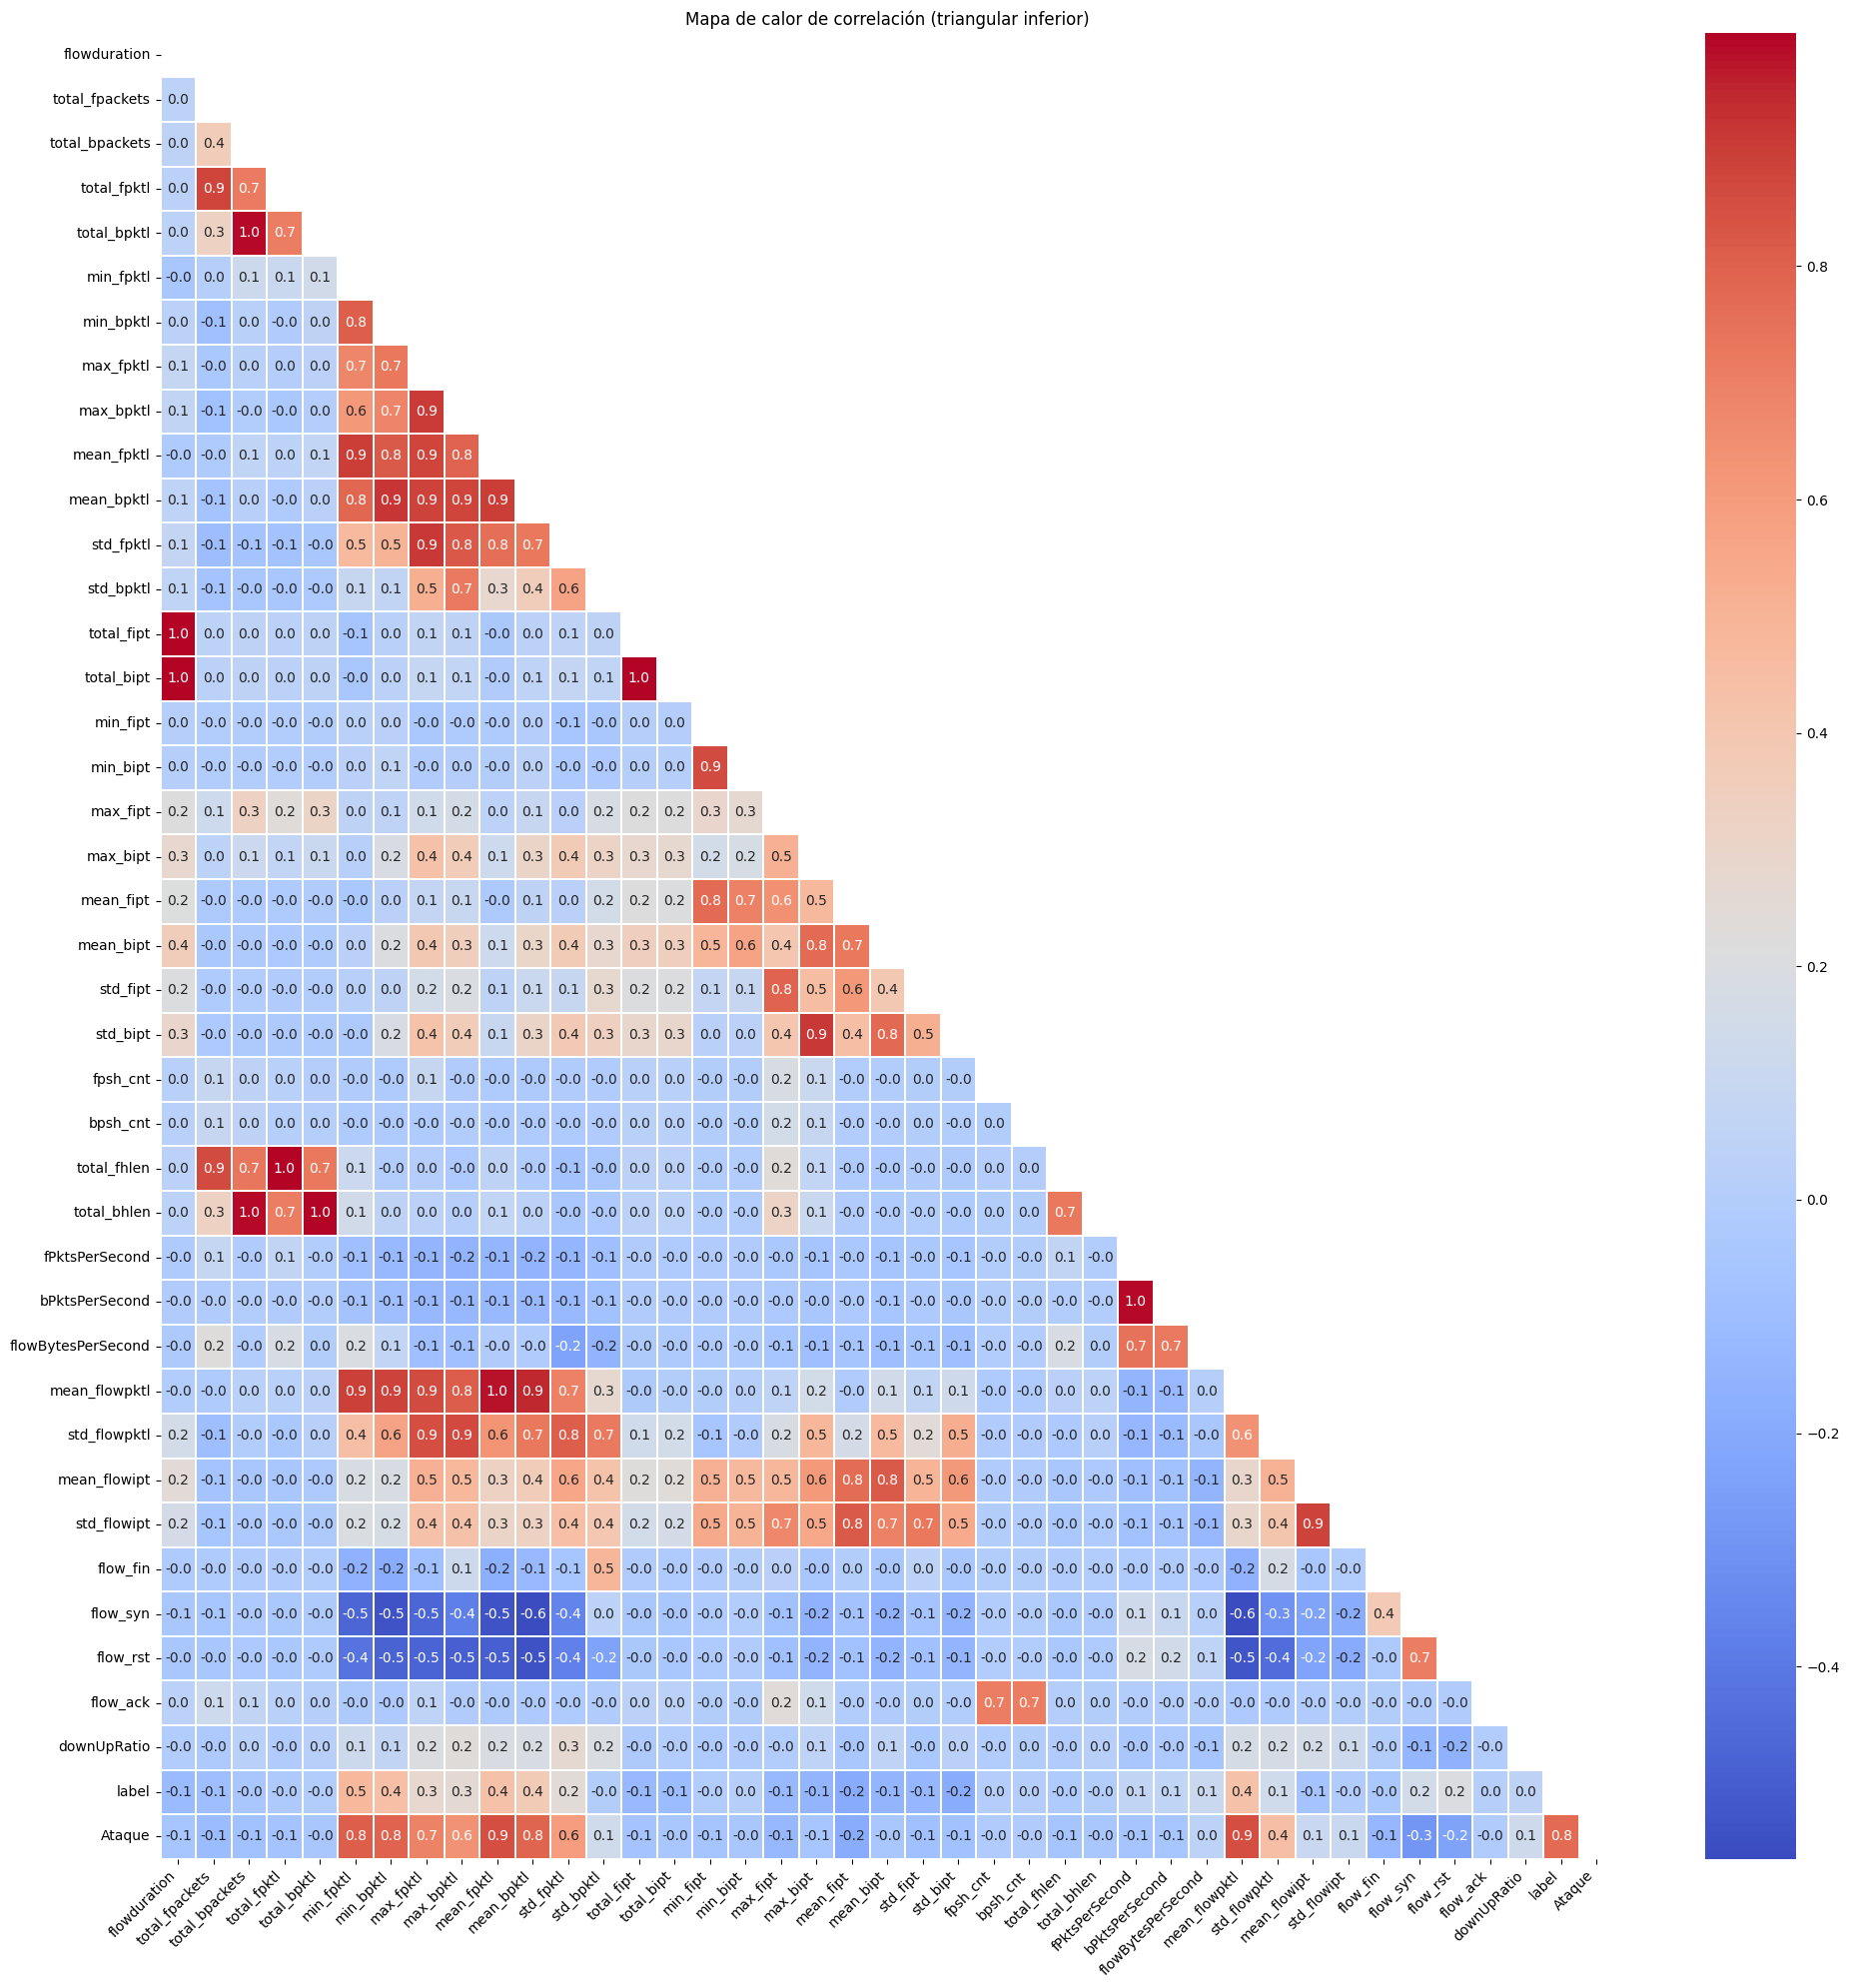

In [24]:
#Calcular la matriz de correlación
#correlation_matrix = df.drop('label', axis=1).corr()
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

### Observaciones analíticas (con anotaciones)

1. **Alta colinealidad en algunas características**  
   Se observa una alta correlación perfecta (`1.0`) entre algunas características, como `total_bpktl` con `total_fpktl` y `total_bBpktl`, lo que indica que estas variables están completamente redundadas. Asimismo, existen múltiples pares con correlaciones por encima de `0.85`, lo cual puede afectar negativamente modelos de aprendizaje automático debido a multicolinealidad. Se recomienda aplicar reducción de dimensionalidad o seleccionar un subconjunto de variables no redundantes mediante técnicas como VIF o PCA.

2. **Correlación con la etiqueta (`label`)**  
   La mayoría de las correlaciones entre las variables y la columna `label` se encuentran en rangos bajos, principalmente entre `-0.2` y `0.2`. No obstante, variables como `flow_syn`, `flow_ack` y `downUpRatio` muestran correlaciones negativas moderadas (hasta alrededor de `-0.3`), lo cual puede indicar una ligera asociación útil para propósitos de clasificación binaria. Aunque no se trata de correlaciones fuertes, sí podrían aportar valor como indicadores tempranos.

3. **Relaciones débiles y posible independencia lineal**  
   Una gran proporción de las celdas presenta valores cercanos a `0.0`, lo que sugiere que muchas variables no están linealmente relacionadas entre sí. Esto es útil en modelos de clasificación o regresión, ya que puede implicar que aportan información complementaria. Sin embargo, se debe tener precaución, ya que relaciones no lineales podrían no estar siendo capturadas por esta matriz. Se sugiere realizar análisis complementarios como mutual information o métodos de selección no paramétricos.




## Eliminacion de features altamente correlacionadas
Eliminar automáticamente características altamente correlacionadas entre sí, basado en un umbral (por ejemplo, 0.95):

In [25]:
# Calcular la matriz de correlación absoluta
corr_matrix = df.corr().abs()

# Crear una máscara para la parte superior del triángulo
upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# Encontrar columnas con correlación mayor al umbral
umbral = 0.95
columnas_a_eliminar = [column for column in upper.columns if any(upper[column] > umbral)]

# Mostrar las columnas que serán eliminadas
print("Características altamente correlacionadas (r > {:.2f}):".format(umbral))
print(columnas_a_eliminar)

# Eliminar del DataFrame
df = df.drop(columns=columnas_a_eliminar)

Características altamente correlacionadas (r > 0.95):
['flowduration', 'total_bpackets', 'total_fpktl', 'total_bpktl', 'mean_fpktl', 'total_fipt', 'fPktsPerSecond']


In [26]:
df.shape

(3618, 34)

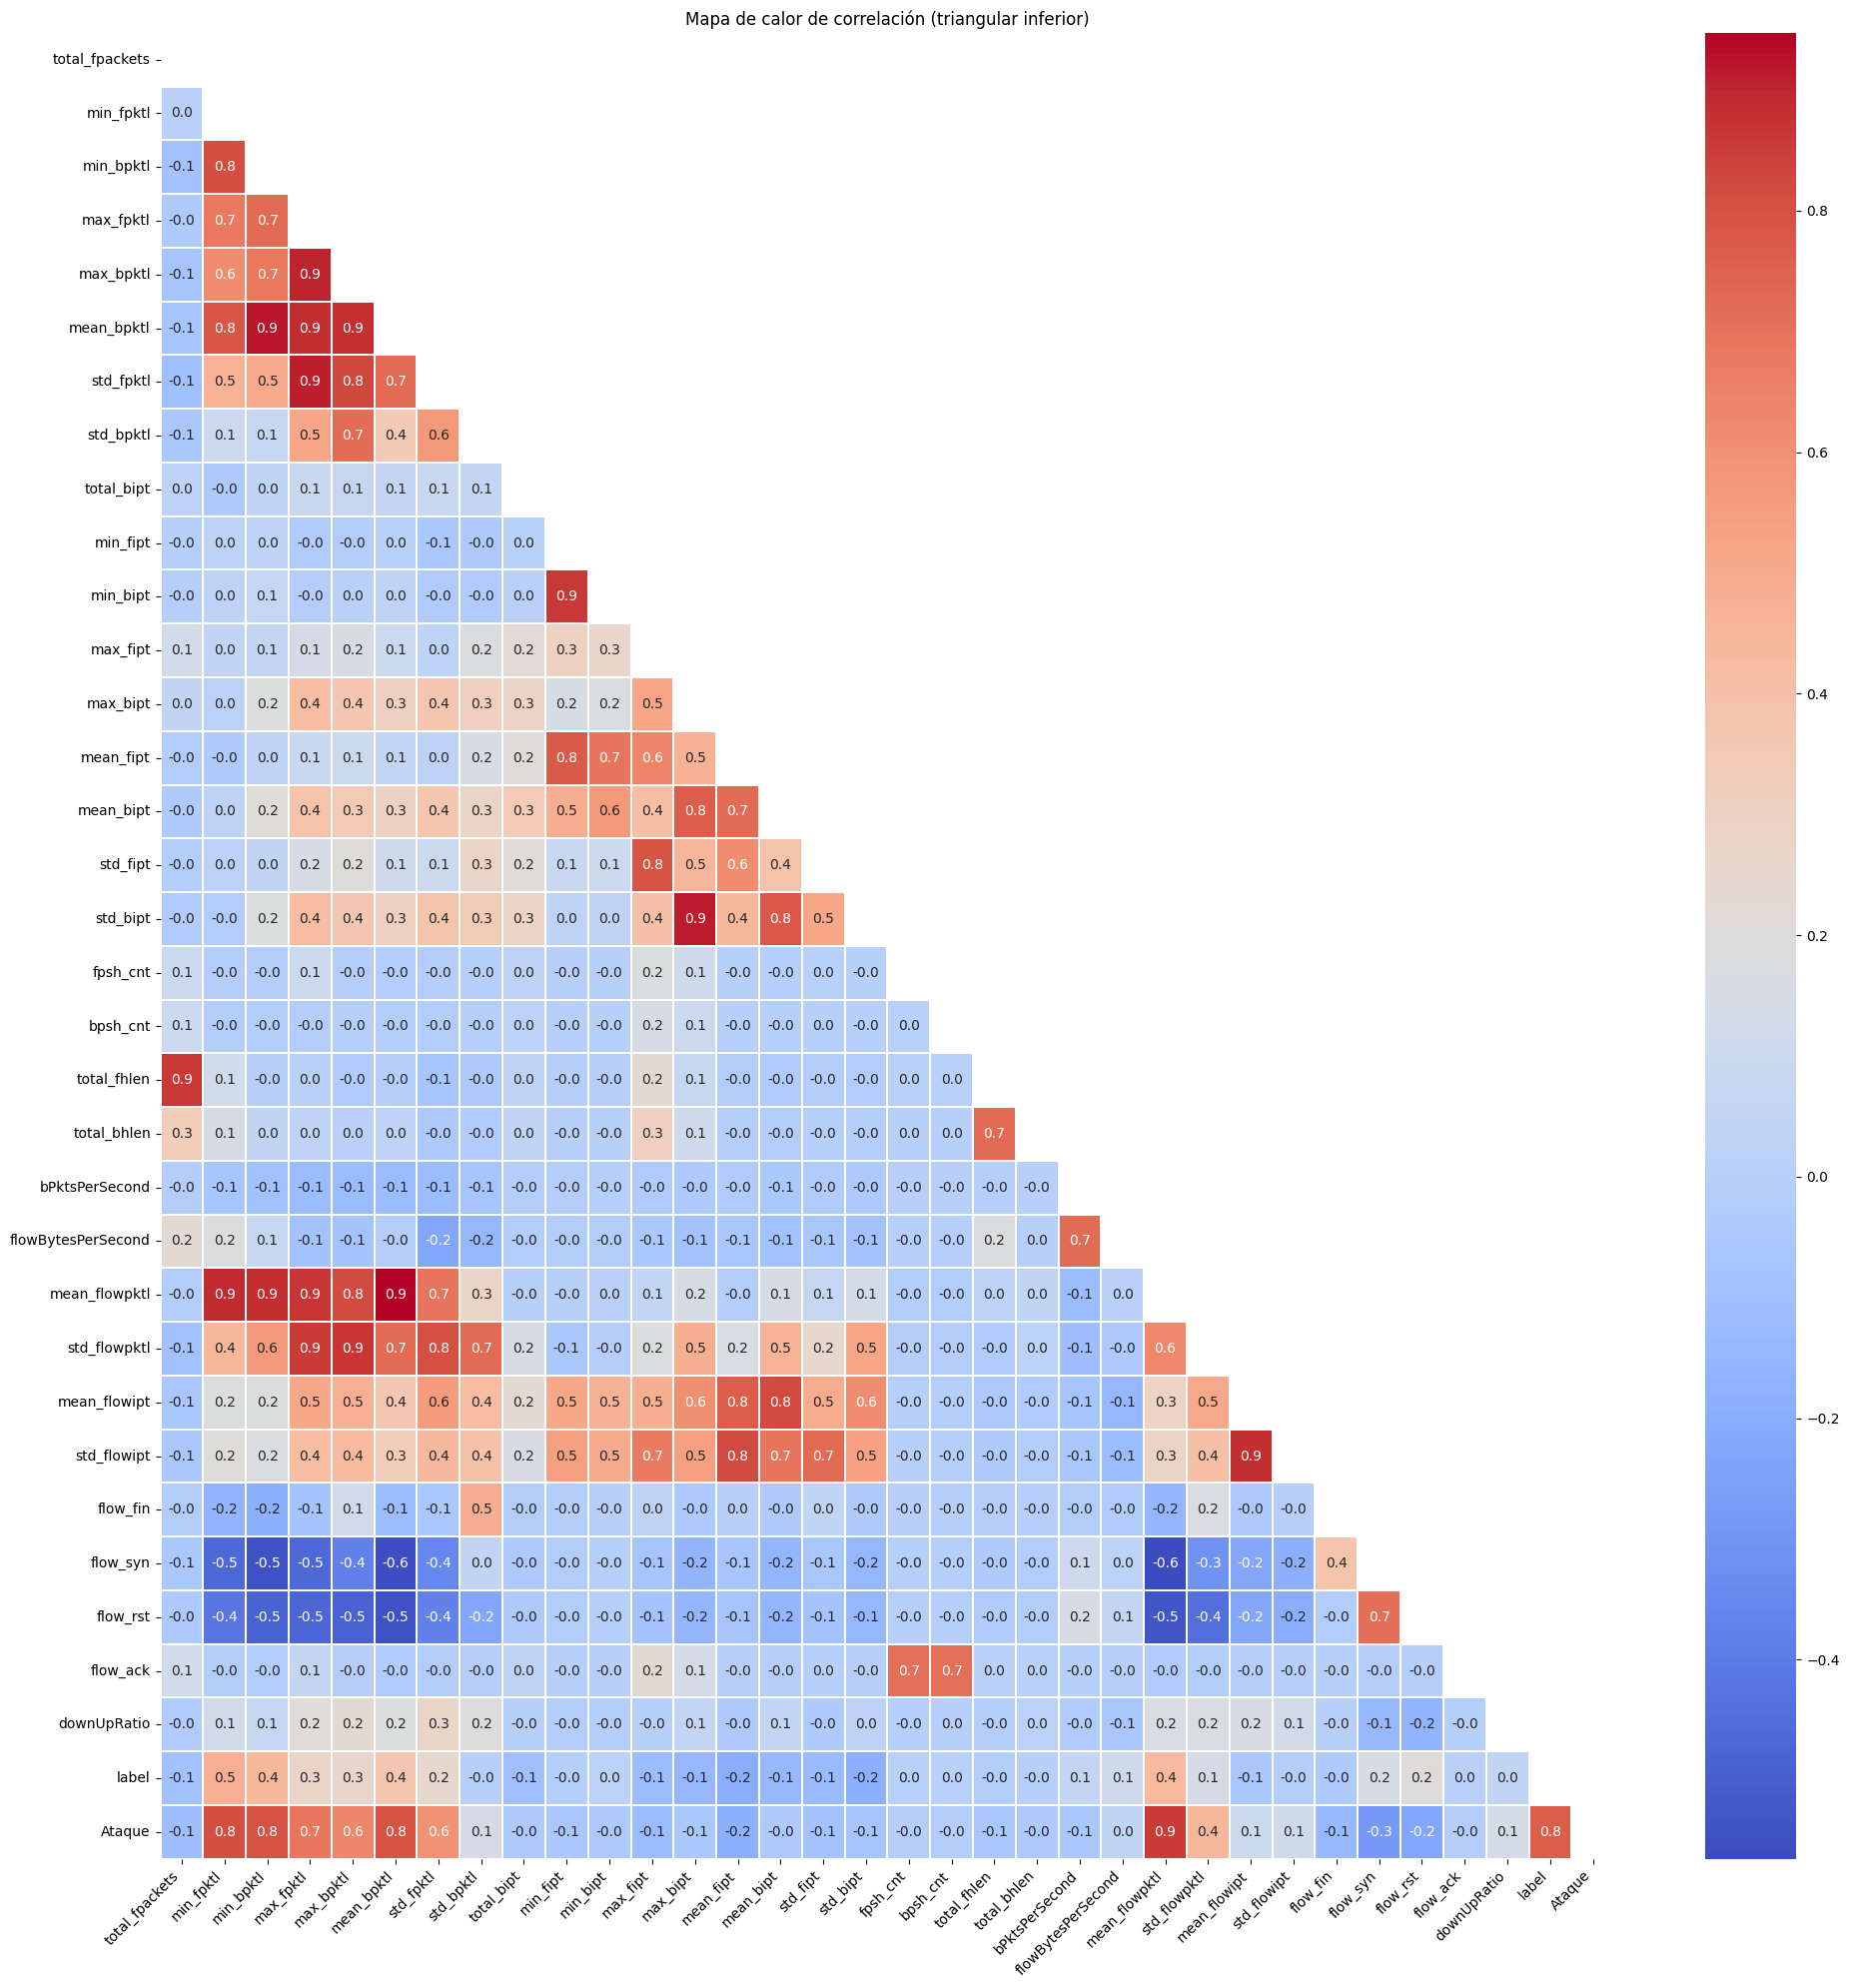

In [27]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

# VIF

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop('label', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data.sort_values("VIF", ascending=False))

feature           VIF
30            flow_ack  1.363267e+06
18            bpsh_cnt  6.798395e+05
17            fpsh_cnt  6.789356e+05
5           mean_bpktl  3.373561e+02
23       mean_flowpktl  2.462582e+02
2            min_bpktl  1.971909e+02
3            max_fpktl  1.866953e+02
4            max_bpktl  1.224072e+02
6            std_fpktl  9.594955e+01
13           mean_fipt  6.566728e+01
26         std_flowipt  5.877908e+01
24        std_flowpktl  5.427133e+01
1            min_fpktl  5.260201e+01
19         total_fhlen  5.029300e+01
32              Ataque  4.599011e+01
16            std_bipt  4.512908e+01
25        mean_flowipt  3.818047e+01
15            std_fipt  3.609222e+01
14           mean_bipt  3.385836e+01
9             min_fipt  3.071951e+01
7            std_bpktl  2.959436e+01
0       total_fpackets  2.721186e+01
12            max_bipt  1.950426e+01
20         total_bhlen  1.438708e+01
10            min_bipt  1.279696e+01
11            max_fipt  1.024334e+01
22  flowBytesPerSecond  7.018469e+00
28            flow_syn  4.306918e+00
21      bPktsPerSecond  4.256992e+00
29            flow_rst  3.537236e+00
27            flow_fin  2.294013e+00
8           total_bipt  1.633249e+00
31         downUpRatio  1.592458e+00

### Análisis de multicolinealidad (VIF)

1. **VIF extremadamente altos**  
   Variables como `flow_ack`, `flow_cwr` y `bpsh_cnt` presentan valores de VIF **mayores a 100,000**, lo cual indica una colinealidad casi perfecta con otras variables. Esto puede causar:
   - Inestabilidad en los coeficientes de modelos lineales (como regresión logística).
   - Dificultad para interpretar la importancia individual de las variables.
   - Inflación del error estándar en los modelos.

2. **Umbral práctico de VIF**  
   Aunque el umbral de tolerancia puede variar según el dominio, las recomendaciones comunes son:
   - **VIF > 10**: indica multicolinealidad severa → considerar eliminar la variable.
   - **VIF entre 5 y 10**: colinealidad moderada → revisar su aporte predictivo.
   - **VIF < 5**: considerado aceptable.

3. **Recomendación inmediata**  
   Se recomienda **eliminar iterativamente** las variables con el VIF más alto hasta que todos los valores estén por debajo de un umbral aceptable (por ejemplo, 10). Esto se puede automatizar para mayor eficiencia (ver código sugerido abajo).




In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def eliminar_vif_alto(df, etiqueta='label', umbral=10.0):
    X = df.drop(columns=[etiqueta,'Ataque'])
    while True:
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )
        max_vif = vif.max()
        if max_vif > umbral:
            col_a_eliminar = vif.idxmax()
            print(f"Eliminando '{col_a_eliminar}' con VIF = {max_vif:.2f}")
            X = X.drop(columns=[col_a_eliminar])
        else:
            break
    # reconstruir el dataframe con la etiqueta incluida
    return pd.concat([X, df[[etiqueta,'Ataque']]], axis=1)

# Ejecutar limpieza
df = eliminar_vif_alto(df)

Eliminando 'flow_ack' con VIF = 1351910.80
Eliminando 'mean_bpktl' con VIF = 318.23
Eliminando 'max_fpktl' con VIF = 182.76
Eliminando 'mean_flowpktl' con VIF = 107.68
Eliminando 'max_bpktl' con VIF = 87.37
Eliminando 'std_flowipt' con VIF = 46.90
Eliminando 'mean_fipt' con VIF = 46.60
Eliminando 'std_bipt' con VIF = 37.58
Eliminando 'total_fhlen' con VIF = 36.02
Eliminando 'std_flowpktl' con VIF = 27.24
Eliminando 'min_fpktl' con VIF = 14.55
Eliminando 'mean_flowipt' con VIF = 12.32


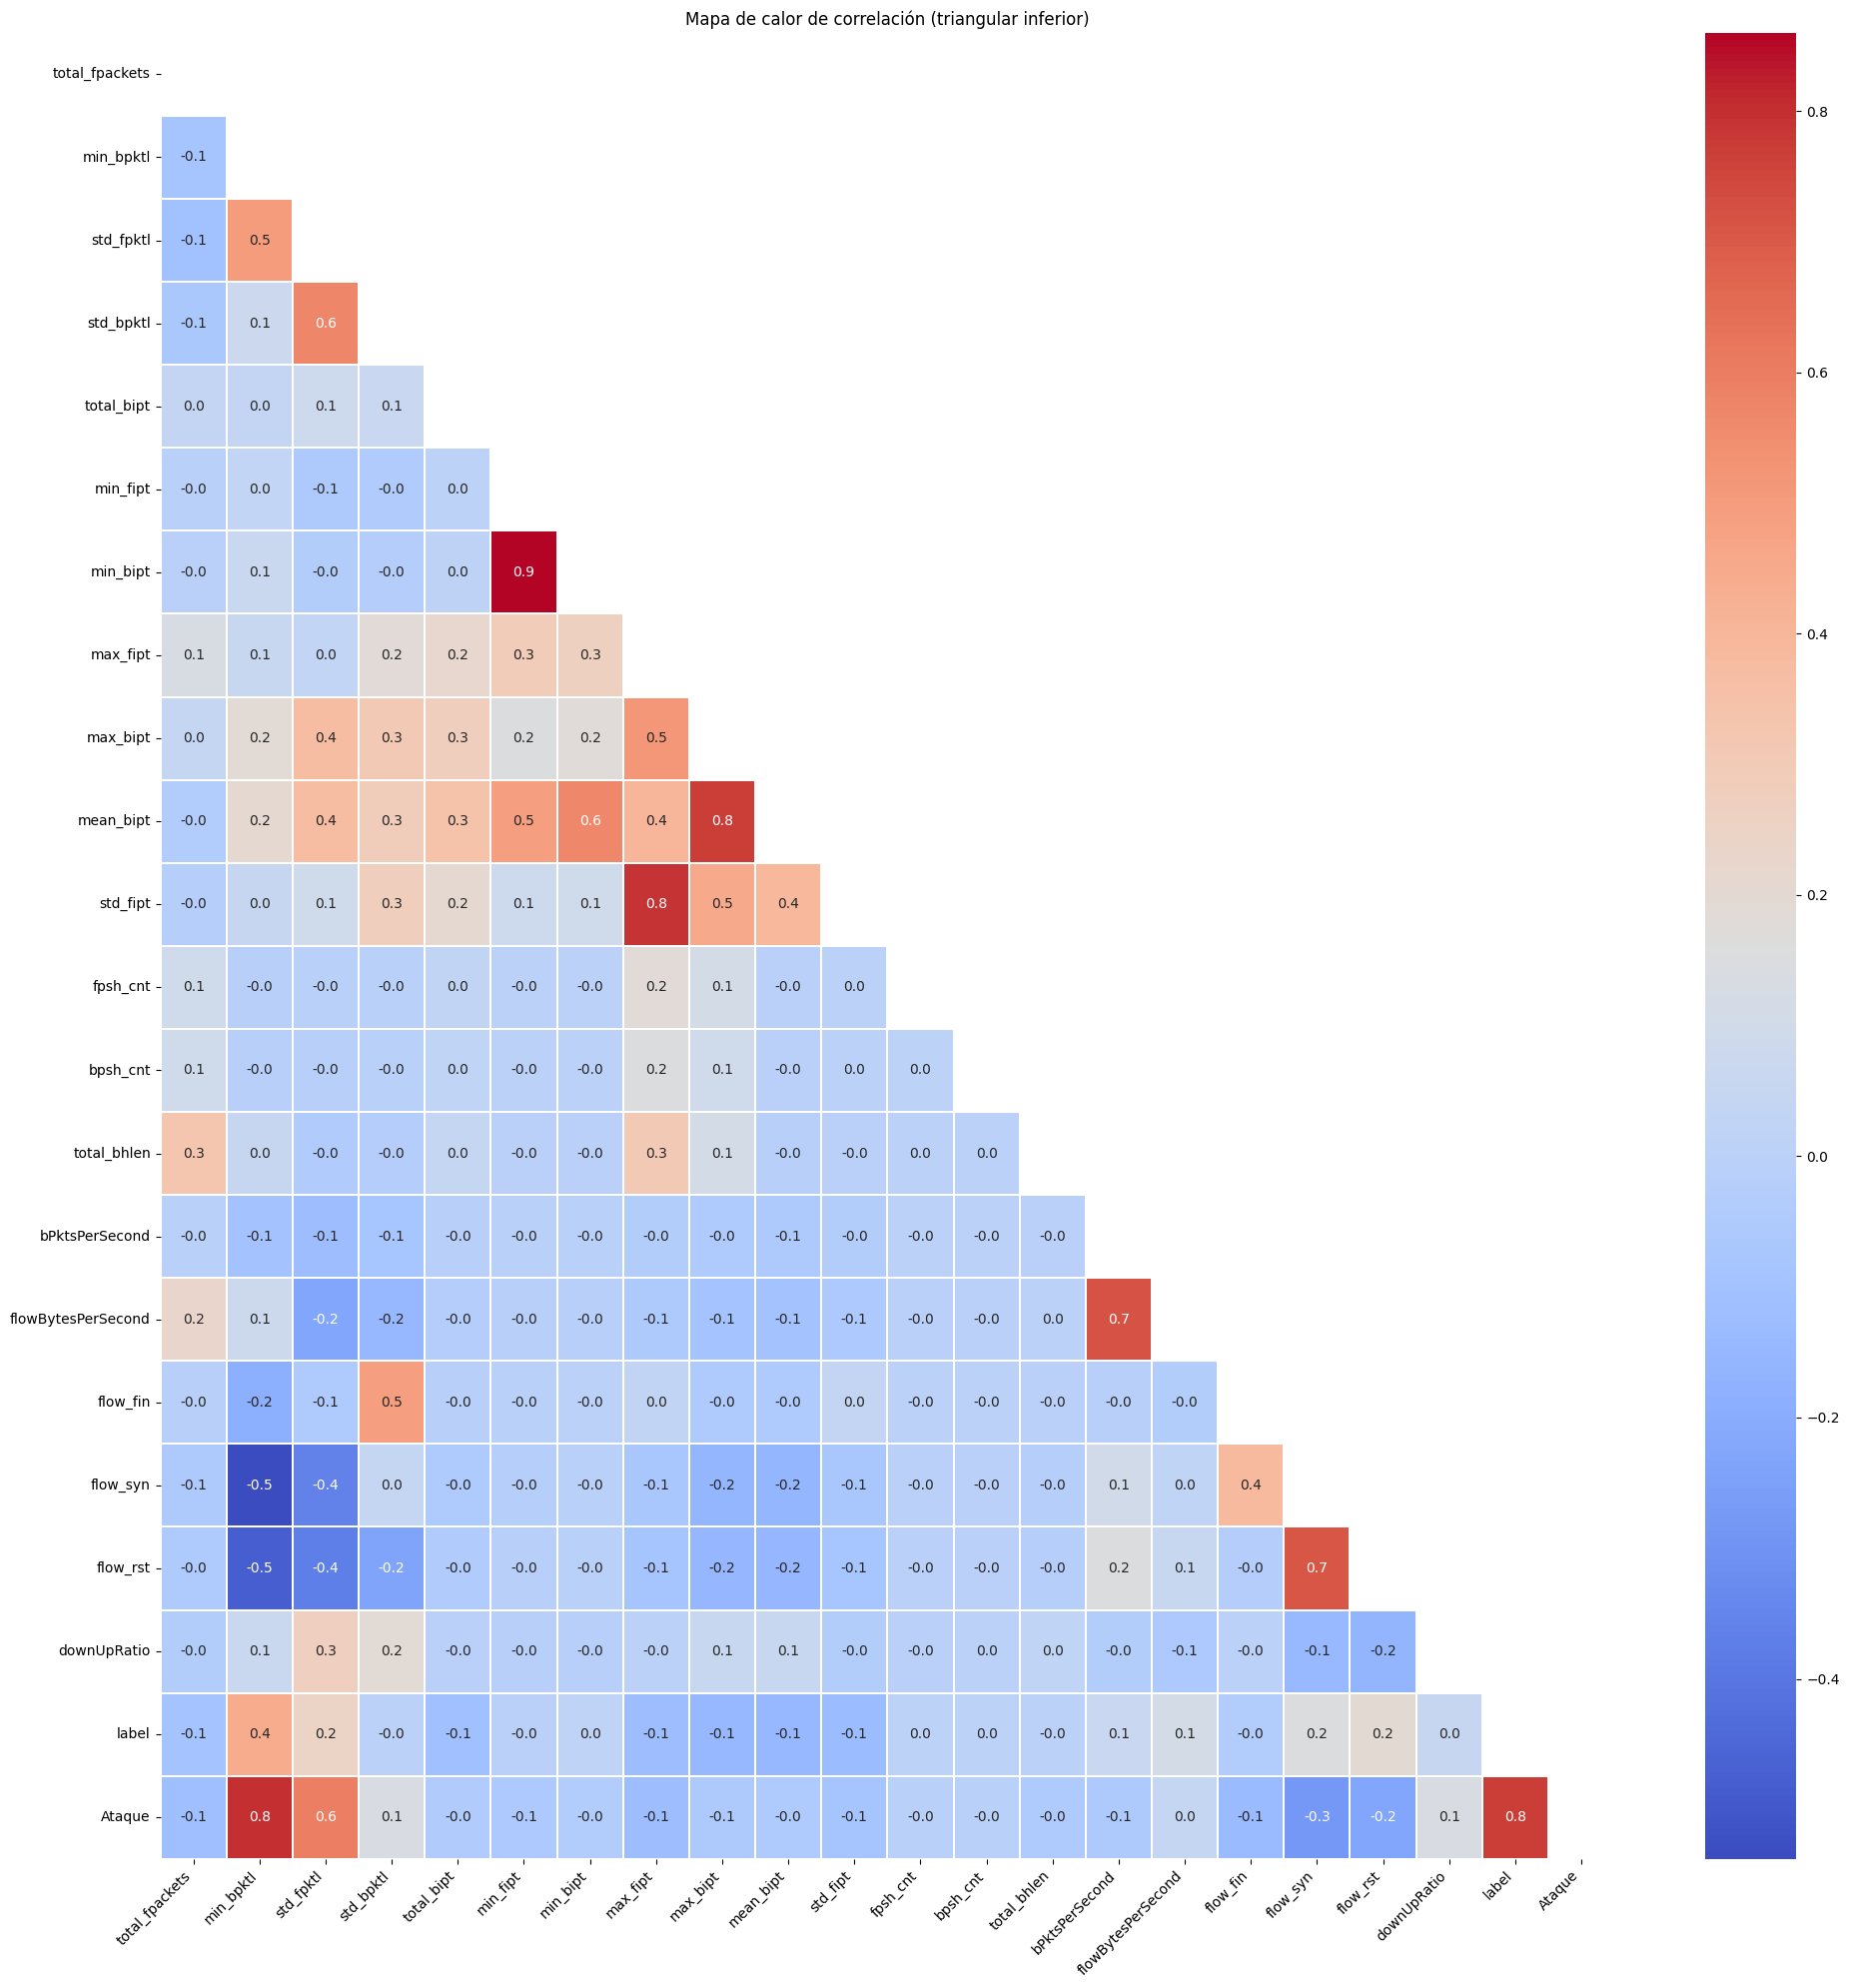

In [30]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear la máscara para ocultar la parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Graficar heatmap con la máscara aplicada
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".1f",
            linewidths=.05, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

# Rotar etiquetas en eje x
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de calor de correlación (triangular inferior)')
plt.tight_layout()
plt.show()

In [31]:
df.shape

(3618, 22)

### VIF

In [32]:
df.head()

total_fpackets  min_bpktl  std_fpktl  std_bpktl  total_bipt   min_fipt  \
0               9        485   0.000000  11.000000  522.293022  45.285080   
1               1        485   0.000000   0.000000    0.000000   0.000000   
2               1        507   0.000000   0.000000    0.000000   0.000000   
3               1        507   0.000000   0.000000    0.000000   0.000000   
4               2        485   0.707107  16.263456   54.349739  54.349682   

    min_bipt   max_fipt   max_bipt  mean_bipt   std_fipt  fpsh_cnt  bpsh_cnt  \
0  45.284916  89.902214  89.902138  65.286629  17.040119         0         0   
1   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
2   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
3   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
4  54.349739  54.349682  54.349739  54.349739   0.000000         0         0   

   total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
0         4125        0.017232           16.065691         0         0   
1          451      572.757629       529800.812500         0         0   
2          473      859.840942       814269.375000         0         0   
3          473      865.697449       819815.437500         0         0   
4          925        0.036799           34.480293         0         0   

   flow_rst  downUpRatio  label  Ataque  
0         0     1.118939      1       1  
1         0     1.102273      1       1  
2         0     1.152273      1       1  
3         0     1.152273      1       1  
4         0     1.127128      1       1

In [33]:
#Hacemos una copia de nuestro dataset
X=df.copy()
X.drop(['label','Ataque'],axis=1,inplace=True)

In [34]:
# Conjunto de variables predictora

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
    for i in range(len(X.columns))]

print(vif_data)

               feature       VIF
0       total_fpackets  1.389851
1            min_bpktl  3.782046
2            std_fpktl  6.972318
3            std_bpktl  4.432508
4           total_bipt  1.323044
5             min_fipt  4.311475
6             min_bipt  5.195896
7             max_fipt  7.383156
8             max_bipt  5.073520
9            mean_bipt  8.073120
10            std_fipt  5.592929
11            fpsh_cnt  1.215928
12            bpsh_cnt  1.153473
13         total_bhlen  1.742229
14      bPktsPerSecond  2.667198
15  flowBytesPerSecond  3.302216
16            flow_fin  2.121551
17            flow_syn  3.687488
18            flow_rst  3.069160
19         downUpRatio  1.427089


In [35]:
df.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum()


np.int64(77)

In [36]:
# Eliminar duplicados
df = df.drop_duplicates()
# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
df_cleaned = df.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
df_cleaned = df[~df_cleaned]
df=df_cleaned.copy()

In [37]:
df.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum()

np.int64(0)

# Creando conjunto de entrenamiento

## Split
La funcion `train_test_split` nos permite dividir un dataset en dos bloques, típicamente bloques destinados al entrenamiento y validación del modelo

In [38]:
df.head()

total_fpackets  min_bpktl  std_fpktl  std_bpktl  total_bipt   min_fipt  \
0               9        485   0.000000  11.000000  522.293022  45.285080   
1               1        485   0.000000   0.000000    0.000000   0.000000   
2               1        507   0.000000   0.000000    0.000000   0.000000   
3               1        507   0.000000   0.000000    0.000000   0.000000   
4               2        485   0.707107  16.263456   54.349739  54.349682   

    min_bipt   max_fipt   max_bipt  mean_bipt   std_fipt  fpsh_cnt  bpsh_cnt  \
0  45.284916  89.902214  89.902138  65.286629  17.040119         0         0   
1   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
2   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
3   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
4  54.349739  54.349682  54.349739  54.349739   0.000000         0         0   

   total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
0         4125        0.017232           16.065691         0         0   
1          451      572.757629       529800.812500         0         0   
2          473      859.840942       814269.375000         0         0   
3          473      865.697449       819815.437500         0         0   
4          925        0.036799           34.480293         0         0   

   flow_rst  downUpRatio  label  Ataque  
0         0     1.118939      1       1  
1         0     1.102273      1       1  
2         0     1.152273      1       1  
3         0     1.152273      1       1  
4         0     1.127128      1       1

In [39]:
df.shape

(3541, 22)

In [40]:
df=df.dropna()

In [41]:
df.shape

(3541, 22)

In [42]:
# Positivos para entrenamiento
df_train = df[(df['Ataque'] != 10) & (df['Ataque'] != 0)].copy()
# Positivos para validación
df_val_pos = df[df['Ataque'] == 10].copy()
# Negativos
df_neg = df[df['Ataque'] == 0].copy()

print("df_train", len(df_train),", df_val_pos", len(df_val_pos),", df_neg", len(df_neg))


df_train 948 , df_val_pos 1874 , df_neg 719


In [43]:
df_train.head()

total_fpackets  min_bpktl  std_fpktl  std_bpktl  total_bipt   min_fipt  \
0               9        485   0.000000  11.000000  522.293022  45.285080   
1               1        485   0.000000   0.000000    0.000000   0.000000   
2               1        507   0.000000   0.000000    0.000000   0.000000   
3               1        507   0.000000   0.000000    0.000000   0.000000   
4               2        485   0.707107  16.263456   54.349739  54.349682   

    min_bipt   max_fipt   max_bipt  mean_bipt   std_fipt  fpsh_cnt  bpsh_cnt  \
0  45.284916  89.902214  89.902138  65.286629  17.040119         0         0   
1   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
2   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
3   0.000000   0.000000   0.000000   0.000000   0.000000         0         0   
4  54.349739  54.349682  54.349739  54.349739   0.000000         0         0   

   total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
0         4125        0.017232           16.065691         0         0   
1          451      572.757629       529800.812500         0         0   
2          473      859.840942       814269.375000         0         0   
3          473      865.697449       819815.437500         0         0   
4          925        0.036799           34.480293         0         0   

   flow_rst  downUpRatio  label  Ataque  
0         0     1.118939      1       1  
1         0     1.102273      1       1  
2         0     1.152273      1       1  
3         0     1.152273      1       1  
4         0     1.127128      1       1

In [44]:
df_neg_train,df_neg_val = train_test_split(df_neg.sample(frac=1,random_state=42),test_size=0.20,random_state=42)

print("df_neg_train:",len(df_neg_train),", df_neg_val:",len(df_neg_val))

df_train_f=pd.concat([df_train,df_neg_train],ignore_index=1)
df_val_f=pd.concat([df_val_pos,df_neg_val],ignore_index=1)

df_train_f=df_train_f.sample(frac=1, random_state=42)

df_val_f=df_val_f.sample(frac=1, random_state=42)

print("df_train_f:",len(df_train_f),", df_val_f:",len(df_val_f))



df_neg_train: 575 , df_neg_val: 144
df_train_f: 1523 , df_val_f: 2018


In [45]:
X_train,X_test,y_train,y_test = train_test_split(df_train_f.drop(columns=['label']), df_train_f['label'], test_size=0.25, random_state=42)

In [46]:
#Original dataset dimensions
X_train.shape, X_test.shape


((1142, 21), (381, 21))

In [47]:
X_train

total_fpackets  min_bpktl   std_fpktl   std_bpktl  total_bipt  min_fipt  \
949                1         74    0.000000    0.000000    0.000000  0.000000   
472                2         58    2.828427    0.000000    0.000000  0.000995   
1481            7347         66   11.028303    3.788200  147.317027  0.000011   
588                3         54   46.130250    8.485281    0.000865  0.000021   
147                2        174    7.778175    7.778175    0.003110  0.004592   
...              ...        ...         ...         ...         ...       ...   
635                3         54   47.258157    8.485281    0.001051  0.000020   
488                2         58    2.828427    0.000000    0.000000  0.000924   
539                5         54   18.676188    8.843076    6.019411  0.000031   
1498              14         66  161.638178  309.885646    4.369376  0.000010   
830                2         58    2.828427    0.000000    0.000000  0.000898   

      min_bipt  max_fipt  max_bipt  mean_bipt  std_fipt  fpsh_cnt  bpsh_cnt  \
949   0.000000  0.000000  0.000000   0.000000  0.000000         0         0   
472   0.000000  0.000995  0.000000   0.000000  0.000000         0         0   
1481  0.000000  0.576395  2.140591   0.020415  0.013659         0         0   
588   0.000865  0.000932  0.000865   0.000865  0.000644         1         0   
147   0.003110  0.004592  0.003110   0.003110  0.000000         0         0   
...        ...       ...       ...        ...       ...       ...       ...   
635   0.001051  0.000994  0.001051   0.001051  0.000689         1         0   
488   0.000000  0.000924  0.000000   0.000000  0.000000         0         0   
539   0.000004  6.004193  6.015693   1.504853  2.999359         1         1   
1498  0.000070  1.193210  1.219270   0.397216  0.326432         9         5   
830   0.000000  0.000898  0.000000   0.000000  0.000000         0         0   

      total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
949            40       93.633308        12734.129880         0         0   
472            24     1004.864380       170826.953100         0         2   
1481      1298281       48.989452        21111.916020         0         0   
588            52     1116.100098       217639.515600         0         2   
147           291      411.690613       110744.773400         0         0   
...           ...             ...                 ...       ...       ...   
635            52      980.894287       192255.281300         0         2   
488            24     1082.121826       183960.703100         0         2   
539           112        0.830278          105.113235         1         2   
1498          412        2.634892          983.473267         2         3   
830            24     1113.729126       189333.953100         0         2   

      flow_rst  downUpRatio  Ataque  
949          0     1.193548       0  
472          1     0.517857       4  
1481         0     0.985423       0  
588          1     0.444444       4  
147          0     2.005587       4  
...        ...          ...     ...  
635          1     0.441176       4  
488          1     0.517857       4  
539          1     0.906627       4  
1498         0     1.079387       0  
830          1     0.517857       4  

[1142 rows x 21 columns]

In [48]:
print("",collections.Counter(y_train),"",collections.Counter(y_test))

 Counter({1: 716, 0: 426})  Counter({1: 232, 0: 149})


In [49]:
A_train=X_train.Ataque.copy()
collections.Counter(X_train.Ataque)

Counter({4: 681, 0: 426, 5: 15, 3: 10, 1: 6, 2: 4})

In [50]:
A_train

949     0
472     4
1481    0
588     4
147     4
       ..
635     4
488     4
539     4
1498    0
830     4
Name: Ataque, Length: 1142, dtype: int64

In [51]:
A_test=X_test.Ataque.copy()


In [52]:
A_test

1452    0
93      4
20      3
920     4
947     5
       ..
924     4
625     4
981     0
412     4
724     4
Name: Ataque, Length: 381, dtype: int64

In [53]:
collections.Counter(y_test)

Counter({1: 232, 0: 149})

## Estandarizacion de variables numericas

**Estandarizar las variables** significa ajustar sus valores para que tengan una media de cero y una desviación estándar de uno

In [54]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(X_train)
X_train_stand = preprocessor.transform(X_train)
X_test_stand  = preprocessor.transform(X_test)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

## Regenerando el dataset

In [55]:
labels=list(X_train.columns.values.tolist())
df_X_train_stand=pd.DataFrame(X_train_stand,columns=labels)
df_X_test_stand=pd.DataFrame(X_test_stand,columns=labels)
df_X_train_stand.drop(['Ataque'],axis=1,inplace=True)
df_X_test_stand.drop(['Ataque'],axis=1,inplace=True)

In [56]:
df_X_train_stand.columns

Index(['total_fpackets', 'min_bpktl', 'std_fpktl', 'std_bpktl', 'total_bipt',
       'min_fipt', 'min_bipt', 'max_fipt', 'max_bipt', 'mean_bipt', 'std_fipt',
       'fpsh_cnt', 'bpsh_cnt', 'total_bhlen', 'bPktsPerSecond',
       'flowBytesPerSecond', 'flow_fin', 'flow_syn', 'flow_rst',
       'downUpRatio'],
      dtype='object')

In [57]:
df_X_test_stand

total_fpackets  min_bpktl  std_fpktl  std_bpktl  total_bipt  min_fipt  \
0         -0.142782  -0.398118   0.569307   0.098306    0.428599 -0.060565   
1         -0.147517  -0.506589  -0.471091  -0.397873   -0.361215 -0.096046   
2         -0.135004   4.700056   0.561021  -0.397873    1.271027  0.225626   
3         -0.147066  -0.506589   3.265303   3.605512   -0.360910 -0.095749   
4          6.149997  -0.994712  -0.456166  -0.397873   -0.361215 -0.096046   
..              ...        ...        ...        ...         ...       ...   
376       -0.146164  -0.398118  -0.238620  -0.397873   -0.361215 -0.095708   
377       -0.147291  -0.506589   0.173753  -0.281839   -0.361210 -0.096039   
378       -0.133200   3.199530   5.285863   1.443718    3.009704 -0.095872   
379       -0.147404  -0.470432  -0.432496  -0.397873   -0.361215 -0.095697   
380       -0.147404   0.578128  -0.364957  -0.291508   -0.361208 -0.094997   

     min_bipt  max_fipt  max_bipt  mean_bipt  std_fipt  fpsh_cnt  bpsh_cnt  \
0   -0.073124  0.328782  0.024211   0.232095  0.681262 -0.030142 -0.029932   
1   -0.073128 -0.275589 -0.262756  -0.251684 -0.271013 -0.030142 -0.029932   
2    0.207984  0.722112  3.182062   6.246919  0.598316 -0.030142 -0.029932   
3   -0.070817 -0.272837 -0.261122  -0.248444 -0.265817 -0.029017 -0.027684   
4   -0.073128 -0.272829 -0.262756  -0.251684 -0.270817 -0.030142 -0.029932   
..        ...       ...       ...        ...       ...       ...       ...   
376 -0.073128  2.405071 -0.262756  -0.251684  2.999195 -0.018891 -0.029932   
377 -0.072832 -0.275502 -0.262701  -0.251519 -0.270769 -0.029017 -0.029932   
378 -0.062021  0.724629  3.181759   1.774121  1.331409 -0.030142 -0.029932   
379 -0.073128 -0.275491 -0.262756  -0.251684 -0.271013 -0.030142 -0.029932   
380 -0.072701 -0.275294 -0.262677  -0.251446 -0.271013 -0.030142 -0.029932   

     total_bhlen  bPktsPerSecond  flowBytesPerSecond   flow_fin  flow_syn  \
0      -0.064425       -0.173164           -0.234235  -0.251703 -0.800532   
1      -0.064878        4.855081            4.224815  -0.251703  0.217516   
2      -0.064270       -0.173205           -0.234309  -0.251703 -0.800532   
3      -0.064870       -0.164948           -0.198751   4.310910  1.235565   
4      -0.064880       -0.173206            3.257806  -0.251703 -0.800532   
..           ...             ...                 ...        ...       ...   
376    -0.064877       -0.173204           -0.234300  10.394395  1.235565   
377    -0.064874       -0.045558           -0.036221  -0.251703  1.235565   
378    -0.061414       -0.173197           -0.234215  -0.251703 -0.800532   
379    -0.064878       -0.054908           -0.075085  -0.251703  1.235565   
380    -0.064847       -0.104558           -0.088106  -0.251703 -0.800532   

     flow_rst  downUpRatio  
0   -0.687161    -0.140749  
1    0.876062    -0.082271  
2   -0.687161    -0.139153  
3   -0.687161     0.046601  
4   -0.687161    -0.361922  
..        ...          ...  
376 -0.687161    -0.344862  
377  0.876062    -0.229408  
378 -0.687161    -0.144481  
379  0.876062    -0.206376  
380 -0.687161     0.240487  

[381 rows x 20 columns]

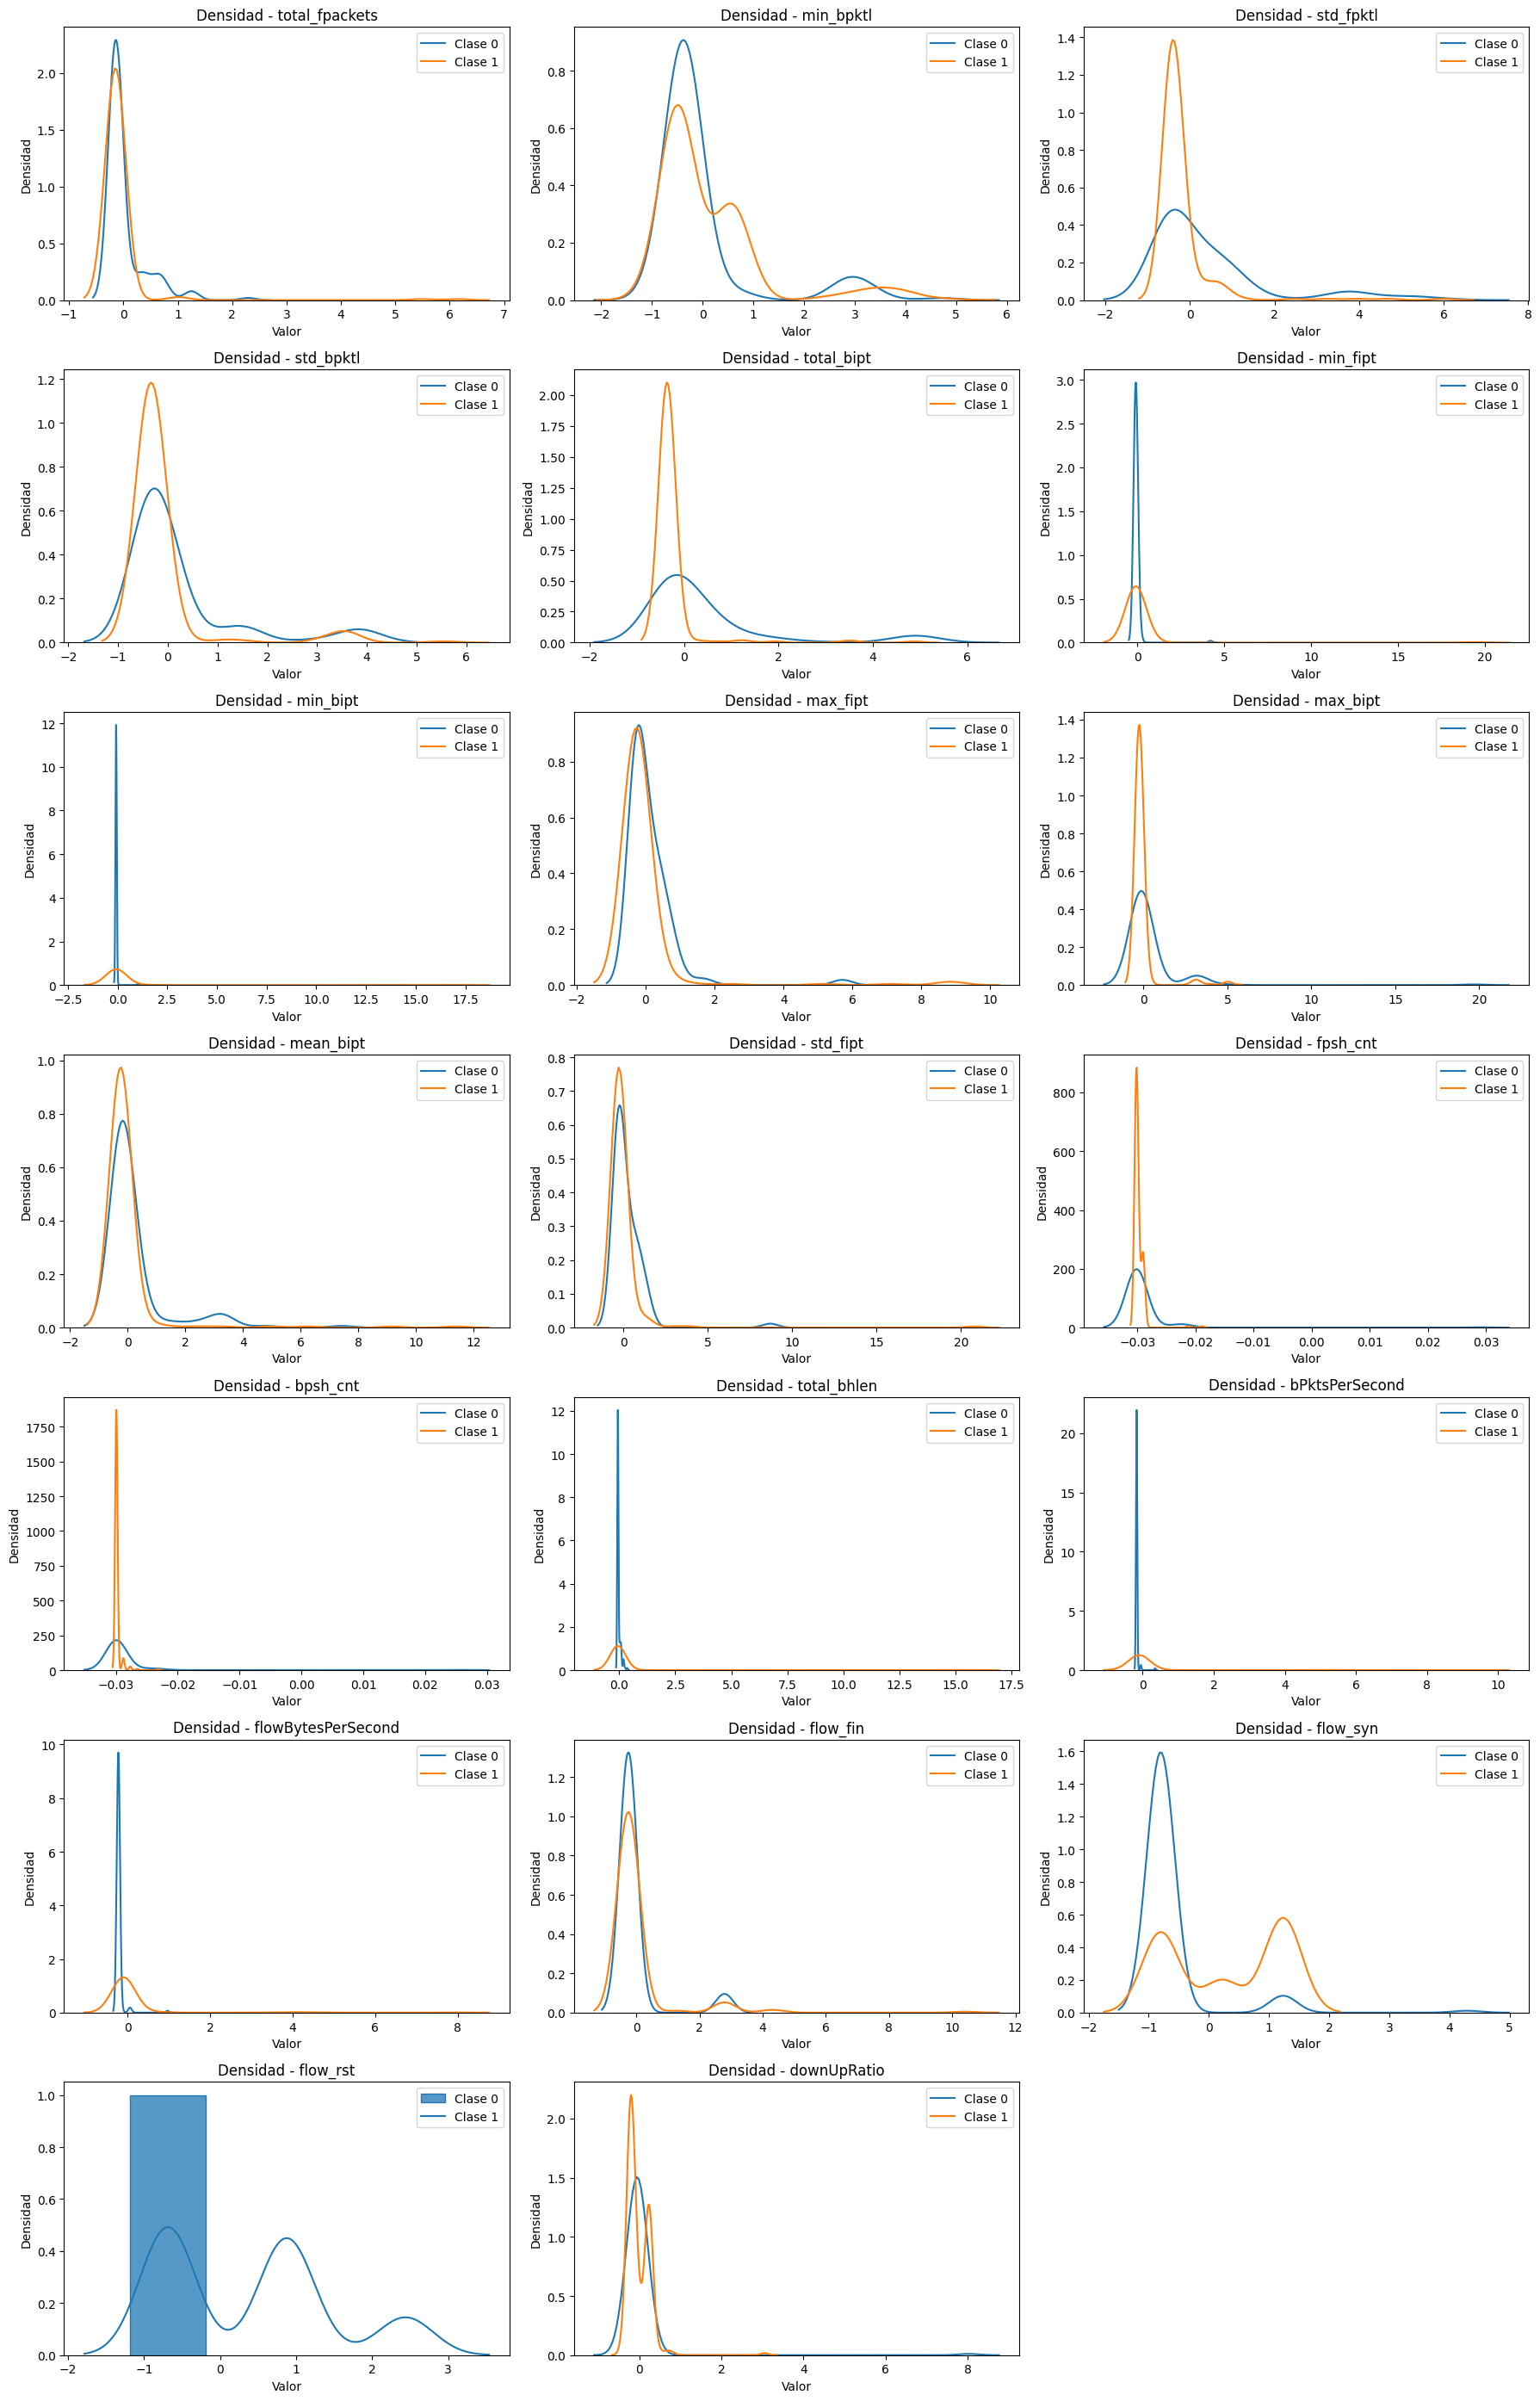

In [58]:
# Asegurar alineación por posición
y_test_series = pd.Series(y_test.values, index=df_X_test_stand.index)

# Obtener todas las features disponibles
features_to_plot = df_X_test_stand.columns
num_features = len(features_to_plot)

# Calcular dinámicamente el layout de subplots
cols = 3
rows = math.ceil(num_features / cols)

# Crear figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar densidades
for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in sorted(y_test_series.unique()):
        subset = df_X_test_stand.loc[y_test_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar ejes vacíos
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

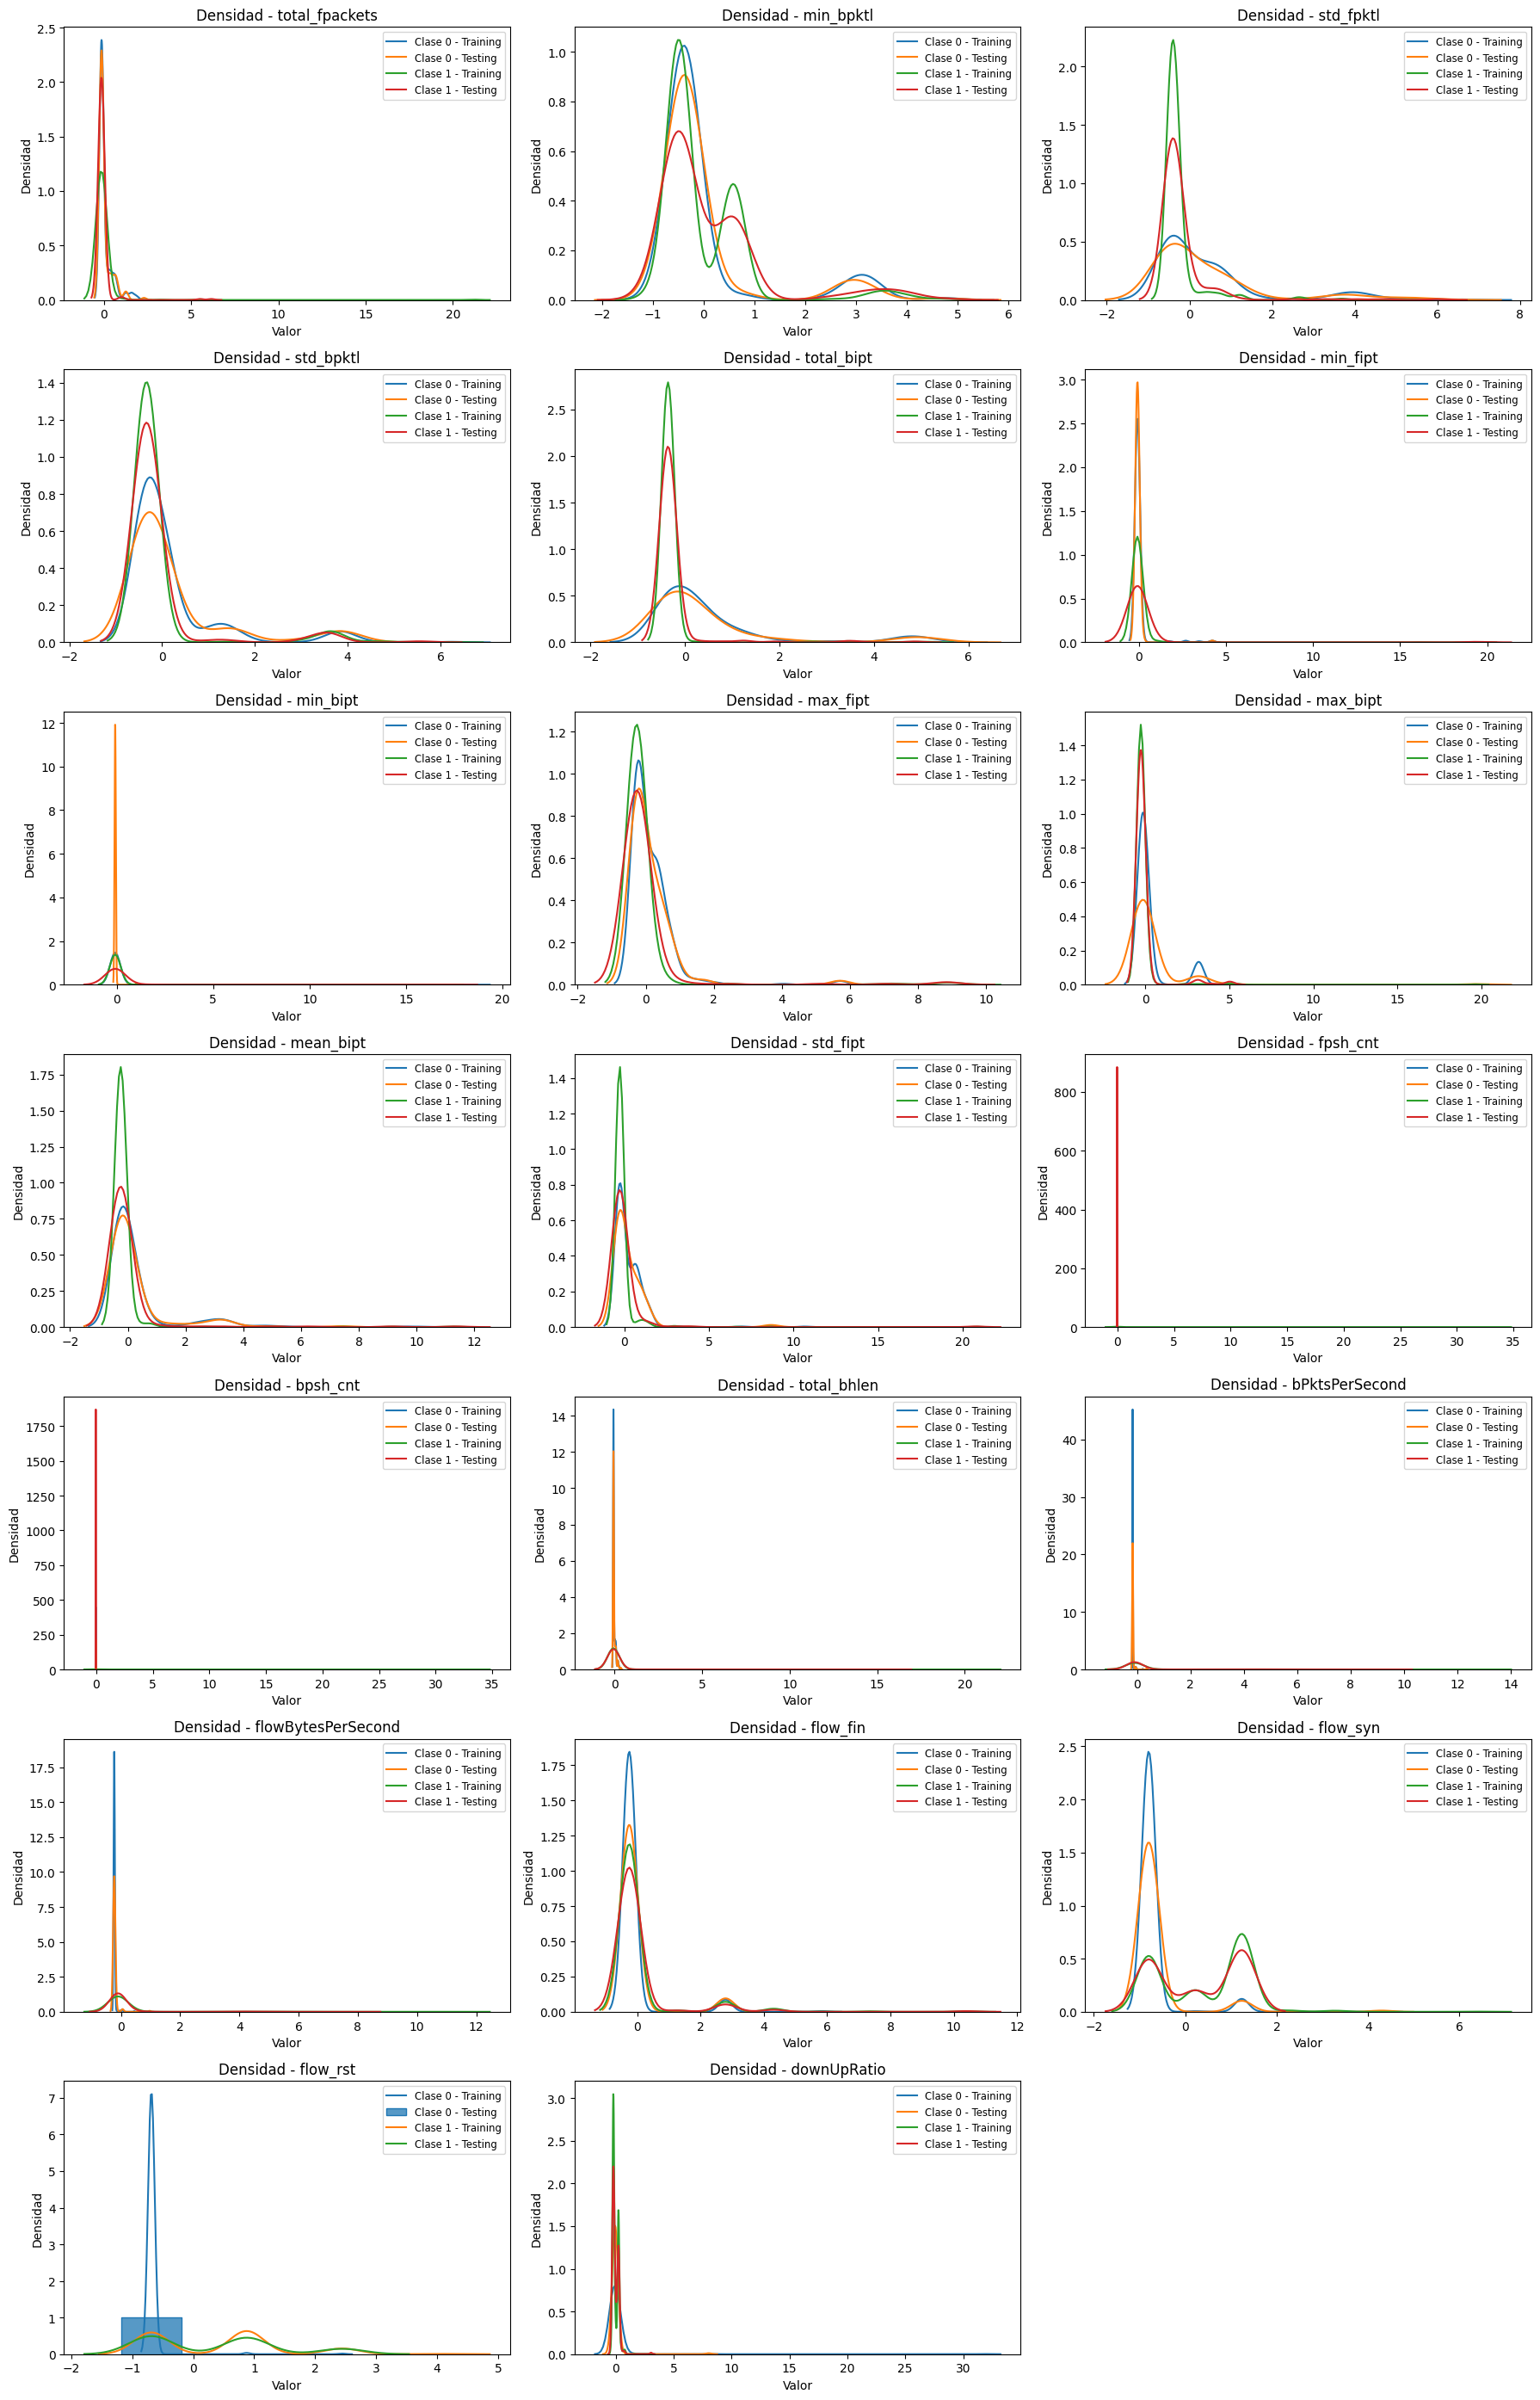

In [59]:
# Crear copias con etiquetas
X_train_dens = df_X_train_stand.copy()
X_train_dens["Set"] = "Training"
X_train_dens["Class"] = y_train.values  # Alineación por posición

X_test_dens = df_X_test_stand.copy()
X_test_dens["Set"] = "Testing"
X_test_dens["Class"] = y_test.values  # Alineación por posición

# Concatenar ambos
X_all_dens = pd.concat([X_train_dens, X_test_dens])
X_all_dens = X_all_dens.reset_index(drop=True)

# Seleccionar features
features_dens = df_X_train_stand.columns
num_features_dens = len(features_dens)

# Layout dinámico
cols = 3
rows = math.ceil(num_features_dens / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar densidades
for i, feature in enumerate(features_dens):
    ax = axs[i]
    data_ok = False
    for label_class in [0, 1]:
        for label_set in ["Training", "Testing"]:
            subset = X_all_dens[(X_all_dens["Class"] == label_class) & (X_all_dens["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Eliminar ejes vacíos
for j in range(num_features_dens, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Modelos Machine Learning

## 1 a 4 Regresion logistica

### 1.- RL con RandomizedSearchCV

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Elapsed time: 0.04 min.
tuned hpyerparameters :(best parameters)  {'solver': 'liblinear', 'penalty': 'l1', 'C': np.float64(1.438449888287663)}
Score: 0.9465332170411873
              precision    recall  f1-score   support

     class 0       0.93      0.91      0.92       149
     class 1       0.94      0.96      0.95       232

    accuracy                           0.94       381
   macro avg       0.94      0.93      0.93       381
weighted avg       0.94      0.94      0.94       381



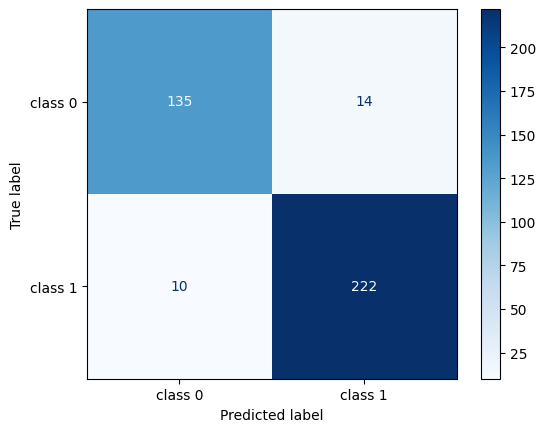

In [61]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters={
    'C':np.logspace(-3,3,20),
    'penalty':["l1","l2","elasticnet"],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
rlrs=RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=42,
    scoring='f1_macro'
)
# fit on the trainning dataset
rlrs.fit(df_X_train_stand,y_train)
tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)
print("tuned hpyerparameters :(best parameters) ",rlrs.best_params_)
print("Score:",rlrs.best_score_)
y_predrlrs = rlrs.predict(df_X_test_stand)
#performance results
print(classification_report(y_test, y_predrlrs, target_names=target_names))

cm = confusion_matrix(y_test, y_predrlrs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [62]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_predrlrs
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]


R_totales = pd.DataFrame()
R_aciertos =pd.DataFrame()
R_errores=  pd.DataFrame()

val='Primero'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")


Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Primero, dtype: int64
Aciertos de Predicción:
 0    135
4    209
5      5
1      3
3      4
2      1
Name: Primero, dtype: int64
Errores de Predicción:
 3     4
0    14
4     6
Name: Primero, dtype: int64
Total Correctas: 357, Total Errores: 24


In [63]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_predrlrs))

El coeficiente de correlacion de Matthews es de  0.8673135354249291


#### Importancia de características con regresión logística

Usando `LogisticRegression`, es posible obtener la importancia de las características a partir de los **coeficientes del modelo entrenado**, accesibles mediante `rlrs.best_estimator_.coef_`.

A continuación se grafican las características ordenadas de mayor a menor según su **impacto absoluto** sobre la variable objetivo:

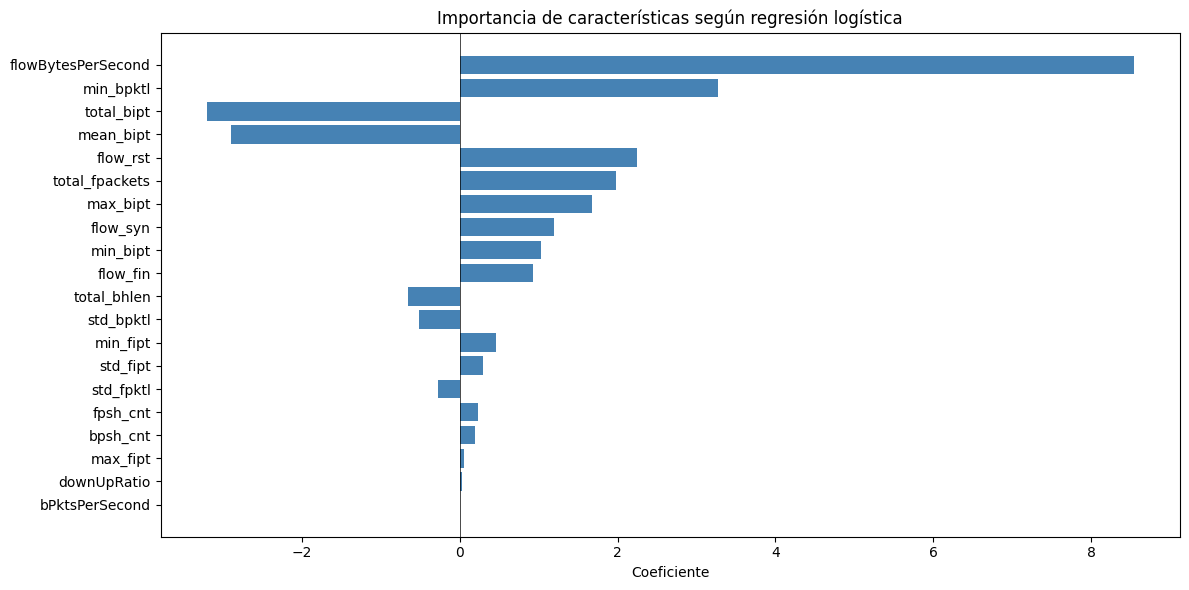

In [64]:
# Obtener los coeficientes del mejor modelo (para clasificación binaria)
best_model = rlrs.best_estimator_
coef = best_model.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': df_X_train_stand.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

#### Curvas de aprendizaje para diagnóstico de generalización

Las curvas de aprendizaje muestran cómo varía el rendimiento del modelo a medida que aumenta el tamaño del conjunto de entrenamiento. Esta visualización ayuda a identificar si el modelo sufre de **overfitting** (alto rendimiento en entrenamiento pero bajo en validación) o **underfitting** (bajo rendimiento en ambos).

A continuación se grafica la curva de aprendizaje para el mejor modelo obtenido con `LogisticRegression`:


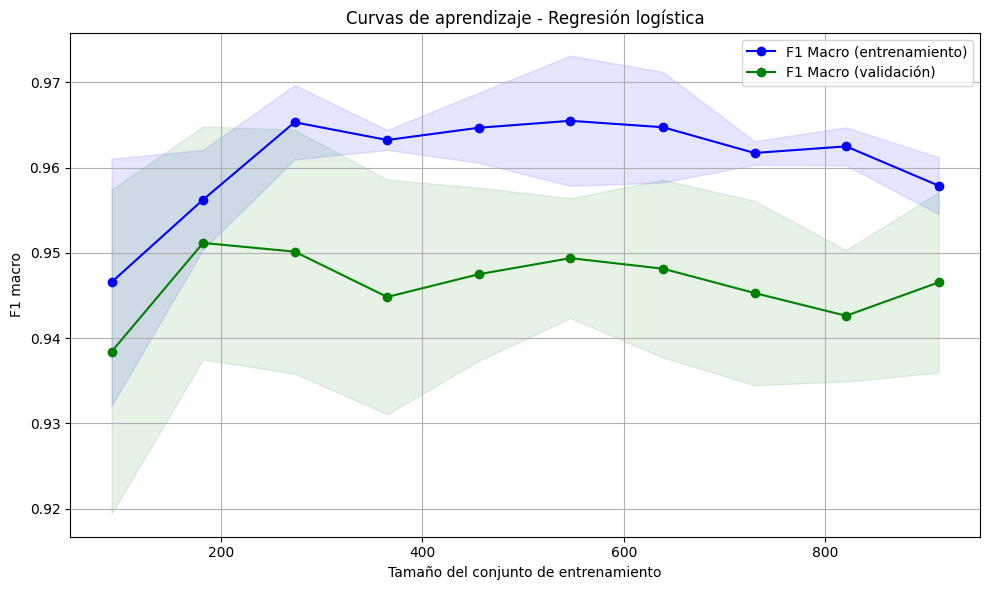

In [65]:
from sklearn.model_selection import learning_curve

# Configurar el modelo con los mejores parámetros encontrados
modelo_final = LogisticRegression(**rlrs.best_params_, random_state=42, max_iter=1000)

# Calcular las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_final,
    X=df_X_train_stand,
    y=y_train,
    cv=5,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Promedios y desviaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="F1 Macro (entrenamiento)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="F1 Macro (validación)")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 macro")
plt.title("Curvas de aprendizaje - Regresión logística")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


#### Curva de entrenamiento (F1 macro - azul)
- Comienza muy alta (casi 0.99) con pocas muestras.
- Disminuye gradualmente hasta estabilizarse alrededor de 0.96 cuando se utilizan conjuntos de entrenamiento más grandes.
- Este descenso es normal: con pocos datos, el modelo puede sobreajustar fácilmente; a medida que el conjunto crece, el modelo generaliza más y la puntuación baja ligeramente.

#### Curva de validación (F1 macro - verde)
- Se mantiene bastante estable entre 0.945 y 0.955 a lo largo de los distintos tamaños de muestra.
- Esta estabilidad indica que el modelo no mejora significativamente su rendimiento con más datos, al menos en este rango.

#### Diagnóstico
- **La brecha entre las curvas es pequeña (~0.01),** lo que indica **baja varianza**. Es decir, el modelo no está sobreajustando.
- Como ambas curvas se estabilizan sin una brecha grande y sin tendencia ascendente en la curva de validación, se interpreta que el modelo **ya ha alcanzado su capacidad máxima de generalización** con los datos disponibles.
- No hay indicios de subajuste: la curva de validación no es baja ni plana en niveles muy inferiores.

#### Conclusión
- El modelo generaliza bien con los datos actuales.
- No parece necesario añadir más datos.
- El desempeño es alto y estable, lo que sugiere un buen ajuste.


### 2.- RL con GridSearchCV y RFE
#### Seleccion de caracteristicas con RFE

#### Grid Search and Recursive Feature Elimination

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 5.16 min.
              precision    recall  f1-score   support

     class 0       0.92      0.94      0.93       149
     class 1       0.96      0.94      0.95       232

    accuracy                           0.94       381
   macro avg       0.94      0.94      0.94       381
weighted avg       0.94      0.94      0.94       381



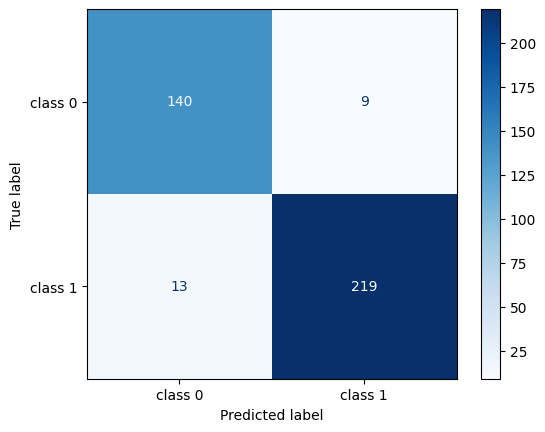

In [66]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
estimator = LogisticRegression(class_weight='balanced', solver='saga',max_iter=5000)

# Inicializar el selector RFECV
selector = RFECV(estimator, step=0.1, cv=5, scoring='f1_macro', n_jobs=-1)

# Definir el espacio de búsqueda de parámetros para Randomized Search
parameters = {
    'estimator__C': np.logspace(-3, 3, 15),  # Hiperparámetro de regularización para la regresión logística
    'estimator__penalty': ["l1", "l2"],  # Tipo de penalización para la regresión logística
}

# Inicializar Randomized Search con Cross Validation
rlgs = GridSearchCV(selector, parameters, cv=5, n_jobs=-1, verbose=3,scoring='f1_macro')

# Ajustar Randomized Search a los datos de entrenamiento
rlgs.fit(df_X_train_stand,y_train)

# Obtener el mejor modelo
best_model = rlgs.best_estimator_


tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predrlrsaa = best_model.predict(df_X_test_stand)
#performance results
print(classification_report(y_test, y_predrlrsaa, target_names=target_names))

cm = confusion_matrix(y_test, y_predrlrsaa)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()


#### Extraccion de caracteristicas

In [67]:
# Seleccionar las características en los conjuntos de entrenamiento y prueba utilizando el mejor modelo
X_train_selected = best_model.transform(df_X_train_stand)
X_train_selected=pd.DataFrame(X_train_selected)
X_train_selected.head()


0         1         2         3         4         5         6   \
0 -0.147517 -0.325803 -0.397873 -0.361215 -0.073128 -0.262756 -0.251684   
1 -0.147404 -0.470432 -0.397873 -0.361215 -0.073128 -0.262756 -0.251684   
2  0.680593 -0.398118 -0.346070  0.437534 -0.073128 -0.139928 -0.248158   
3 -0.147291 -0.506589 -0.281839 -0.361211 -0.072859 -0.262706 -0.251534   
4 -0.147404  0.578128 -0.291508 -0.361198 -0.072163 -0.262577 -0.251147   

         7         8         9         10        11        12        13  
0 -0.271013 -0.064876 -0.162318 -0.222596 -0.251703 -0.800532 -0.687161  
1 -0.271013 -0.064878 -0.056353 -0.077031 -0.251703  1.235565  0.876062  
2 -0.265476  0.082937 -0.167509 -0.214882 -0.251703 -0.800532 -0.687161  
3 -0.270752 -0.064874 -0.043418 -0.033928 -0.251703  1.235565  0.876062  
4 -0.271013 -0.064847 -0.125332 -0.132352 -0.251703 -0.800532 -0.687161

In [68]:
# Recuperar los nombres de las características originales
feature_names = df_X_train_stand.columns

# Recuperar los índices de las características seleccionadas
selected_feature_indices = [i for i, selected in enumerate(best_model.support_) if selected]

# Recuperar los nombres de las características seleccionadas
selected_feature_names = feature_names[selected_feature_indices]


In [69]:
X_train_selected=X_train_selected.set_axis(selected_feature_names, axis=1)

#### VIF RFE

Revisamos la importancia de nuestras features seleccionadas por el metodo RFE

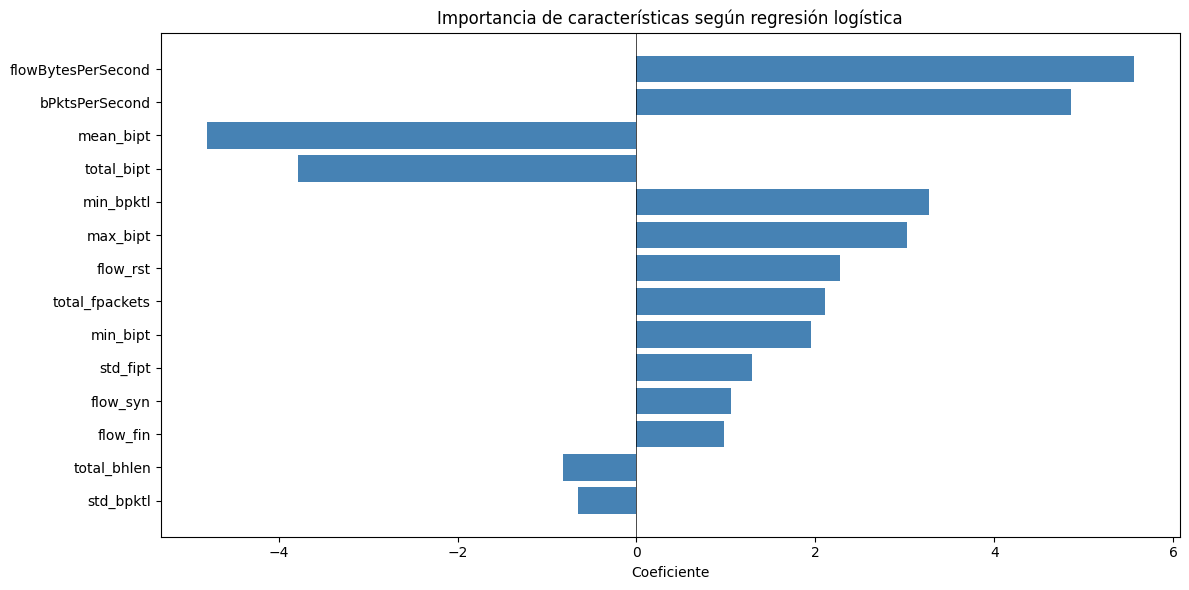

In [70]:
# Acceder al estimador entrenado dentro del RFECV
logreg_model = best_model.estimator_

# Obtener los coeficientes
coef = logreg_model.coef_.flatten()

# Obtener los nombres de las variables seleccionadas
selected_features = df_X_train_stand.columns[best_model.support_]

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': selected_features,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Procedemos a eliminar multicolinealidad (VIF) de nuestras features seleccionadas por el metodo RFE de manera automatica en base a las features con mayor VIF y menor importancia

Eliminando 'bPktsPerSecond' con VIF = 11.51 y coef = 4.8599


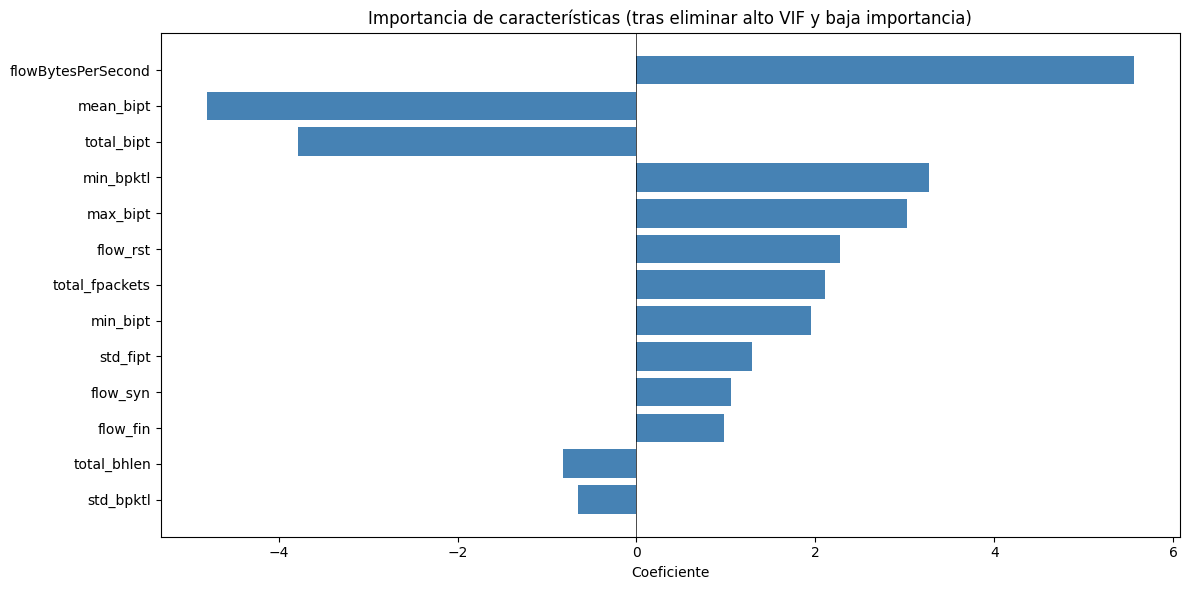

In [71]:
def filtrar_vif_bajo_importancia(X_train_selected, importancia_series, umbral=10.0):
    X = X_train_selected.copy()
    coef_serie = importancia_series.copy()
    eliminadas = []

    while True:
        vif_actual = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )

        variables_con_vif_alto = vif_actual[vif_actual > umbral]
        if variables_con_vif_alto.empty:
            break

        # Buscar la menos importante (menor abs coef)
        candidatas = pd.DataFrame({
            'vif': variables_con_vif_alto,
            'abs_coef': coef_serie[variables_con_vif_alto.index].abs()
        })
        col_a_eliminar = candidatas.sort_values('abs_coef').index[0]

        print(f"Eliminando '{col_a_eliminar}' con VIF = {variables_con_vif_alto[col_a_eliminar]:.2f} y coef = {coef_serie[col_a_eliminar]:.4f}")

        X = X.drop(columns=[col_a_eliminar])
        coef_serie = coef_serie.drop(index=col_a_eliminar)
        eliminadas.append(col_a_eliminar)

    # Construir DataFrame final de VIF
    vif_datarfe = pd.DataFrame()
    vif_datarfe["feature"] = X.columns
    vif_datarfe["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return X, vif_datarfe, eliminadas


# Paso 1: Crear la serie de coeficientes (post RFECV)
importancia_series = pd.Series(coef, index=X_train_selected.columns)

# Paso 2: Ejecutar el filtrado VIF+importancia
X_train_vif_filtrado, vif_datarfe_final, eliminadas = filtrar_vif_bajo_importancia(X_train_selected, importancia_series)

# Paso 3: Filtrar también la serie de importancia
importancia_filtrada = importancia_series.drop(index=eliminadas)

# Paso 4: Crear DataFrame para graficar
importancia_df = pd.DataFrame({
    'feature': importancia_filtrada.index,
    'coef': importancia_filtrada.values,
    'abs_coef': np.abs(importancia_filtrada.values)
}).sort_values('abs_coef', ascending=False)

# Paso 5: Graficar coeficientes
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características (tras eliminar alto VIF y baja importancia)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [72]:
# VIF dataframe
vif_datarfe = pd.DataFrame()
vif_datarfe["feature"] = X_train_vif_filtrado.columns

# calcular VIF de cada característica
vif_datarfe["VIF"] = [variance_inflation_factor(X_train_vif_filtrado.values, i)
    for i in range(len(X_train_vif_filtrado.columns))]

print(vif_datarfe)

               feature       VIF
0       total_fpackets  1.346868
1            min_bpktl  2.284056
2            std_bpktl  2.402104
3           total_bipt  3.150019
4             min_bipt  2.679371
5             max_bipt  3.679891
6            mean_bipt  7.214280
7             std_fipt  1.408779
8          total_bhlen  1.336991
9   flowBytesPerSecond  1.194002
10            flow_fin  2.413657
11            flow_syn  2.646606
12            flow_rst  2.336721


Dado que se redujeron las features volvemos a realizar el preprocesamiento de los datos para descartar datos duplicados.

In [73]:
X_train_vif_filtrado.columns

Index(['total_fpackets', 'min_bpktl', 'std_bpktl', 'total_bipt', 'min_bipt',
       'max_bipt', 'mean_bipt', 'std_fipt', 'total_bhlen',
       'flowBytesPerSecond', 'flow_fin', 'flow_syn', 'flow_rst'],
      dtype='object')

In [74]:
df_train_f.head()

total_fpackets  min_bpktl   std_fpktl   std_bpktl  total_bipt  min_fipt  \
566                3         54   12.165525    8.485281    0.001775  0.000049   
1101           12414         66    1.929235    2.599396  249.888258  0.000001   
1475              62         66   66.915101   34.012259  250.944686  0.049891   
1178             127        464  252.548886   94.760657  900.447701  0.000474   
1009              69        425  301.993882  149.753571  420.229172  0.000083   

      min_bipt   max_fipt   max_bipt  mean_bipt  std_fipt  fpsh_cnt  bpsh_cnt  \
566   0.001775   0.002358   0.001775   0.001775  0.001633         1         0   
1101  0.000007   0.934072   0.934094   0.020348  0.016297         0         0   
1475  0.000000   6.059882   5.000766   3.437598  2.182182         0         0   
1178  0.000290  10.017588  60.034302  33.349915  3.644818         0         0   
1009  0.000000  10.015714  60.034523  20.010914  3.780870         0         0   

      total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
566            52      484.498566        78488.765630         0         2   
1101      2210184       49.146996        21144.427730         0         0   
1475         6264        0.292855           83.202377         0         0   
1178        16442        0.028567           37.137733         0         0   
1009        12841        0.049343           64.827942         0         0   

      flow_rst  downUpRatio  label  Ataque  
566          1     0.588235      1       4  
1101         0     0.989263      0       0  
1475         0     0.717086      0       0  
1178         0     0.915185      0       0  
1009         0     0.887300      0       0

In [75]:
# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_train_vif_filtrado.columns) + ['label','Ataque']

# Crear el nuevo DataFrame con esas columnas
dfrfe = df_train_f[columnas_utiles].copy()

dfrfe=dfrfe.drop(['label','Ataque'],axis=1)
print(dfrfe.shape)
print("NaN, :", df_train_f['label'].isna().sum())


dfrfe.reset_index(drop=True, inplace=True)
df_train_f.reset_index(drop=True, inplace=True)
print(dfrfe.shape)
dfrfe['label1']=df_train_f['label'].astype('int')
dfrfe['Ataque']=df_train_f['Ataque'].astype('int')
print(dfrfe.shape)


print("Duplicados",dfrfe.drop(['label1','Ataque'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dfrfe_cleaned = dfrfe.drop(['label1', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dfrfe_cleaned = dfrfe[~dfrfe_cleaned]
dfrfe=dfrfe_cleaned.copy()


print(dfrfe.drop(['label1','Ataque'],axis=1,inplace=False).duplicated().sum())

print("Dimensiones subconjunto RFE: ", dfrfe.shape)
print("NaN, :", dfrfe['label1'].isna().sum())

#Splitting
X_train_rfe,X_test_rfe,y_trainrfe,y_testrfe = train_test_split(dfrfe.drop(columns=['label1']), dfrfe['label1'], test_size=0.25, random_state=42)
print(X_train_rfe.shape)
X_test_rfe
RFE_train=X_train_rfe['Ataque']
RFE_test=X_test_rfe['Ataque']
print("Antes    X_train_rfe: ", X_train_rfe.shape, "X_test_rfe: ", X_test_rfe.shape)
X_train_rfe=X_train_rfe.drop(['Ataque'],axis=1)
X_test_rfe=X_test_rfe.drop(['Ataque'],axis=1)
print("Despues  X_train_rfe: ", X_train_rfe.shape, "X_test_rfe: ", X_test_rfe.shape)
print("RFE_train: ", RFE_train.shape, "RFE_test: ", RFE_test.shape)

#Estandarizacion
numeric_cols = X_train_rfe.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

labels=list(X_train_rfe.columns.values.tolist())
# fit on the trainning dataset
preprocessor.fit_transform(X_train_rfe)
X_train_rfe = preprocessor.transform(X_train_rfe)
X_test_rfe  = preprocessor.transform(X_test_rfe)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.
X_train_rfe=pd.DataFrame(X_train_rfe,columns=labels)
X_test_rfe=pd.DataFrame(X_test_rfe,columns=labels)



(1523, 13)
NaN, : 0
(1523, 13)
(1523, 15)
Duplicados 0
0
Dimensiones subconjunto RFE:  (1523, 15)
NaN, : 0
(1142, 14)
Antes    X_train_rfe:  (1142, 14) X_test_rfe:  (381, 14)
Despues  X_train_rfe:  (1142, 13) X_test_rfe:  (381, 13)
RFE_train:  (1142,) RFE_test:  (381,)


In [76]:
print("Dimensiones trainrfe: ",X_train_rfe.shape, "y test: ", X_test_rfe.shape)
print(y_trainrfe.shape)
print(y_testrfe.shape)
X_test_rfe.head()


Dimensiones trainrfe:  (1142, 13) y test:  (381, 13)
(1142,)
(381,)


total_fpackets  min_bpktl  std_bpktl  total_bipt  min_bipt  max_bipt  \
0       -0.142782  -0.398118   0.098306    0.428599 -0.073124  0.024211   
1       -0.147517  -0.506589  -0.397873   -0.361215 -0.073128 -0.262756   
2       -0.135004   4.700056  -0.397873    1.271027  0.207984  3.182062   
3       -0.147066  -0.506589   3.605512   -0.360910 -0.070817 -0.261122   
4        6.149997  -0.994712  -0.397873   -0.361215 -0.073128 -0.262756   

   mean_bipt  std_fipt  total_bhlen  flowBytesPerSecond  flow_fin  flow_syn  \
0   0.232095  0.681262    -0.064425           -0.234235 -0.251703 -0.800532   
1  -0.251684 -0.271013    -0.064878            4.224815 -0.251703  0.217516   
2   6.246919  0.598316    -0.064270           -0.234309 -0.251703 -0.800532   
3  -0.248444 -0.265817    -0.064870           -0.198751  4.310910  1.235565   
4  -0.251684 -0.270817    -0.064880            3.257806 -0.251703 -0.800532   

   flow_rst  
0 -0.687161  
1  0.876062  
2 -0.687161  
3 -0.687161  
4 -0.687161

#### Analisis de densidad con RFE

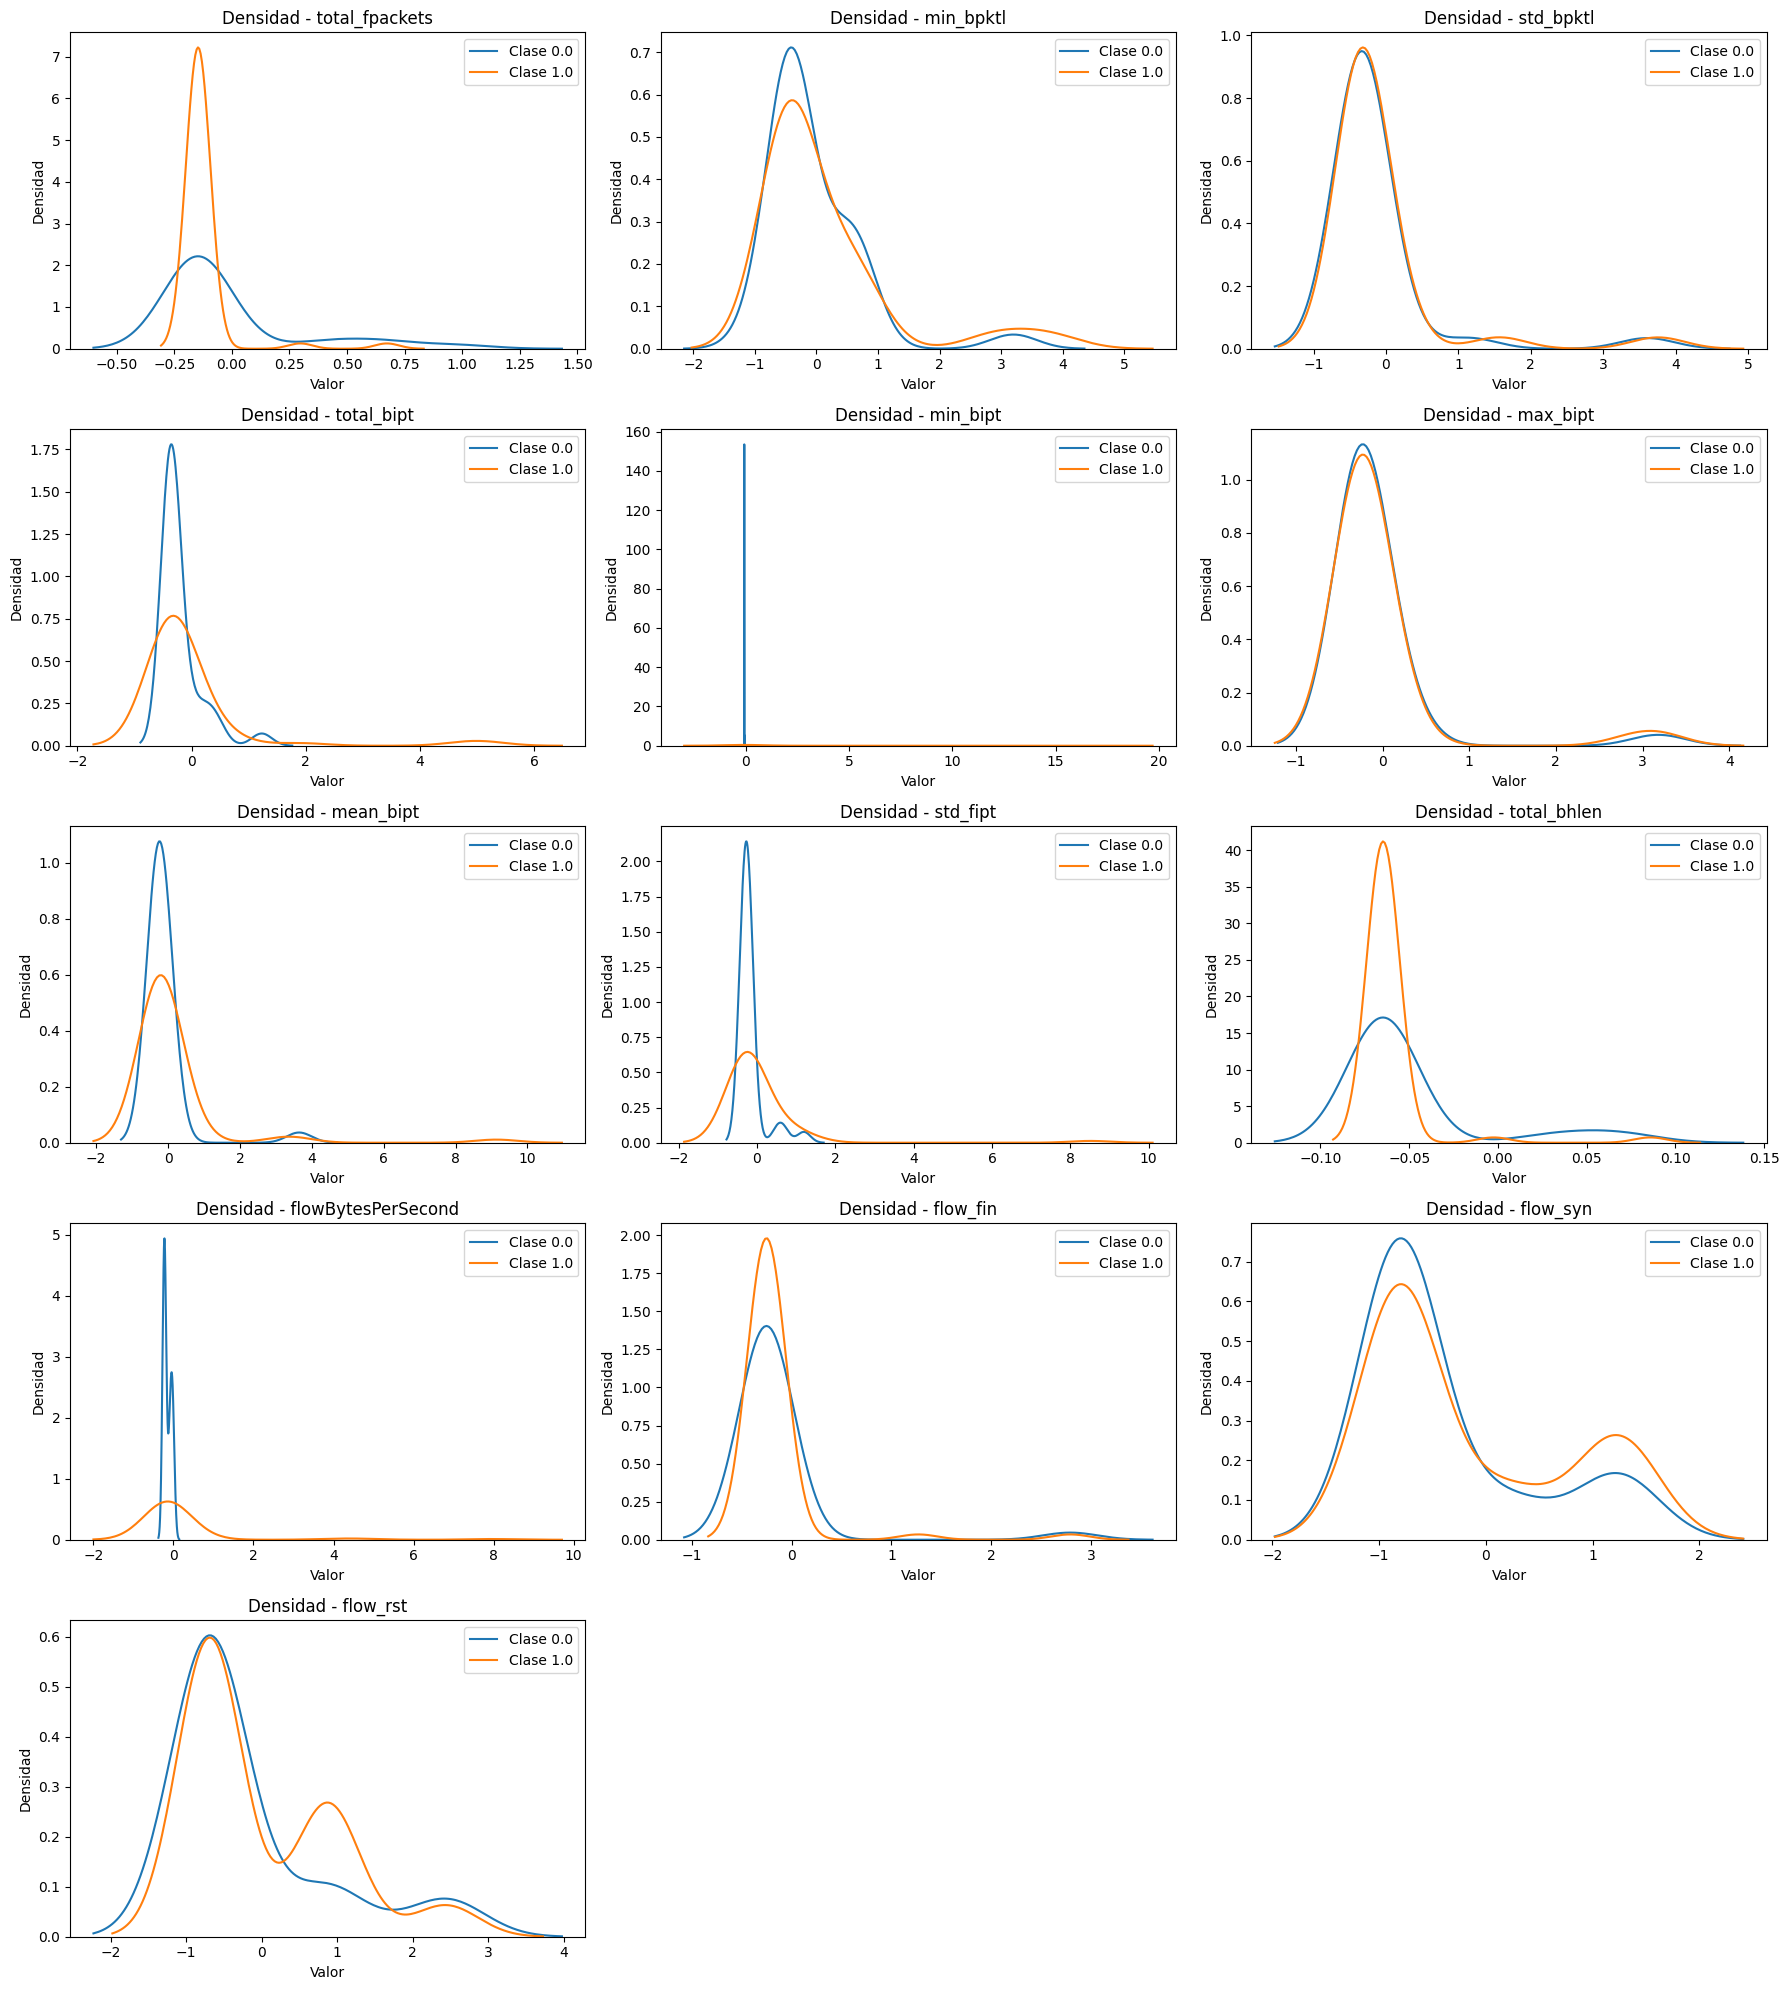

In [77]:
# Alinear índices
y_testrfe_series = pd.Series(y_testrfe, index=X_test_rfe.index)

# Obtener todas las features disponibles
features_to_plot = X_test_rfe.columns
num_features = len(features_to_plot)

# Calcular dinámicamente el layout de subplots (máx. 3 columnas)
cols = 3
rows = math.ceil(num_features / cols)

# Crear figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()  # Asegura indexación lineal

for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in np.unique(y_testrfe_series):
        subset = X_test_rfe.loc[y_testrfe_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar subplots sobrantes
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Entrenando modelo RL con GridSearchCV y RFE

In [78]:
start=perf_counter()

# Entrenar el modelo de regresión logística con las características seleccionadas y los hiperparámetros óptimos
model = LogisticRegression(C=rlgs.best_params_['estimator__C'], penalty=rlgs.best_params_['estimator__penalty'],
                           class_weight='balanced', solver='saga', max_iter=1500)
model.fit(X_train_rfe, y_trainrfe)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Predecir y evaluar el modelo
y_predrlgs = model.predict(X_test_rfe)
accuracy = roc_auc_score(y_testrfe, y_predrlgs)
print("Best Parameters:", rlgs.best_params_)
print("Score:", rlgs.best_score_)

Elapsed time: 0.00 min.
Best Parameters: {'estimator__C': np.float64(7.196856730011514), 'estimator__penalty': 'l2'}
Score: 0.9514353345336055


              precision    recall  f1-score   support

     class 0       0.92      0.94      0.93       149
     class 1       0.96      0.94      0.95       232

    accuracy                           0.94       381
   macro avg       0.94      0.94      0.94       381
weighted avg       0.94      0.94      0.94       381



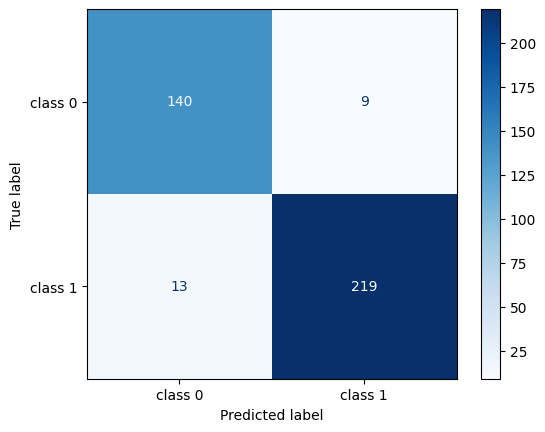

In [79]:
#performance results
print(classification_report(y_testrfe, y_predrlgs, target_names=target_names))

cm = confusion_matrix(y_testrfe, y_predrlgs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

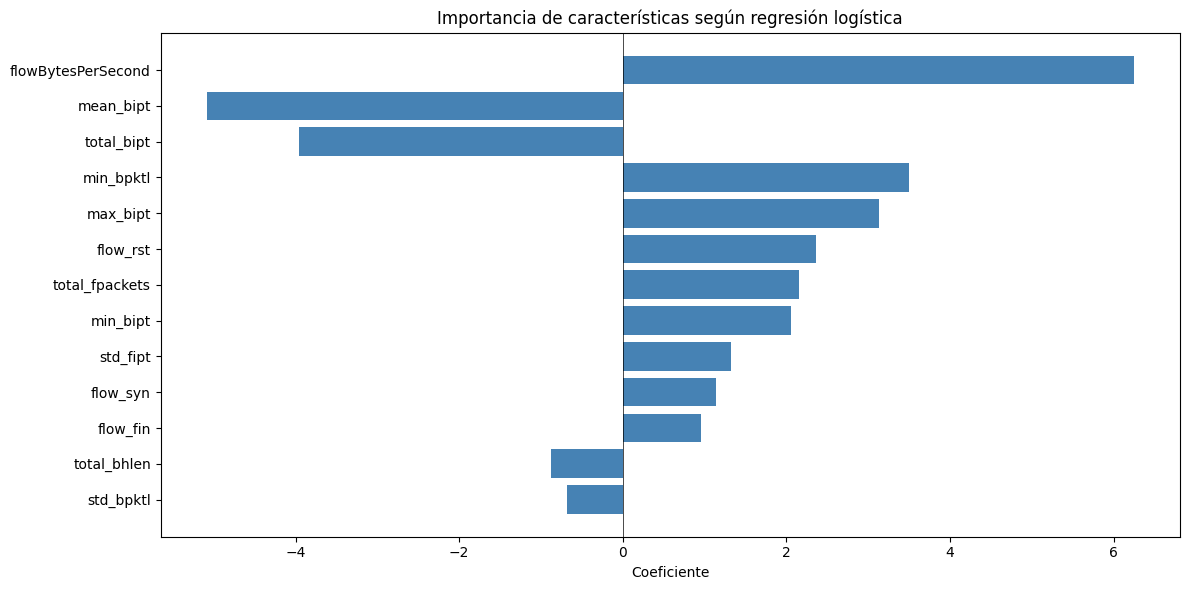

In [80]:
coef = model.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': X_train_rfe.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [81]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predrlgs
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Segundo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")


Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Segundo, dtype: int64
Aciertos de Predicción:
 0    140
4    206
5      5
1      3
3      4
2      1
Name: Segundo, dtype: int64
Errores de Predicción:
 3    4
0    9
4    9
Name: Segundo, dtype: int64
Total Correctas: 359, Total Errores: 22


In [82]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predrlgs))

El coeficiente de correlacion de Matthews es de  0.8795518098811028


### 3.- RL con Optuna sin RFE

In [83]:
start=perf_counter()
# Define la función objetivo
def objective(trial):
    # Define el espacio de búsqueda de hiperparámetros
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform("C", 1e-2, 1000)

    # Crea el modelo con los hiperparámetros sugeridos
    rlo = LogisticRegression(penalty=penalty, C=C, solver='saga',random_state=42)

    # Entrena el modelo
    rlo.fit(df_X_train_stand,y_train)

    # Predice en el conjunto de prueba
    y_predrlo = rlo.predict(df_X_test_stand)

    # Calcula la métrica de rendimiento (recall)
    scoreopsrfe = matthews_corrcoef(y_test, y_predrlo)

    return scoreopsrfe


In [84]:
# Crea el estudio de optimización
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(objective, n_trials=300)

# Obtiene los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrena el modelo con los mejores hiperparámetros encontrados
best_modelrlo = LogisticRegression(**best_params, solver='saga',random_state=42)
best_modelrlo.fit(df_X_train_stand, y_train)

# Predice en el conjunto de prueba

y_predbrlo = best_modelrlo.predict(df_X_test_stand)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Mejores hiperparámetros: {'penalty': 'l2', 'C': 0.01360160843946016}
Elapsed time: 0.12 min.


              precision    recall  f1-score   support

     class 0       0.95      0.92      0.94       149
     class 1       0.95      0.97      0.96       232

    accuracy                           0.95       381
   macro avg       0.95      0.94      0.95       381
weighted avg       0.95      0.95      0.95       381



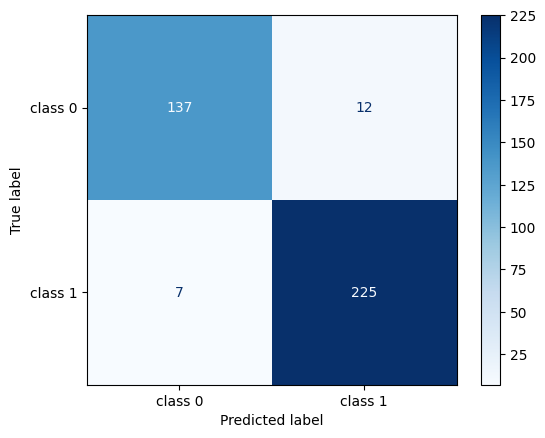

In [85]:
#performance results
print(classification_report(y_test, y_predbrlo, target_names=target_names))

cm = confusion_matrix(y_test, y_predbrlo)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

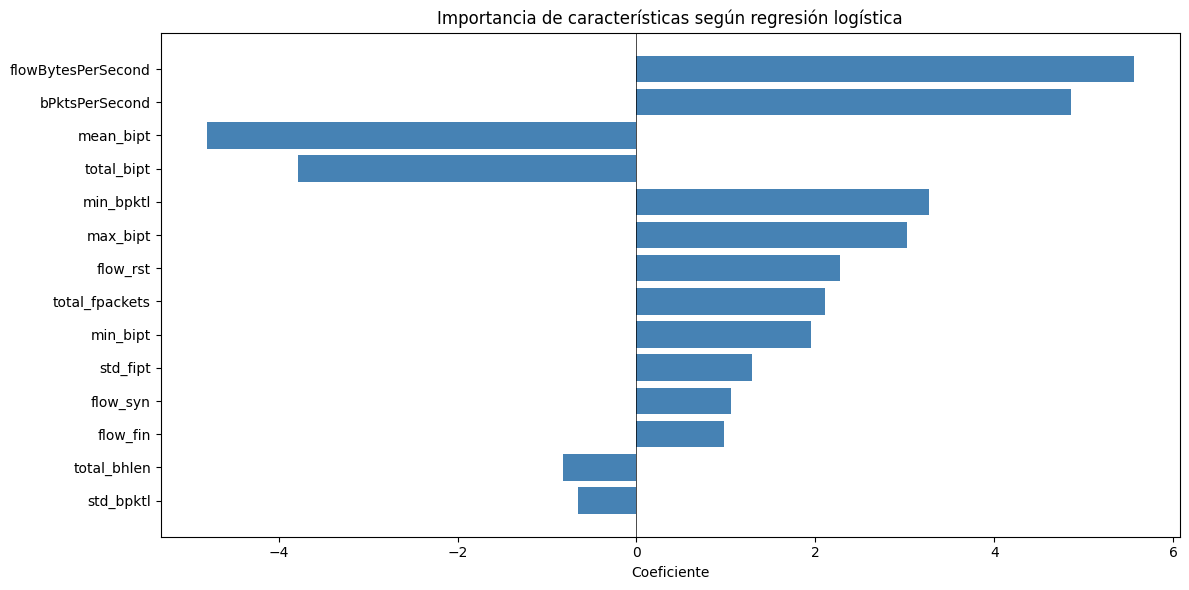

In [86]:
# Obtener coeficientes del estimador dentro de RFECV
coef = best_model.estimator_.coef_.flatten()

# Asociar cada coeficiente con su variable seleccionada
selected_features = df_X_train_stand.columns[best_model.support_]


# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': selected_features,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [87]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_predbrlo
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Tercero'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Tercero, dtype: int64
Aciertos de Predicción:
 0    137
4    211
5      5
1      3
3      5
2      1
Name: Tercero, dtype: int64
Errores de Predicción:
 3     3
0    12
4     4
Name: Tercero, dtype: int64
Total Correctas: 362, Total Errores: 19


In [88]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_predbrlo))

El coeficiente de correlacion de Matthews es de  0.8950049663810039


### 4.- RL con Optuna y RFE

In [89]:
start=perf_counter()
# Define la función objetivo
def objective(trial):
    # Define el espacio de búsqueda de hiperparámetros
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform("C", 1e-3, 100)

    # Crea el modelo con los hiperparámetros sugeridos
    rlo = LogisticRegression(penalty=penalty, C=C, solver='saga',random_state=42)

    # Entrena el modelo
    rlo.fit(X_train_rfe,y_trainrfe)

    # Predice en el conjunto de prueba
    y_predrlorfe = rlo.predict(X_test_rfe)

    # Calcula la métrica de rendimiento (recall)
    scorerfe = matthews_corrcoef(y_testrfe, y_predrlorfe)

    return scorerfe


Mejores hiperparámetros: {'penalty': 'l2', 'C': 0.06789053271698488}
Elapsed time: 0.19 min.
              precision    recall  f1-score   support

     class 0       0.95      0.91      0.93       149
     class 1       0.94      0.97      0.96       232

    accuracy                           0.94       381
   macro avg       0.95      0.94      0.94       381
weighted avg       0.95      0.94      0.94       381



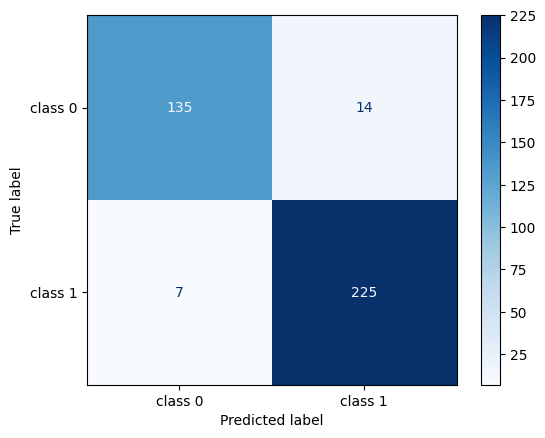

In [90]:
# Crea el estudio de optimización
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
studyrl = optuna.create_study(direction='maximize',sampler=TPESampler(seed=42))
studyrl.optimize(objective, n_trials=500)

# Obtiene los mejores hiperparámetros
best_paramsr = studyrl.best_params
print("Mejores hiperparámetros:", best_paramsr)

# Entrena el modelo con los mejores hiperparámetros encontrados
best_modelrlo = LogisticRegression(**best_paramsr, solver='saga',)
best_modelrlo.fit(X_train_rfe, y_trainrfe)

# Predice en el conjunto de prueba

y_predbrlorfe = best_modelrlo.predict(X_test_rfe)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

#performance results
print(classification_report(y_testrfe, y_predbrlorfe, target_names=target_names))

cm = confusion_matrix(y_testrfe, y_predbrlorfe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

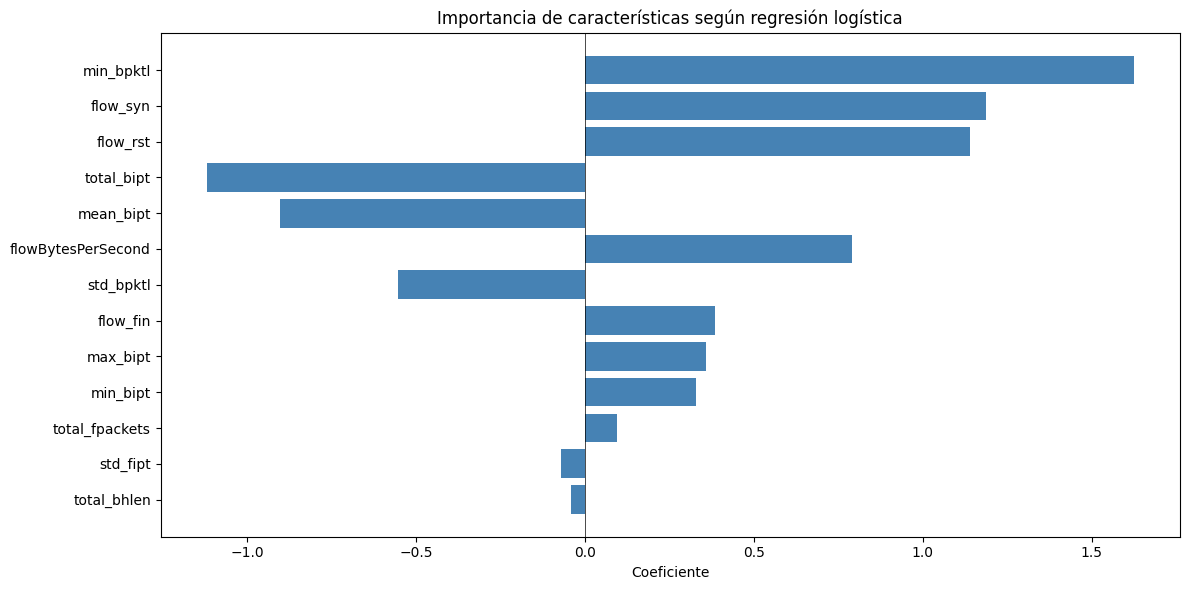

In [91]:
coef = best_modelrlo.coef_.flatten()

# Asociar cada coeficiente con su variable
importancia_df = pd.DataFrame({
    'feature': X_train_rfe.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df['feature'], importancia_df['coef'], color='steelblue')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Coeficiente")
plt.title("Importancia de características según regresión logística")
plt.gca().invert_yaxis()  # Coloca las más importantes arriba
plt.tight_layout()
plt.show()

In [92]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predbrlorfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Cuarto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Cuarto, dtype: int64
Aciertos de Predicción:
 0    135
4    210
5      5
1      3
3      6
2      1
Name: Cuarto, dtype: int64
Errores de Predicción:
 3     2
0    14
4     5
Name: Cuarto, dtype: int64
Total Correctas: 360, Total Errores: 21


In [93]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predbrlorfe))

El coeficiente de correlacion de Matthews es de  0.8839599558114067


## 5 a 7 Decision Tree

### 5.- DT Base

In [94]:
start=perf_counter()

# Defining an object for DTC and fitting for whole dataset
dt = DecisionTreeClassifier(random_state=42)
dt.fit(df_X_train_stand, y_train)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Elapsed time: 0.00 min.


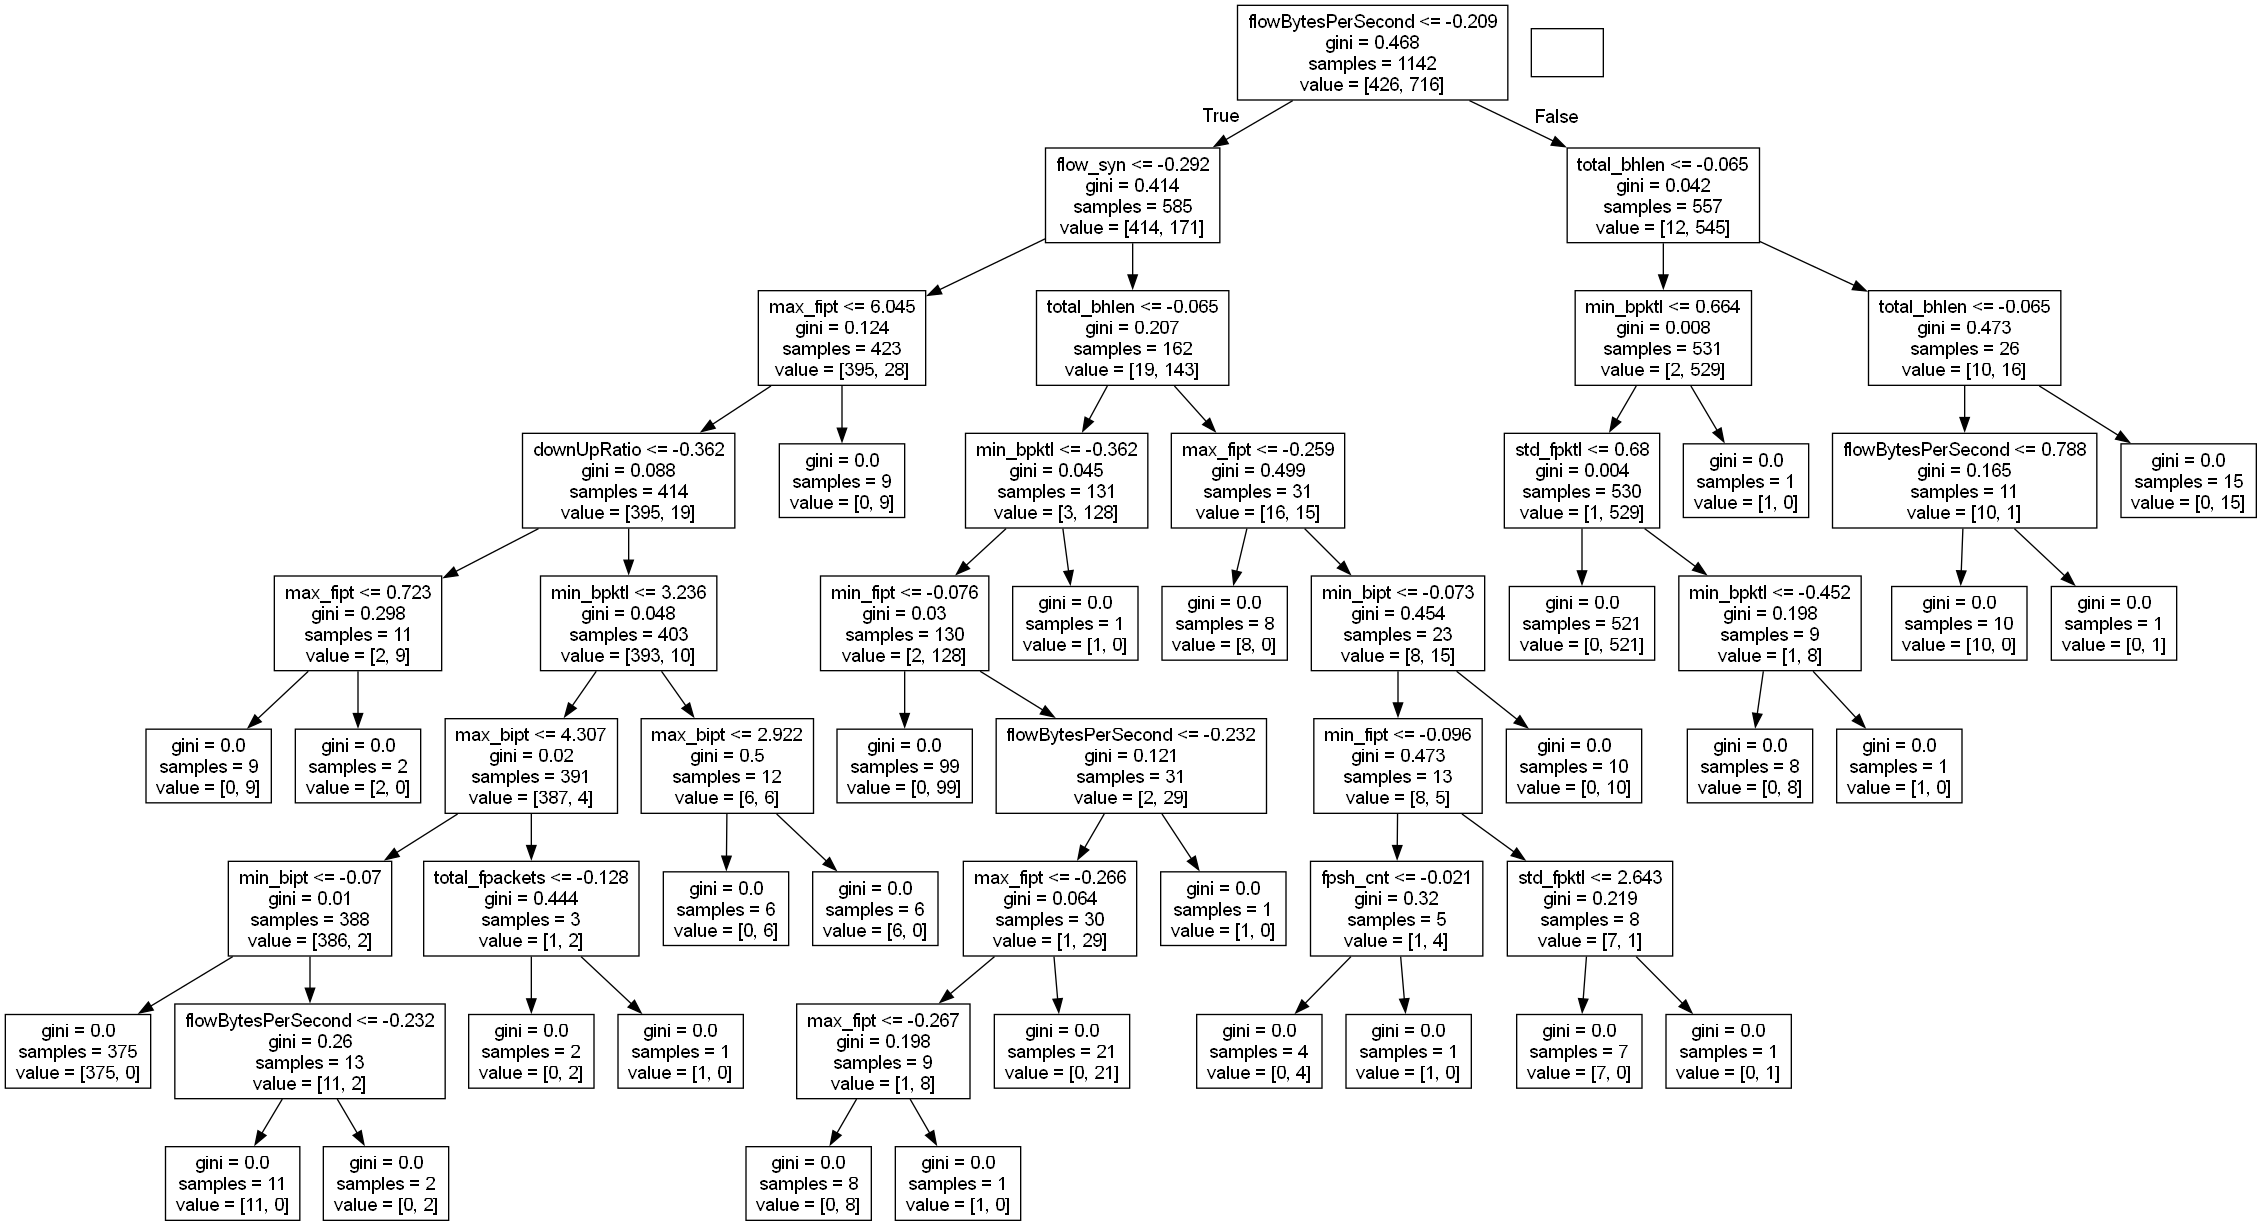

In [95]:
# Conjunto de variables predictoras
X = df_train_f.copy()
X.drop(['label', 'Ataque'],axis=1,inplace=True)

features = X.columns
dot_data = export_graphviz(dt, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [96]:
# Testing model
y_preddt = dt.predict(df_X_test_stand)
y_probdt = dt.predict_proba(df_X_test_stand)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddt, y_test))

Accuracy of Decision Tree-Test:  0.9711286089238845


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       149
           1       0.98      0.97      0.98       232

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



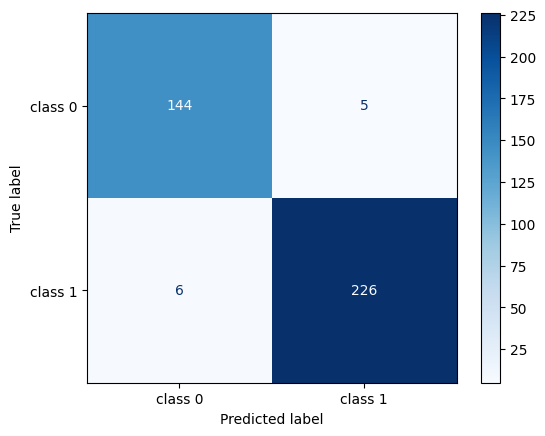

In [97]:
#Classification for test before hyperparameter tuning
print(classification_report(y_test,y_preddt))
ConfusionMatrixDisplay.from_predictions(y_test, y_preddt, display_labels=target_names, cmap=plt.cm.Blues)

In [98]:
df_resultados = pd.DataFrame({
    'Clase': A_test,
    'Real': y_test,
    'Predicción': y_preddt
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Quinto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Quinto, dtype: int64
Aciertos de Predicción:
 0    144
4    213
5      5
1      3
3      4
2      1
Name: Quinto, dtype: int64
Errores de Predicción:
 3    4
0    5
4    2
Name: Quinto, dtype: int64
Total Correctas: 370, Total Errores: 11


In [99]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_test, y_preddt))

El coeficiente de correlacion de Matthews es de  0.9394672719675637


### 6.- DT con Feature Importances
####  Seleccion de Features

Calculamos la `feature_iportances_` obtenida con el modelo anterior

In [100]:
df_X_test_stand.columns[:]

Index(['total_fpackets', 'min_bpktl', 'std_fpktl', 'std_bpktl', 'total_bipt',
       'min_fipt', 'min_bipt', 'max_fipt', 'max_bipt', 'mean_bipt', 'std_fipt',
       'fpsh_cnt', 'bpsh_cnt', 'total_bhlen', 'bPktsPerSecond',
       'flowBytesPerSecond', 'flow_fin', 'flow_syn', 'flow_rst',
       'downUpRatio'],
      dtype='object')

In [101]:
feature_importances = dt.feature_importances_
feature_importances = pd.DataFrame([feature_importances], columns=df_X_test_stand.columns[:])


Creamos un duplicado de nuestros conjuntos de entrenamiento y testing

In [102]:
feature_importances


total_fpackets  min_bpktl  std_fpktl  std_bpktl  total_bipt  min_fipt  \
0        0.002496   0.021109   0.003685        0.0         0.0  0.005617   

   min_bipt  max_fipt  max_bipt  mean_bipt  std_fipt  fpsh_cnt  bpsh_cnt  \
0  0.009127   0.04922   0.01611        0.0       0.0  0.002995       0.0   

   total_bhlen  bPktsPerSecond  flowBytesPerSecond  flow_fin  flow_syn  \
0      0.05593             0.0            0.516075       0.0  0.292401   

   flow_rst  downUpRatio  
0       0.0     0.025234

Ordenamos por importancia

In [103]:
feature_importances_transposed = feature_importances.transpose()

# Renombrar la columna
feature_importances_transposed.columns = ['importance']

# Ordenar las características de mayor a menor importancia
sorted_features = feature_importances_transposed.sort_values(by='importance', ascending=False)

sorted_features=sorted_features.transpose()
sorted_features

flowBytesPerSecond  flow_syn  total_bhlen  max_fipt  downUpRatio  \
importance            0.516075  0.292401      0.05593   0.04922     0.025234   

            min_bpktl  max_bipt  min_bipt  min_fipt  std_fpktl  fpsh_cnt  \
importance   0.021109   0.01611  0.009127  0.005617   0.003685  0.002995   

            total_fpackets  std_bpktl  std_fipt  total_bipt  mean_bipt  \
importance        0.002496        0.0       0.0         0.0        0.0   

            bPktsPerSecond  bpsh_cnt  flow_fin  flow_rst  
importance             0.0       0.0       0.0       0.0

Aplicamos el siguiente ciclo for para eliminar las columnas con una importancia de 0

In [104]:
Xfitrain = pd.DataFrame()
Xfitest  = pd.DataFrame()
fidt     = pd.DataFrame()
dffi     = pd.DataFrame()

ncol=feature_importances.shape[1]

for i in range(0, ncol):
    if(feature_importances.at[0,feature_importances.columns[i]]>0.01):
        Xfitrain[feature_importances.columns[i]]= df_X_train_stand[feature_importances.columns[i]]
        Xfitest[feature_importances.columns[i]]= df_X_test_stand[feature_importances.columns[i]]
        dffi[feature_importances.columns[i]]= df_train_f[feature_importances.columns[i]]
        fidt[feature_importances.columns[i]] = feature_importances[feature_importances.columns[i]]

print(feature_importances.shape)
fidt

(1, 20)


min_bpktl  max_fipt  max_bipt  total_bhlen  flowBytesPerSecond  flow_syn  \
0   0.021109   0.04922   0.01611      0.05593            0.516075  0.292401   

   downUpRatio  
0     0.025234

#### VIF Feature Importance

A las features clasificadas con el metodo `feature_iportances_` le calculamos la multicolinealidad por medio de `VIF`

In [105]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = Xfitrain.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(Xfitrain.values, i)
    for i in range(len(Xfitrain.columns))]

print(vif_data)

              feature       VIF
0           min_bpktl  1.825341
1            max_fipt  1.574290
2            max_bipt  1.849790
3         total_bhlen  1.236083
4  flowBytesPerSecond  1.012365
5            flow_syn  1.192102
6         downUpRatio  1.014028


Observamos niveles altos de multicolinealidad, procedemos a eliminar de manera automatica las features con niveles altos de VIF y bajos niveles de importancia

In [106]:
def filtrar_vif_bajo_importancia_DT(X_train_selected, importancia_series, umbral=10.0):
    X = X_train_selected.copy()
    imp_serie = importancia_series.copy()
    eliminadas = []

    while True:
        vif_actual = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )

        variables_con_vif_alto = vif_actual[vif_actual > umbral]
        if variables_con_vif_alto.empty:
            break

        # Buscar la de menor importancia
        candidatas = pd.DataFrame({
            'vif': variables_con_vif_alto,
            'importance': imp_serie[variables_con_vif_alto.index]
        })
        col_a_eliminar = candidatas.sort_values('importance').index[0]

        print(f"Eliminando '{col_a_eliminar}' con VIF = {variables_con_vif_alto[col_a_eliminar]:.2f} e importancia = {imp_serie[col_a_eliminar]:.4f}")

        X = X.drop(columns=[col_a_eliminar])
        imp_serie = imp_serie.drop(index=col_a_eliminar)
        eliminadas.append(col_a_eliminar)

    # VIF final
    vif_data_final = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    return X, vif_data_final, eliminadas

In [107]:
# Asegurarse de que solo usamos columnas que sí existen en Xfitrain
columnas_validas = [col for col in feature_importances.columns if col in Xfitrain.columns]

# Aplicar solo las columnas válidas
feature_importances_filtradas = feature_importances[columnas_validas]

In [108]:
importancia_series = feature_importances_filtradas.transpose().iloc[:, 0]
X_train_filtrado, vif_datos_final, eliminadas = filtrar_vif_bajo_importancia_DT(Xfitrain[importancia_series.index], importancia_series)


In [109]:
X_train_filtrado.columns

Index(['min_bpktl', 'max_fipt', 'max_bipt', 'total_bhlen',
       'flowBytesPerSecond', 'flow_syn', 'downUpRatio'],
      dtype='object')

In [110]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_filtrado.columns

# calcular VIF de cada característica
vif_data["VIF"] = [variance_inflation_factor(X_train_filtrado.values, i)
    for i in range(len(X_train_filtrado.columns))]

print(vif_data)

              feature       VIF
0           min_bpktl  1.825341
1            max_fipt  1.574290
2            max_bipt  1.849790
3         total_bhlen  1.236083
4  flowBytesPerSecond  1.012365
5            flow_syn  1.192102
6         downUpRatio  1.014028


Reduciendo asi los valores a niveles aceptables de multicolinealidad <5

Dado que se redujeron las features volvemos a realizar el preprocesamiento de los datos para descartar datos duplicados.

#### Creacion de conjunto de datos con feature importance

In [111]:
columnas_utiles = list(X_train_filtrado.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dffi = df_train_f[columnas_utiles].copy()


print(dffi.shape)


dffi.reset_index(drop=True, inplace=True)
df_train_f.reset_index(drop=True, inplace=True)
dffi['label']=df_train_f['label'].astype('int')
print("NaN, :", df_train_f['label'].isna().sum())
print("NaNd, :", dffi['label'].isna().sum())

print(dffi.shape)
dffi['Ataque']=df_train_f['Ataque']
print("Con Ataque ", dffi.shape)


print("Duplicados",dffi.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dffi_cleaned = dffi.drop(['label', 'Ataque'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dffi_cleaned = dffi[~dffi_cleaned]
dffi=dffi_cleaned.copy()

print("Duplicados D",dffi.drop(['label','Ataque'],axis=1,inplace=False).duplicated().sum())


print("Dimensiones suboconjunto Fi: ", dffi.shape)
print("NaN, :", dffi['label'].isna().sum())

#Splitting
X_train_fi,X_test_fi,y_trainfi,y_testfi = train_test_split(dffi.drop(columns=['label']), dffi['label'], test_size=0.25, random_state=42)

print("Antes X_train_fi: ", X_train_fi.shape, "X_test_fi: ", X_test_fi.shape)
FI_train=X_train_fi['Ataque']
X_train_fi=X_train_fi.drop(['Ataque'],axis=1)
FI_test=X_test_fi['Ataque']
X_test_fi=X_test_fi.drop(['Ataque'],axis=1)
print("Despues X_train_fi: ", X_train_fi.shape, "X_test_fi: ", X_test_fi.shape)
print("Con FI_train: ", FI_train.shape, "FI_test: ", FI_test.shape)

#Estandarizacion
numeric_cols = X_train_fi.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

labels=list(X_train_fi.columns.values.tolist())
# fit on the trainning dataset
preprocessor.fit_transform(X_train_fi)
X_train_fi = preprocessor.transform(X_train_fi)
X_test_fi  = preprocessor.transform(X_test_fi)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.
X_train_fi=pd.DataFrame(X_train_fi,columns=labels)
X_test_fi=pd.DataFrame(X_test_fi,columns=labels)


(1523, 8)
NaN, : 0
NaNd, : 0
(1523, 8)
Con Ataque  (1523, 9)
Duplicados 0
Duplicados D 0
Dimensiones suboconjunto Fi:  (1523, 9)
NaN, : 0
Antes X_train_fi:  (1142, 8) X_test_fi:  (381, 8)
Despues X_train_fi:  (1142, 7) X_test_fi:  (381, 7)
Con FI_train:  (1142,) FI_test:  (381,)


In [112]:
print("Subconjunto Recursive Feature Elimination (RFE): ",dfrfe.shape)
print("Subconjunto Feature Importance (FI): ",dffi.shape)

Subconjunto Recursive Feature Elimination (RFE):  (1523, 15)
Subconjunto Feature Importance (FI):  (1523, 9)


In [113]:
print("Nuevas dimensiones conjunto train: ", X_train_fi.shape, "y test: ", X_test_fi.shape)

Nuevas dimensiones conjunto train:  (1142, 7) y test:  (381, 7)


In [114]:
y_trainfi.head()

188     0
1288    1
1100    0
513     1
485     1
Name: label, dtype: int64

#### Analisis de densidad FI

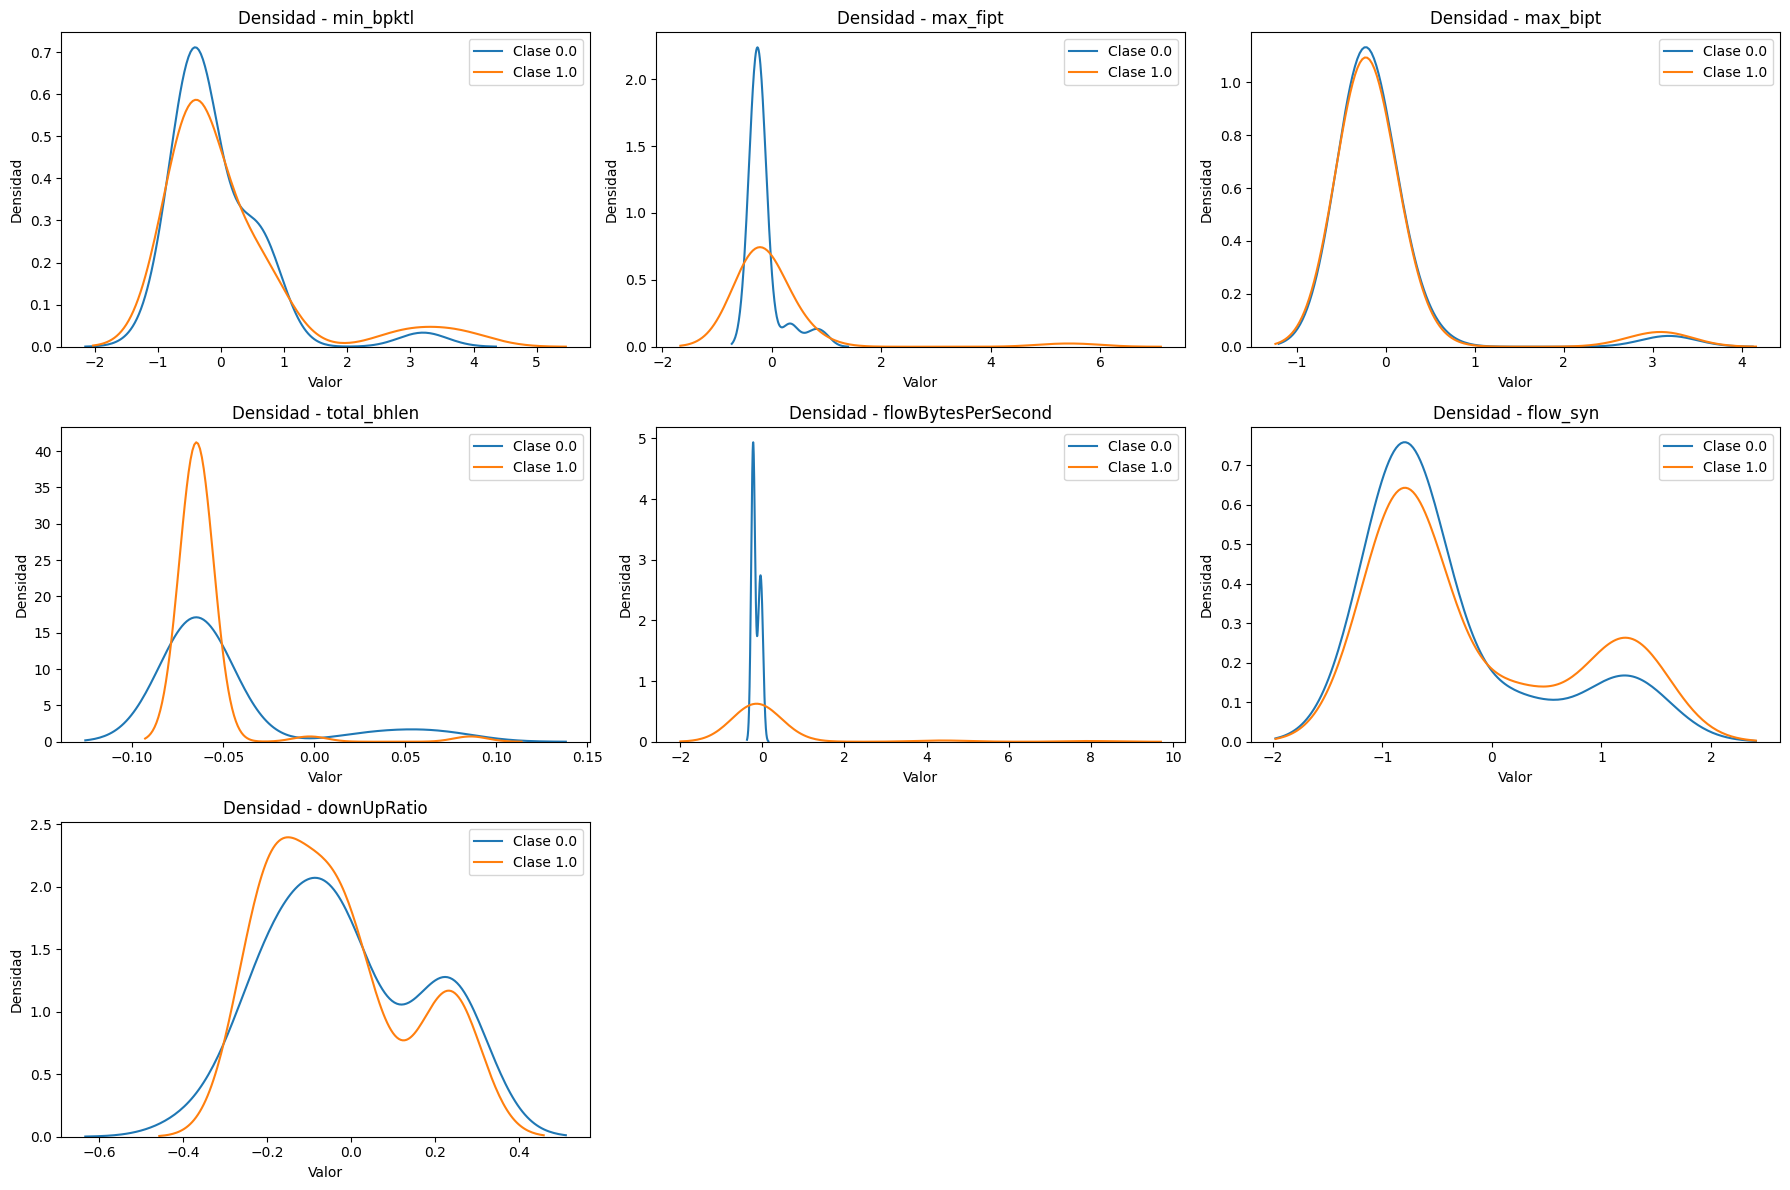

In [115]:
# Alinear índices
y_testfi_series = pd.Series(y_testfi, index=X_test_fi.index)

# Tomar todas las features disponibles
features_to_plot = X_test_fi.columns
num_features = len(features_to_plot)

# Calcular automáticamente filas y columnas (máximo 3 columnas por fila)
cols = 3
rows = math.ceil(num_features / cols)

# Preparar figura
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar
for i, feature in enumerate(features_to_plot):
    ax = axs[i]
    data_ok = False
    for label in np.unique(y_testfi_series):
        subset = X_test_fi.loc[y_testfi_series == label, feature]
        if subset.nunique() > 1 and subset.shape[0] > 1:
            sns.kdeplot(subset, label=f"Clase {label}", ax=ax)
            data_ok = True
        elif subset.shape[0] > 0:
            sns.histplot(subset, label=f"Clase {label}", ax=ax, kde=False, stat='density', element='step')
            data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend()
    else:
        ax.set_visible(False)

# Ocultar subplots vacíos si sobran
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Entrenado modelo con FI

Con esto, volvemos a entrenar el modelo DecisionTree

In [116]:
start=perf_counter()


dtfi = DecisionTreeClassifier(random_state=42)
dtfi.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

Elapsed time: 0.00 min.


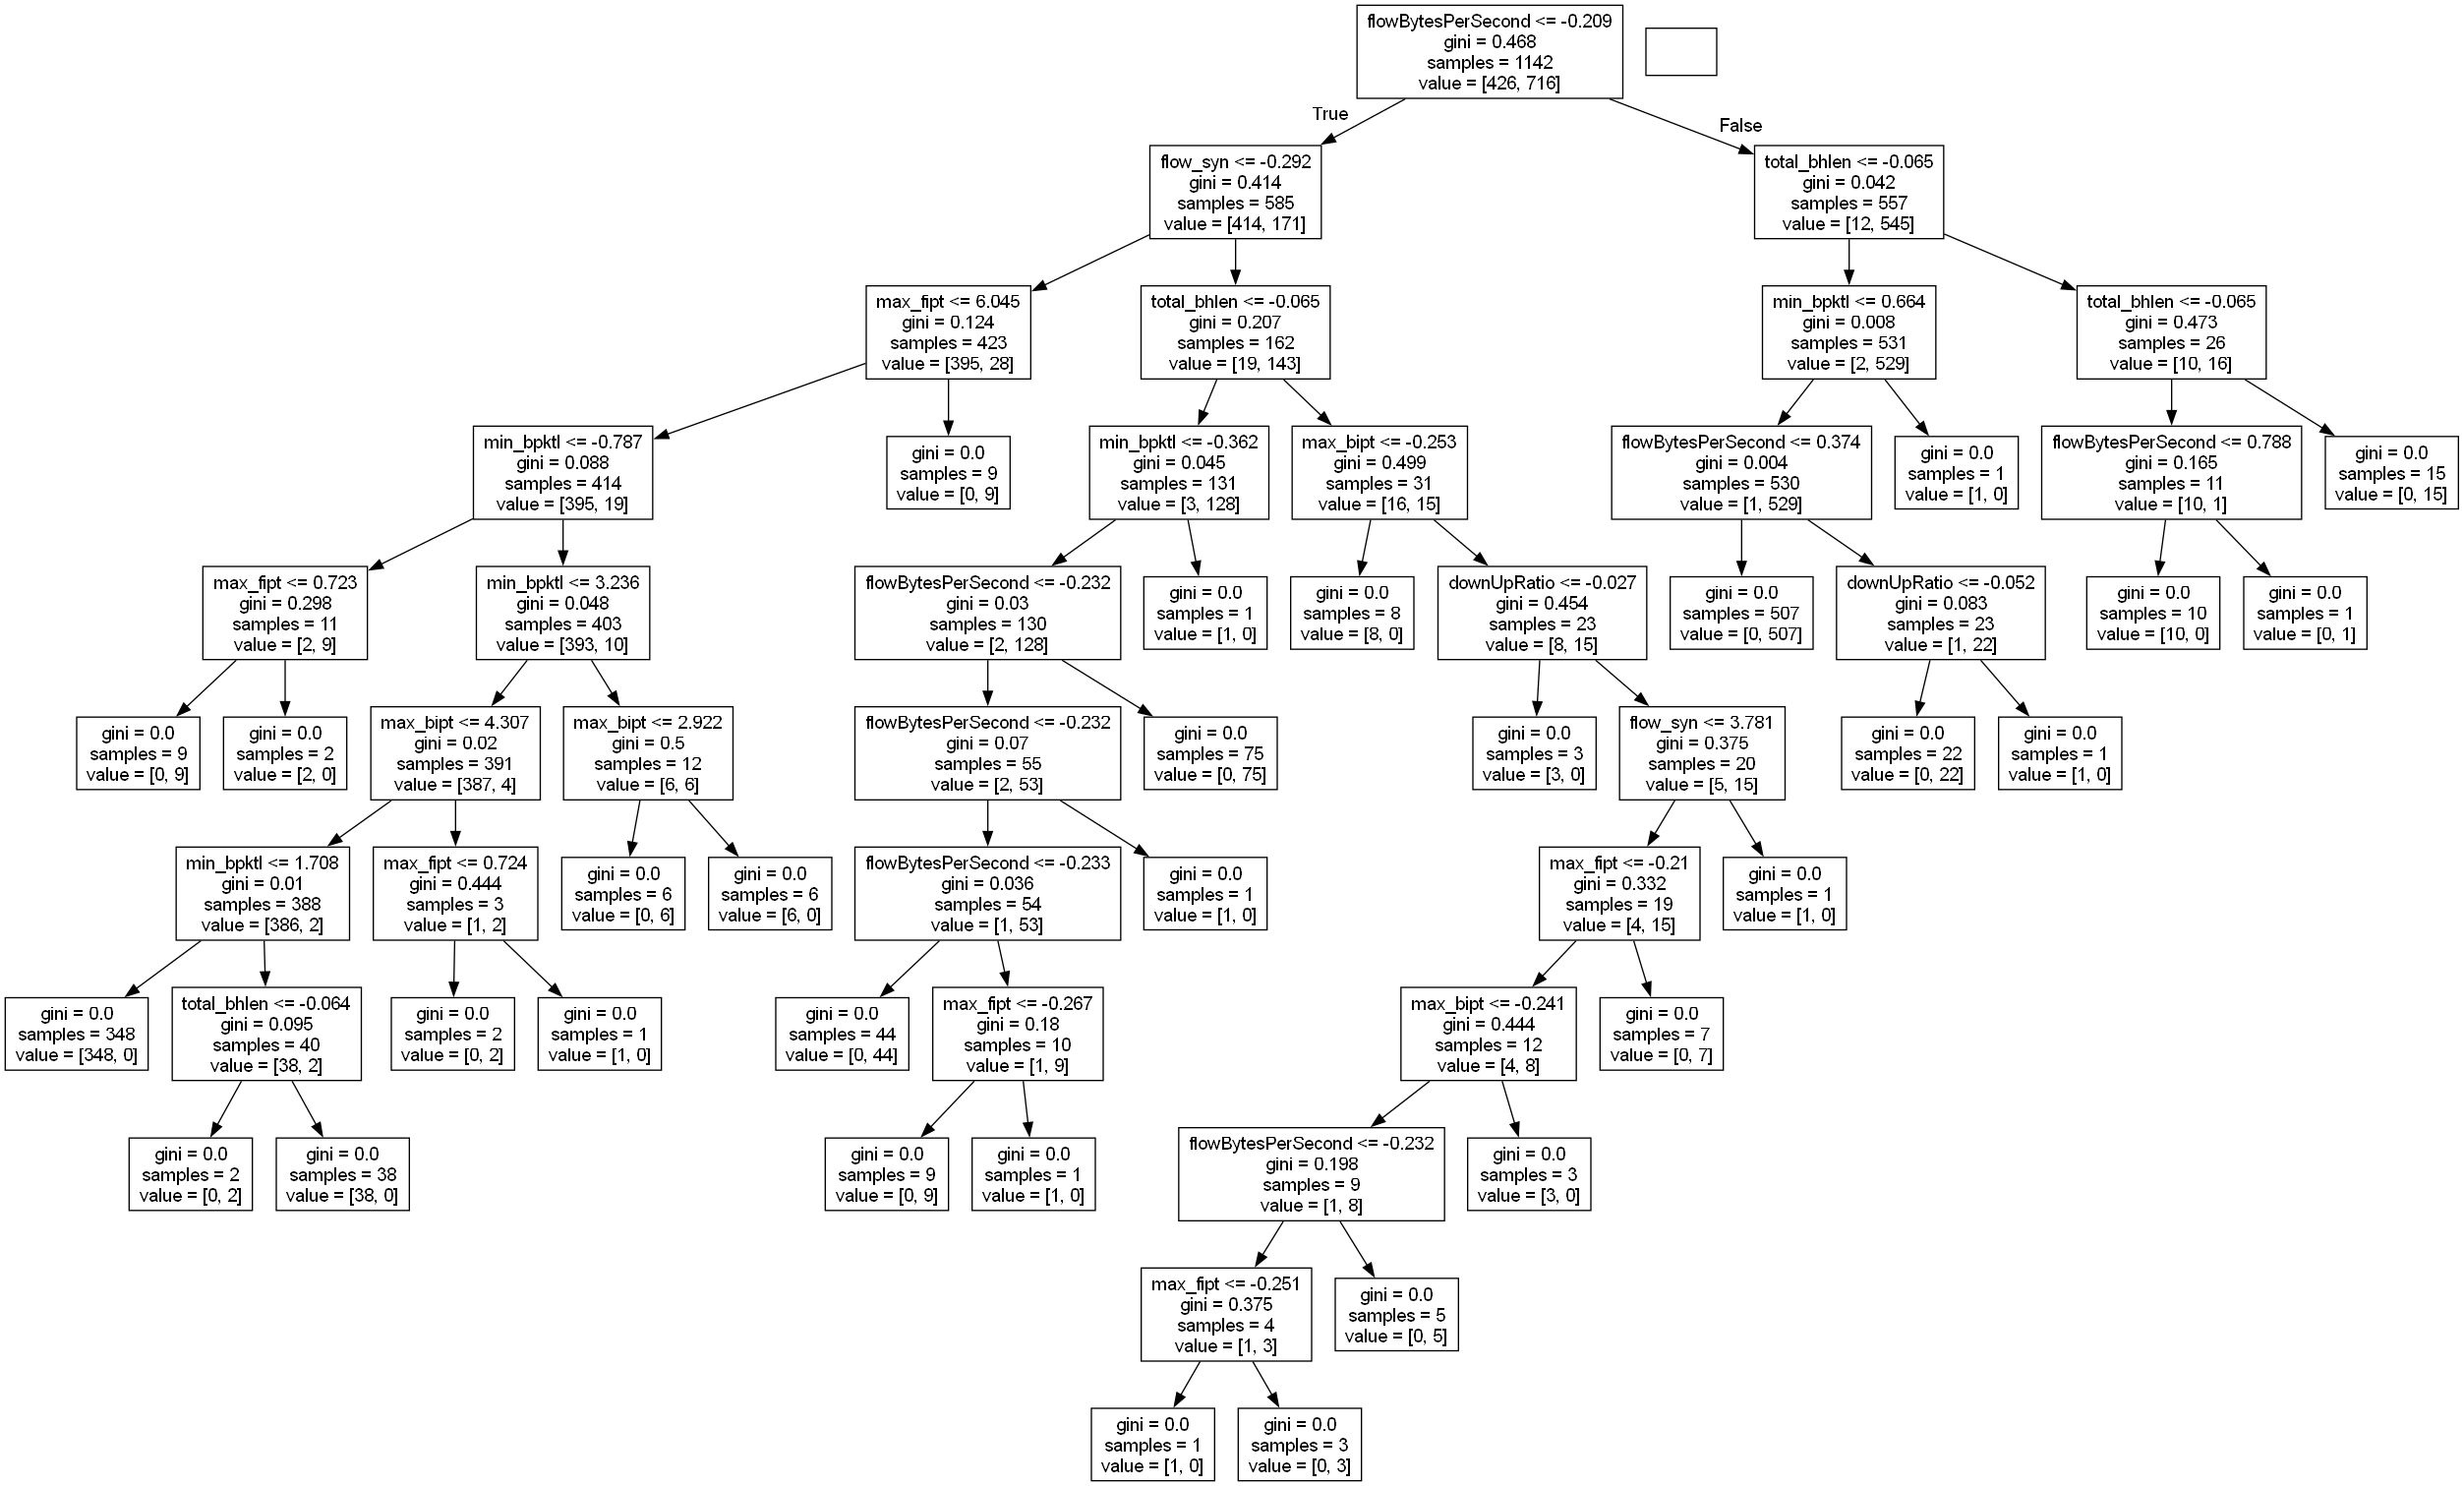

In [117]:
features = X_train_fi.columns
dot_data = export_graphviz(dtfi, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [118]:
# Testing model
y_preddtfi = dtfi.predict(X_test_fi)
y_probdtfi = dtfi.predict_proba(X_test_fi)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddtfi, y_testfi))

Accuracy of Decision Tree-Test:  0.9711286089238845


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       149
           1       0.98      0.97      0.98       232

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



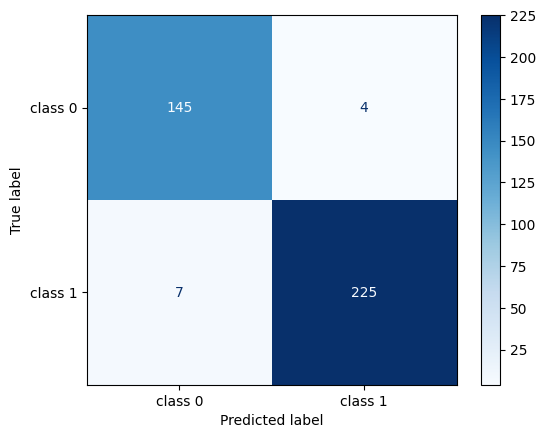

In [119]:
#Classification for test before hyperparameter tuning
print(classification_report(y_testfi,y_preddtfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_preddtfi, display_labels=target_names, cmap=plt.cm.Blues)

In [120]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_preddtfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Sexto'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Sexto, dtype: int64
Aciertos de Predicción:
 0    145
4    212
5      5
1      3
3      4
2      1
Name: Sexto, dtype: int64
Errores de Predicción:
 3    4
0    4
4    3
Name: Sexto, dtype: int64
Total Correctas: 370, Total Errores: 11


In [121]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_preddtfi))

El coeficiente de correlacion de Matthews es de  0.9397254109285552


Con la seleccion de features aumentamos la Accuracy del modelo de **0.9635** a **0.9673**, procedemos a implementar tecnicas de optimizacion de hiperparametros buscando hacer el modelo mas eficiente

### 7.- DT con GridSearchCV y FI

Los hiperparametros que se pueden ajustar en los Arboles de Decision son los siguientes
- min_samples_split – Minimum number of samples a node must possess before splitting.
- min_samples_leaf – Minimum number of samples a leaf node must possess.
- min_weight_fraction_leaf – Minimum fraction of the sum total of weights required to be at a leaf node.
- max_leaf_nodes – Maximum number of leaf nodes a decision tree can have.
- max_features – Maximum number of features that are taken into the account for splitting each node.


In [122]:
# Hyperparameter Tuning of DTC
start=perf_counter()

dtop = DecisionTreeClassifier(class_weight='balanced',random_state=42)

params = {'criterion': ['gini', 'entropy', 'log_loss'],
          'max_depth' : ['None',2,3,4,5],
          'min_samples_split': [2,3,4,5],
          'min_samples_leaf': [1,2,3,4,5],
          'max_leaf_nodes': list(range(2,10))}

gsearchdtop = GridSearchCV(dtop, param_grid=params, n_jobs=-1, cv=5)

gsearchdtop.fit(X_train_fi, y_trainfi)

print("Best Parameters:", gsearchdtop.best_params_)

mdtop = DecisionTreeClassifier(criterion=gsearchdtop.best_params_['criterion'], max_depth=gsearchdtop.best_params_['max_depth'], min_samples_split=gsearchdtop.best_params_['min_samples_split'], min_samples_leaf=gsearchdtop.best_params_['min_samples_leaf'],max_leaf_nodes=gsearchdtop.best_params_['max_leaf_nodes'],
                           class_weight='balanced',random_state=42)
mdtop.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Predecir y evaluar el modelo
y_preddtop = mdtop.predict(X_test_fi)
accuracy = accuracy_score(y_testfi, y_preddtop)
print("Accuracy:", accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Elapsed time: 0.12 min.
Accuracy: 0.952755905511811


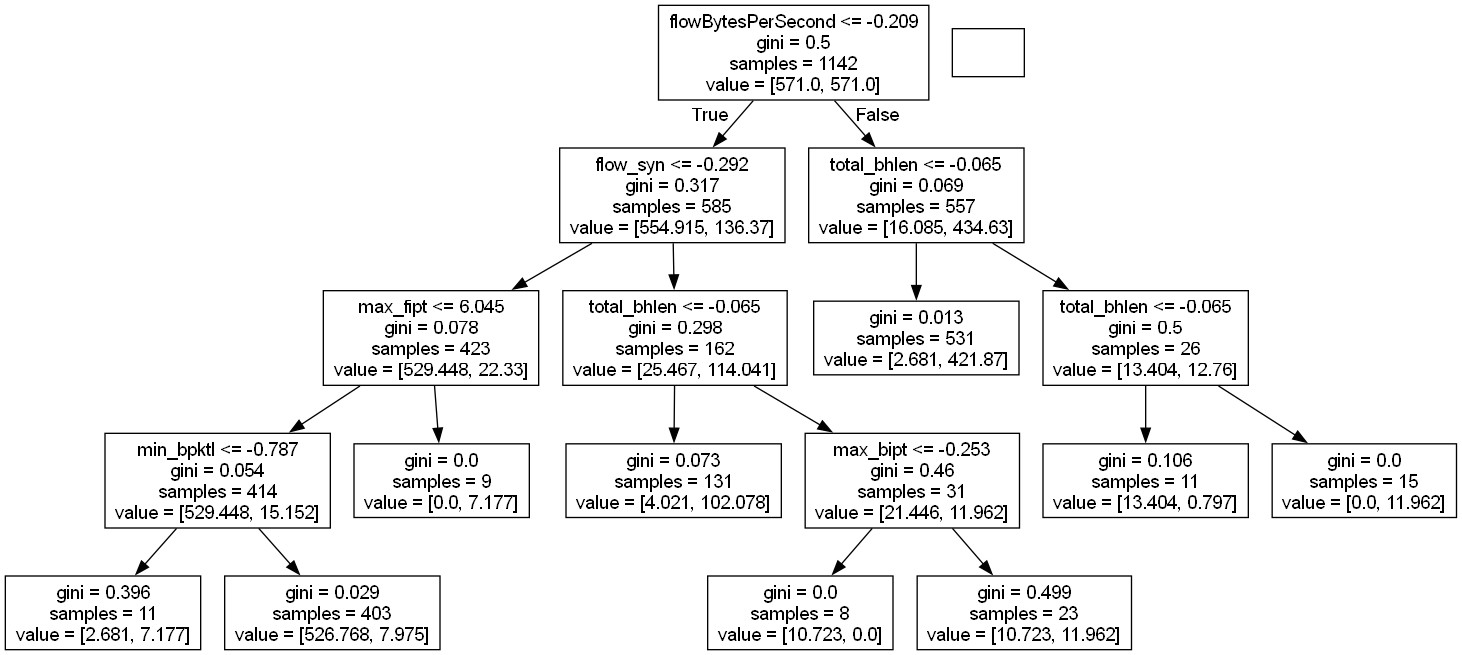

In [123]:
features = X_train_fi.columns
dot_data = export_graphviz(mdtop, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       149
           1       0.97      0.96      0.96       232

    accuracy                           0.95       381
   macro avg       0.95      0.95      0.95       381
weighted avg       0.95      0.95      0.95       381



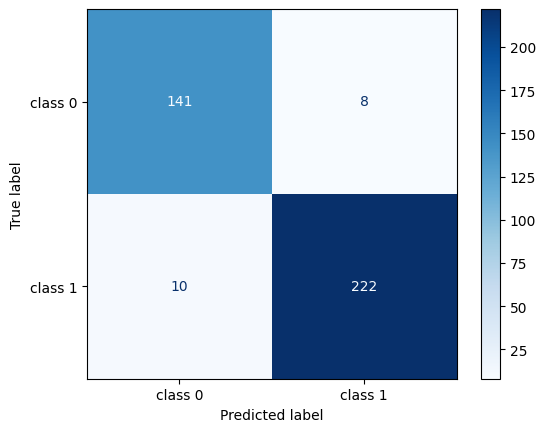

In [124]:
#Classification for test before hyperparameter tuning
print(classification_report(y_testfi,y_preddtop))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_preddtop, display_labels=target_names, cmap=plt.cm.Blues)

In [125]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_preddtop
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Septimo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Septimo, dtype: int64
Aciertos de Predicción:
 0    141
4    213
5      2
1      2
3      4
2      1
Name: Septimo, dtype: int64
Errores de Predicción:
 3    4
0    8
4    2
Name: Septimo, dtype: int64
Total Correctas: 363, Total Errores: 18


In [126]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_preddtop))

El coeficiente de correlacion de Matthews es de  0.9010962889019146


## 8 - 9 XGBoost

### 8.- XGBoost con GridSearch y RFE

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
Elapsed time: 2.39 min.
Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.34), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(8), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(359), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.9789780127173829
Classification Report:
               precision    recall  f1-sco

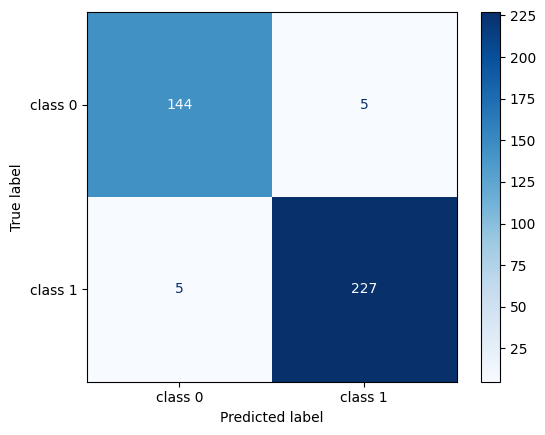

In [127]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
selectxg = XGBClassifier()

# Inicializar el selector RFE

# Definir el espacio de búsqueda de parámetros para Grid Search
parameters = {
    'objective':["binary:logistic","binary:logitraw","binary:hinge"],
    'n_estimators': np.logspace(2, 3, 10).astype(int),
    'max_depth': np.arange(2,10),
    'learning_rate': np.linspace(0.01, 1, 7)
   }

# Inicializar Grid Search con Cross Validation
grid_xgbrfe = GridSearchCV(selectxg, parameters, cv=5, n_jobs=-1, verbose=3)

# Ajustar Grid Search a los datos de entrenamiento
grid_xgbrfe.fit(X_train_rfe, y_trainrfe)

# Obtener el mejor modelo
best_xgbmodelrfe = grid_xgbrfe.best_estimator_


tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)


# Predecir y evaluar el modelo
y_predxgbrfe = grid_xgbrfe.predict(X_test_rfe)
print("Best Parameters:", grid_xgbrfe.best_estimator_)
print("Score:", grid_xgbrfe.best_score_)
print("Classification Report:\n", classification_report(y_testrfe, y_predxgbrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predxgbrfe, display_labels=target_names, cmap=plt.cm.Blues)

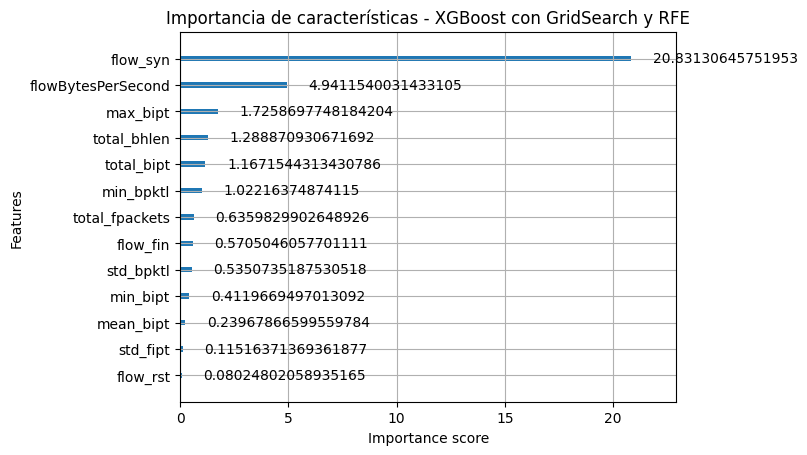

In [128]:
plot_importance(grid_xgbrfe.best_estimator_, importance_type='gain', max_num_features=15)
plt.title("Importancia de características - XGBoost con GridSearch y RFE")
plt.show()

In [129]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predxgbrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Octavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Octavo, dtype: int64
Aciertos de Predicción:
 0    144
4    213
5      5
1      3
3      5
2      1
Name: Octavo, dtype: int64
Errores de Predicción:
 3    3
0    5
4    2
Name: Octavo, dtype: int64
Total Correctas: 371, Total Errores: 10


In [130]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predxgbrfe))

El coeficiente de correlacion de Matthews es de  0.9448912288822032


### 9.- XGBoost con GridSearch y FI

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
Elapsed time: 1.71 min.
Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.505), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(100), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.9763540948440971
Classification Report:
               precision    recall  f1-sc

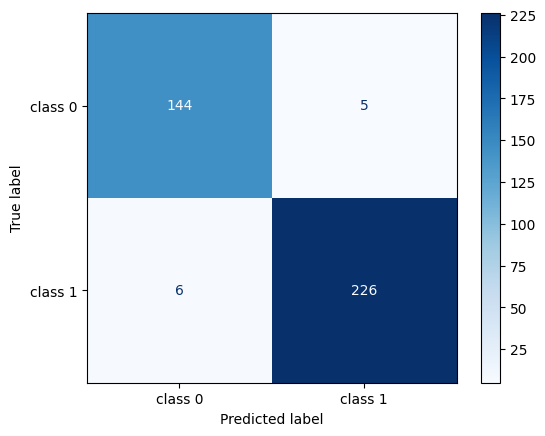

In [131]:
start=perf_counter()
# Definir el estimador base para la regresión logística con selección de características RFE
selectxg = XGBClassifier()

# Inicializar el selector RFE

# Definir el espacio de búsqueda de parámetros para Randomized Search
parameters = {
    'objective':['binary:logistic','binary:logitraw','binary:hinge'],
    'n_estimators': np.logspace(2, 3, 10).astype(int),
    'max_depth': np.arange(2,10),
    'learning_rate': np.linspace(0.01, 1, 7)
   }

# Inicializar Randomized Search con Cross Validation
grid_xgbfi = GridSearchCV(selectxg, parameters, cv=5, n_jobs=-1, verbose=3)

# Ajustar Randomized Search a los datos de entrenamiento
grid_xgbfi.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)


# Obtener el mejor modelo
best_xgbmodelfi = grid_xgbfi.best_estimator_


# Predecir y evaluar el modelo
y_predxgbfi = grid_xgbfi.predict(X_test_fi)
accuracy = accuracy_score(y_testfi, y_predxgbfi)
print("Best Parameters:", best_xgbmodelfi)
print("Score:", grid_xgbfi.best_score_)
print("Classification Report:\n", classification_report(y_testfi, y_predxgbfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predxgbfi, display_labels=target_names, cmap=plt.cm.Blues)

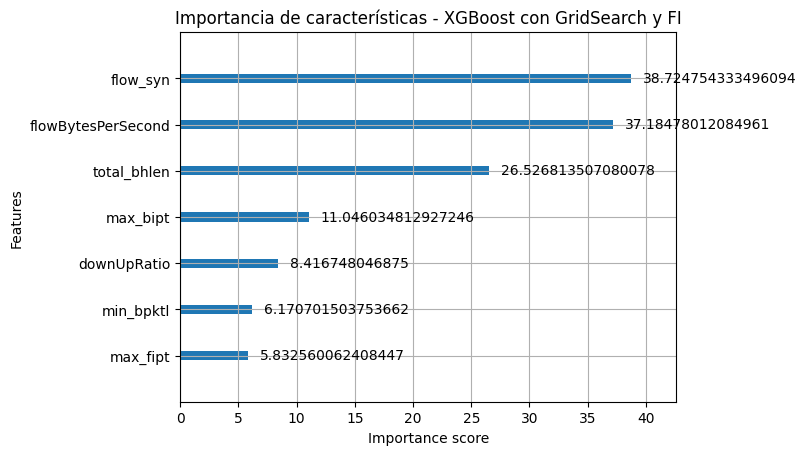

In [132]:
plot_importance(grid_xgbfi.best_estimator_, importance_type='gain', max_num_features=15)
plt.title("Importancia de características - XGBoost con GridSearch y FI")
plt.show()

In [133]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predxgbfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Noveno'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Noveno, dtype: int64
Aciertos de Predicción:
 0    144
4    213
5      5
1      2
3      5
2      1
Name: Noveno, dtype: int64
Errores de Predicción:
 3    3
0    5
4    2
Name: Noveno, dtype: int64
Total Correctas: 370, Total Errores: 11


In [134]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predxgbfi))

El coeficiente de correlacion de Matthews es de  0.9394672719675637


## 10.- Random Forest

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Elapsed time: 0.49 min.
Mejor modelo accuracy score: 0.9711
Mejores parámetros:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': np.int64(340)}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       149
           1       0.98      0.97      0.98       232

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



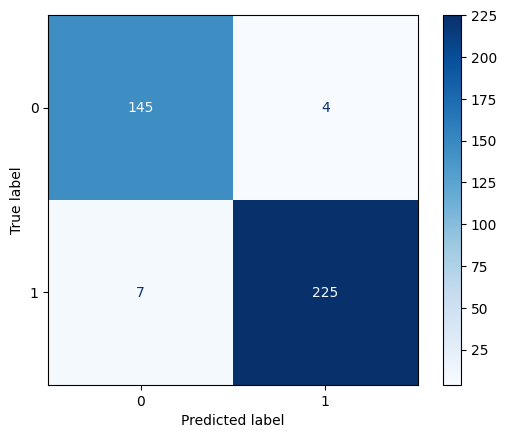

In [135]:

start=perf_counter()

# Define el modelo base a optimizar
clfrf = RandomForestClassifier(random_state=42)

# Define el espacio de búsqueda de parámetros
param_gridrf = {
    'n_estimators': np.linspace(20, 500, 7).astype(int),    # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],               # Número de características a considerar en cada división
    'max_depth' : [4,6,8,10],                               # Máxima profundidad de cada árbol
    'criterion' :['gini', 'entropy']                        # Medidas de calidad de la división
}

# Crear objeto GridSearchCV
grid_searchrf = GridSearchCV(estimator=clfrf, param_grid=param_gridrf, cv=5, verbose=3, n_jobs=-1)

# Entrenarlo
grid_searchrf.fit(X_train_fi, y_trainfi)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

# Mejor modelo encontrado
best_clfrf = grid_searchrf.best_estimator_

# Predicciones con el mejor modelo
y_predrf = best_clfrf.predict(X_test_fi)

# Evaluar el mejor modelo
print('Mejor modelo accuracy score: {0:0.4f}'. format(accuracy_score(y_testfi, y_predrf)))
print("Mejores parámetros: ", grid_searchrf.best_params_)

print("Classification Report:\n", classification_report(y_testfi, y_predrf))

# Print the Confusion Matrix and slice it into four pieces

ConfusionMatrixDisplay.from_predictions(y_testfi, y_predrf, cmap=plt.cm.Blues);

In [136]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predrf
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Decimo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Decimo, dtype: int64
Aciertos de Predicción:
 0    145
4    212
5      5
1      3
3      4
2      1
Name: Decimo, dtype: int64
Errores de Predicción:
 3    4
0    4
4    3
Name: Decimo, dtype: int64
Total Correctas: 370, Total Errores: 11


In [137]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predrf))

El coeficiente de correlacion de Matthews es de  0.9397254109285552


## 11 - 12 Support Vector Machine

### 11.- SVC con RandomizedSearchCV y RFE

In [138]:
start=perf_counter()

svm=LinearSVC(class_weight='balanced', max_iter=10000, dual=False)
# Definir los parámetros para la búsqueda de malla
param_grid = {
    'C': np.logspace(-3, 3, 30)
}
# Realizar la búsqueda de malla con validación cruzada
grid_searchsvmrfe = RandomizedSearchCV(estimator=svm, param_distributions=param_grid,
    n_iter=100,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=42)
grid_searchsvmrfe.fit(X_train_rfe, y_trainrfe)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=LinearSVC(class_weight='balanced', dual=False,
                                       max_iter=10000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
                   random_state=42, scoring='f1_macro', verbose=3)

Best Parameters: {'C': np.float64(2.0433597178569416)}
Elapsed time: 0.00 min.
Accuracy: 0.9422572178477691
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       149
           1       0.96      0.95      0.95       232

    accuracy                           0.94       381
   macro avg       0.94      0.94      0.94       381
weighted avg       0.94      0.94      0.94       381



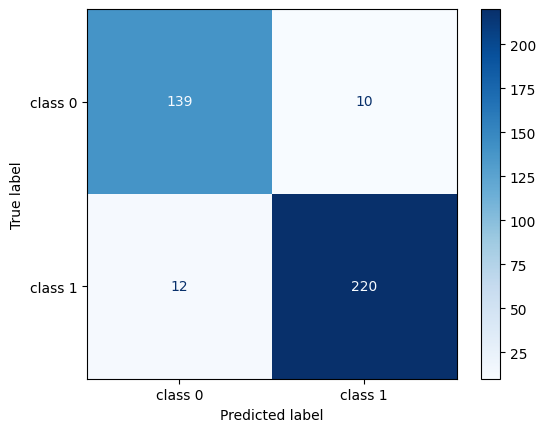

In [139]:
# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_searchsvmrfe.best_params_)
# Usar el mejor modelo encontrado para hacer predicciones
best_modelsvmrfe = grid_searchsvmrfe.best_estimator_

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predsvmrfe = best_modelsvmrfe.predict(X_test_rfe)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testrfe, y_predsvmrfe))
print("Classification Report:\n", classification_report(y_testrfe, y_predsvmrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predsvmrfe, display_labels=target_names, cmap=plt.cm.Blues)

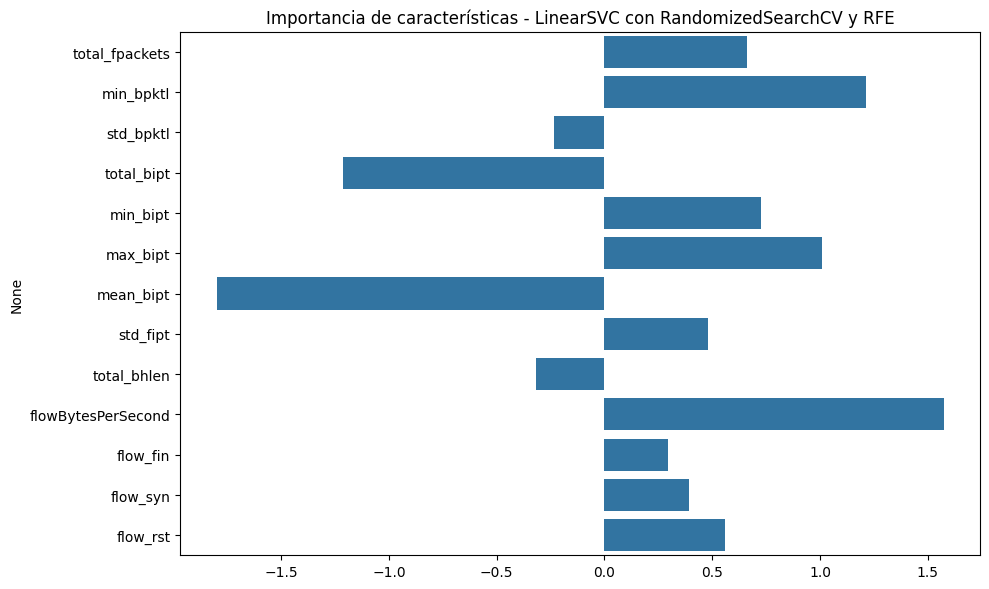

In [140]:
coef = best_modelsvmrfe.coef_.flatten()
plt.figure(figsize=(10, 6))
sns.barplot(x=coef, y=X_test_rfe.columns)
plt.title("Importancia de características - LinearSVC con RandomizedSearchCV y RFE")
plt.tight_layout()
plt.show()

In [141]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predsvmrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Onceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Onceavo, dtype: int64
Aciertos de Predicción:
 0    139
4    206
5      5
1      3
3      5
2      1
Name: Onceavo, dtype: int64
Errores de Predicción:
 3     3
0    10
4     9
Name: Onceavo, dtype: int64
Total Correctas: 359, Total Errores: 22


In [142]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predsvmrfe))

El coeficiente de correlacion de Matthews es de  0.8791042521283813


### 12.- SVC con RandomizedSearchCV y FI

Fitting 6 folds for each of 50 candidates, totalling 300 fits
Best Parameters: {'C': np.float64(0.30888435964774846)}
Elapsed time: 0.01 min.
Accuracy: 0.8503937007874016
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       149
           1       0.94      0.81      0.87       232

    accuracy                           0.85       381
   macro avg       0.85      0.86      0.85       381
weighted avg       0.87      0.85      0.85       381



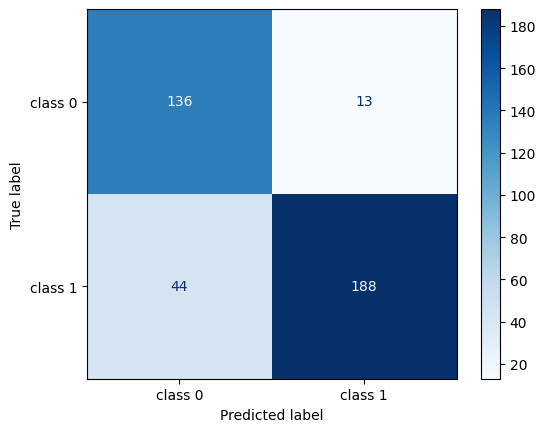

In [143]:
start=perf_counter()

svmda=LinearSVC(class_weight='balanced', max_iter=50000, dual=False)
# Definir los parámetros para la búsqueda de malla
param_grid = {
    'C': np.logspace(-5, 5, 50)
}
# Realizar la búsqueda de malla con validación cruzada
grid_searchsvmdt = RandomizedSearchCV(estimator=svmda, param_distributions=param_grid,
    n_iter=1000,
    scoring='f1_macro',
    n_jobs=-1,
    cv=6,
    verbose=3,
    random_state=42)
grid_searchsvmdt.fit(X_train_fi, y_trainfi)
# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_searchsvmdt.best_params_)
# Usar el mejor modelo encontrado para hacer predicciones
best_modelsvmdt = grid_searchsvmdt.best_estimator_

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

y_predsvmfi = best_modelsvmdt.predict(X_test_fi)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testfi, y_predsvmfi))
print("Classification Report:\n", classification_report(y_testfi, y_predsvmfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predsvmfi, display_labels=target_names, cmap=plt.cm.Blues)


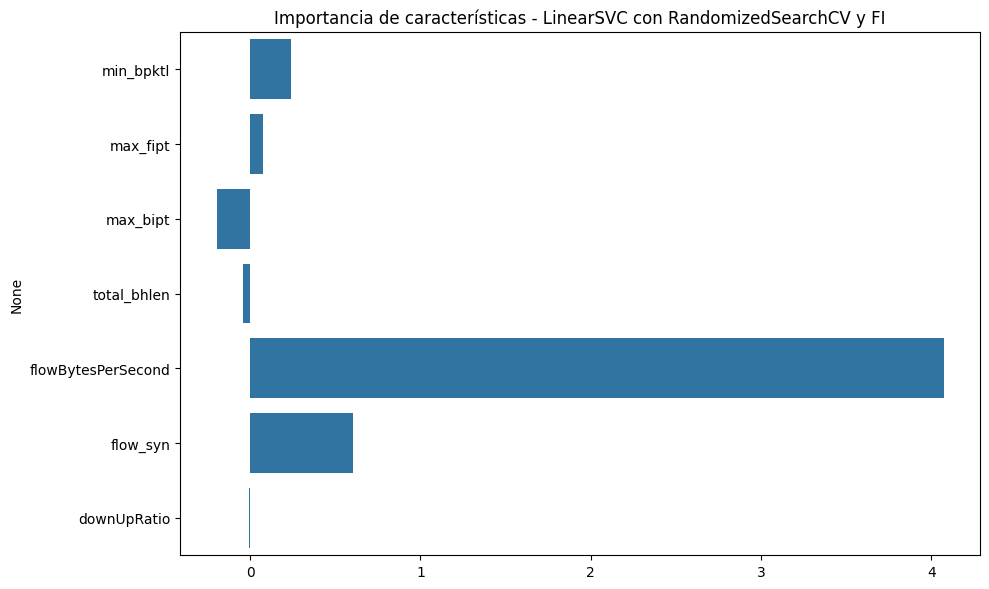

In [144]:
coef = best_modelsvmdt.coef_.flatten()
plt.figure(figsize=(10, 6))
sns.barplot(x=coef, y=X_test_fi.columns)
plt.title("Importancia de características - LinearSVC con RandomizedSearchCV y FI")
plt.tight_layout()
plt.show()

In [145]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predsvmfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Doceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Doceavo, dtype: int64
Aciertos de Predicción:
 0    136
4    179
5      5
1      1
3      2
2      1
Name: Doceavo, dtype: int64
Errores de Predicción:
 3     6
0    13
4    36
Name: Doceavo, dtype: int64
Total Correctas: 324, Total Errores: 57


In [146]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predsvmfi))

El coeficiente de correlacion de Matthews es de  0.7068041781227515


## 13 - 14 Naive Bayes

### 13.- NV con RFE

Accuracy: 0.7532808398950132
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.91      0.74       149
           1       0.92      0.65      0.76       232

    accuracy                           0.75       381
   macro avg       0.77      0.78      0.75       381
weighted avg       0.81      0.75      0.76       381

El coeficiente de correlacion de Matthews es de  0.5554780636604374


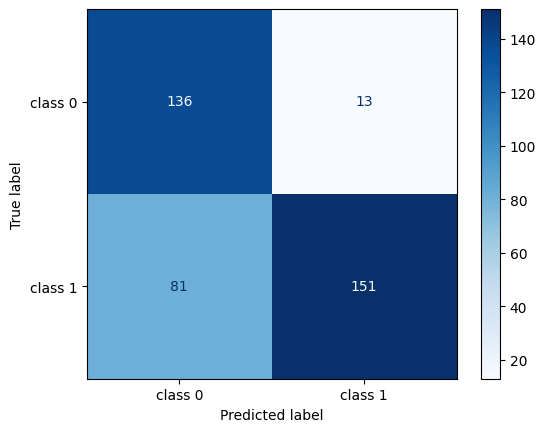

In [147]:
#Creamos el clasificado con GaussianNB, para features con valores continuos
clfnvrfe=GaussianNB()


clfnvrfe.fit(X_train_rfe, y_trainrfe)

y_prednvrfe=clfnvrfe.predict(X_test_rfe)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testrfe, y_prednvrfe))
print("Classification Report:\n", classification_report(y_testrfe, y_prednvrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_prednvrfe, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_prednvrfe))


In [148]:
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_prednvrfe
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Treceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Treceavo, dtype: int64
Aciertos de Predicción:
 0    136
4    145
5      2
1      1
3      2
2      1
Name: Treceavo, dtype: int64
Errores de Predicción:
 3     6
0    13
4    70
Name: Treceavo, dtype: int64
Total Correctas: 287, Total Errores: 94


### 14.- NV con FI

Accuracy: 0.7086614173228346
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.87      0.70       149
           1       0.88      0.61      0.72       232

    accuracy                           0.71       381
   macro avg       0.73      0.74      0.71       381
weighted avg       0.76      0.71      0.71       381

El coeficiente de correlacion de Matthews es de  0.4678005667410332


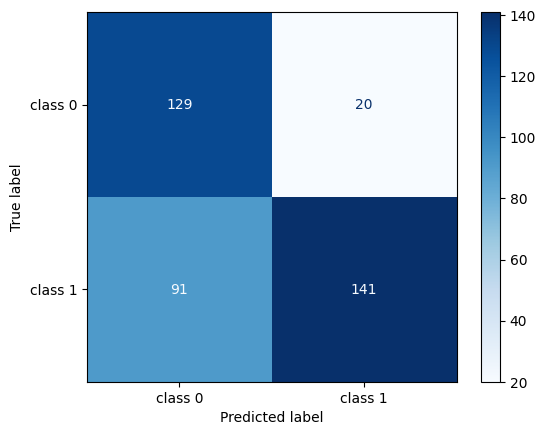

In [149]:
#Creamos el clasificado con GaussianNB, para features con valores continuos
clfnv = GaussianNB()
clfnv.fit(X_train_fi, y_trainfi)

y_prednvfi=clfnv.predict(X_test_fi)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_testfi, y_prednvfi))
print("Classification Report:\n", classification_report(y_testfi, y_prednvfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_prednvfi, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_prednvfi))

In [150]:
df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_prednvfi
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Catorceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Catorceavo, dtype: int64
Aciertos de Predicción:
 0    129
4    131
5      2
1      3
3      4
2      1
Name: Catorceavo, dtype: int64
Errores de Predicción:
 3     4
0    20
4    84
Name: Catorceavo, dtype: int64
Total Correctas: 270, Total Errores: 111


## 15 - 16 Redes Neuronales

### 15.- ANN con Optuna y RFE

In [151]:
start=perf_counter()

# Extraemos el número de features
num_features = X_train_rfe.shape[1]

#Creo el modelo
best_modelfrnrfe= None

def build_model(trial):
    # Inicializa la lista de capas
    num_layers = trial.suggest_int('num_layers', 1, 8)
    units_per_layer = [trial.suggest_int(f'units_layer_{i}', 256, 1024,256) for i in range(num_layers)]
    #dropout_rate = [trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.2) for i in range(num_layers)]
    activators= [trial.suggest_categorical(f'activator_{i}', ['relu', 'leaky_relu', 'tanh']) for i in range(num_layers)]
    kernelinit= [trial.suggest_categorical(f'kernelinit_{i}',['HeNormal','HeUniform','GlorotNormal','GlorotUniform']) for i in range(num_layers)]
    print("Capas ", num_layers, "units per layer: ", units_per_layer)
    # Determina el número de épocas y el tamaño del lote (batch size)
    num_epochs = trial.suggest_int('num_epochs', 10, 50,10)
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 16, 32])

    # Construye el modelo
    model = Sequential()
    model.add(Dense(units_per_layer[0], activation=activators[0], kernel_initializer=kernelinit[0], input_shape=(num_features,)))
    #model.add(Dropout(dropout_rate[0]))

    # Añade las capas ocultas
    for i in range(1,num_layers):
        model.add(Dense(units_per_layer[i], activation=activators[i], kernel_initializer=kernelinit[i]))

        #model.add(Dropout(dropout_rate[i]))


    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    # Compila el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model, num_epochs, batch_size

def objective(trial):
    # Construye y compila el modelo
    modelrn, num_epochs, batch_size = build_model(trial)

    #Cargo el best_model
    global best_modelfrnrfe

    #Callback
    callback= EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)
    # Entrena el modelo
    modelrn.fit(X_train_rfe, y_trainrfe, epochs=num_epochs, batch_size=batch_size, verbose=0, callbacks=[callback])

    # Evalúa el modelo
    score = modelrn.evaluate(X_test_rfe, y_testrfe, verbose=0)

    # Si no hay un trial registrado o si el modelo actual es mejor, almacénalo en 'best_model'
    if trial.number == 0 or score[1] > trial.study.best_value:
        best_modelfrnrfe = modelrn  # Almacena el modelo si es el mejor hasta ahora

    return score[1]

# Crea un estudio de Optuna
studyrn = optuna.create_study(direction='maximize')
studyrn.optimize(objective, n_trials=100, show_progress_bar=True)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

  0%|          | 0/100 [00:00<?, ?it/s]

Capas  3 units per layer:  [768, 768, 512]
Capas  5 units per layer:  [256, 768, 512, 1024, 512]
Capas  1 units per layer:  [256]
Capas  5 units per layer:  [1024, 768, 256, 1024, 768]
Capas  7 units per layer:  [768, 512, 256, 1024, 768, 1024, 1024]
Capas  7 units per layer:  [768, 256, 768, 768, 512, 512, 256]
Capas  4 units per layer:  [512, 768, 768, 512]
Capas  1 units per layer:  [768]
Capas  7 units per layer:  [512, 1024, 256, 768, 256, 512, 256]
Capas  3 units per layer:  [256, 256, 512]
Capas  5 units per layer:  [1024, 1024, 1024, 256, 1024]
Capas  1 units per layer:  [1024]
Capas  3 units per layer:  [1024, 512, 256]
Capas  6 units per layer:  [1024, 1024, 1024, 1024, 1024, 1024]
Capas  2 units per layer:  [1024, 512]
Capas  4 units per layer:  [1024, 768, 256, 512]
Capas  4 units per layer:  [1024, 768, 256, 512]
Capas  6 units per layer:  [512, 768, 256, 256, 768, 256]
Capas  8 units per layer:  [768, 512, 512, 512, 256, 768, 1024, 512]
Capas  5 units per layer:  [1024, 1

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       149
           1       0.97      0.97      0.97       232

    accuracy                           0.97       381
   macro avg       0.97      0.97      0.97       381
weighted avg       0.97      0.97      0.97       381



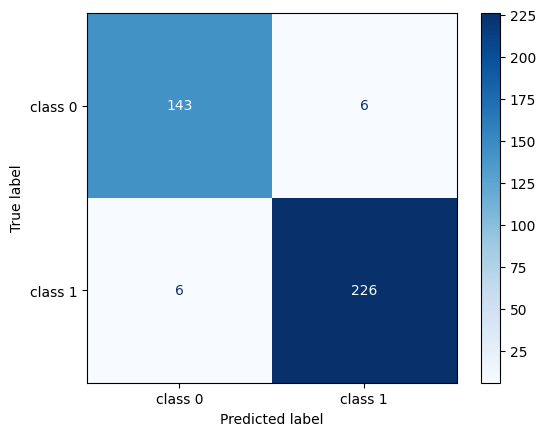

In [152]:
y_pred_probarfe = best_modelfrnrfe.predict(X_test_rfe)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnrfe = (y_pred_probarfe > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(y_testrfe, y_predfrnrfe))
ConfusionMatrixDisplay.from_predictions(y_testrfe, y_predfrnrfe, display_labels=target_names, cmap=plt.cm.Blues)

In [153]:

explainerrfe = shap.Explainer(best_modelfrnrfe.predict, X_test_rfe)
shap_valuesrfe = explainerrfe(X_test_rfe)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
55/55 ━━━━━━━━━━

PermutationExplainer explainer:   1%|          | 2/381 [00:00<?, ?it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:   1%|          | 4/381 [00:14<07:18,  1.16s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


PermutationExplainer explainer:   1%|▏         | 5/381 [00:16<10:54,  1.74s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:   2%|▏         | 6/381 [00:18<11:56,  1.91s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer:   2%|▏         | 7/381 [00:21<12:58,  2.08s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   2%|▏         | 8/381 [00:23<13:05,  2.11s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:   2%|▏         | 9/381 [00:25<13:42,  2.21s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:   3%|▎         | 10/381 [00:28<13:58,  2.26s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:   3%|▎         | 11/381 [00:30<13:57,  2.26s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step


PermutationExplainer explainer:   3%|▎         | 12/381 [00:32<14:11,  2.31s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:   3%|▎         | 13/381 [00:35<14:04,  2.30s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   4%|▎         | 14/381 [00:37<13:45,  2.25s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   4%|▍         | 15/381 [00:39<13:26,  2.20s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:   4%|▍         | 16/381 [00:41<13:59,  2.30s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   4%|▍         | 17/381 [00:44<13:40,  2.25s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:   5%|▍         | 18/381 [00:46<14:04,  2.33s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


PermutationExplainer explainer:   5%|▍         | 19/381 [00:48<14:09,  2.35s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


PermutationExplainer explainer:   5%|▌         | 20/381 [00:51<14:32,  2.42s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   6%|▌         | 21/381 [00:53<13:58,  2.33s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   6%|▌         | 22/381 [00:55<13:58,  2.34s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   6%|▌         | 23/381 [00:58<13:58,  2.34s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   6%|▋         | 24/381 [01:00<13:38,  2.29s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


PermutationExplainer explainer:   7%|▋         | 25/381 [01:02<13:35,  2.29s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   7%|▋         | 26/381 [01:04<13:17,  2.25s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


PermutationExplainer explainer:   7%|▋         | 27/381 [01:07<13:47,  2.34s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


PermutationExplainer explainer:   7%|▋         | 28/381 [01:09<13:41,  2.33s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:   8%|▊         | 29/381 [01:12<13:49,  2.36s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:   8%|▊         | 30/381 [01:14<13:22,  2.29s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   8%|▊         | 31/381 [01:16<13:16,  2.28s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:   8%|▊         | 32/381 [01:18<13:23,  2.30s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   9%|▊         | 33/381 [01:21<13:23,  2.31s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:   9%|▉         | 34/381 [01:23<13:20,  2.31s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:   9%|▉         | 35/381 [01:25<13:29,  2.34s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   9%|▉         | 36/381 [01:28<13:39,  2.37s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


PermutationExplainer explainer:  10%|▉         | 37/381 [01:30<13:40,  2.38s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  10%|▉         | 38/381 [01:33<13:16,  2.32s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  10%|█         | 39/381 [01:35<13:06,  2.30s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


PermutationExplainer explainer:  10%|█         | 40/381 [01:37<13:02,  2.29s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


PermutationExplainer explainer:  11%|█         | 41/381 [01:39<13:06,  2.31s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  11%|█         | 42/381 [01:42<13:18,  2.35s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  11%|█▏        | 43/381 [01:44<13:11,  2.34s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:  12%|█▏        | 44/381 [01:46<13:01,  2.32s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  12%|█▏        | 45/381 [01:48<12:33,  2.24s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  12%|█▏        | 46/381 [01:51<12:49,  2.30s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  12%|█▏        | 47/381 [01:53<12:48,  2.30s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  13%|█▎        | 48/381 [01:55<12:33,  2.26s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


PermutationExplainer explainer:  13%|█▎        | 49/381 [01:58<12:43,  2.30s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  13%|█▎        | 50/381 [02:00<12:53,  2.34s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  13%|█▎        | 51/381 [02:03<13:05,  2.38s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  14%|█▎        | 52/381 [02:05<12:58,  2.37s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  14%|█▍        | 53/381 [02:08<13:09,  2.41s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  14%|█▍        | 54/381 [02:10<12:56,  2.38s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  14%|█▍        | 55/381 [02:12<12:57,  2.38s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  15%|█▍        | 56/381 [02:14<12:32,  2.32s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  15%|█▍        | 57/381 [02:17<12:12,  2.26s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  15%|█▌        | 58/381 [02:19<11:59,  2.23s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  15%|█▌        | 59/381 [02:21<12:06,  2.26s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  16%|█▌        | 60/381 [02:23<12:12,  2.28s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  16%|█▌        | 61/381 [02:26<12:20,  2.31s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:  16%|█▋        | 62/381 [02:28<12:14,  2.30s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  17%|█▋        | 63/381 [02:30<12:25,  2.34s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  17%|█▋        | 64/381 [02:33<12:25,  2.35s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  17%|█▋        | 65/381 [02:35<12:03,  2.29s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  17%|█▋        | 66/381 [02:37<12:14,  2.33s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  18%|█▊        | 67/381 [02:40<12:13,  2.34s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


PermutationExplainer explainer:  18%|█▊        | 68/381 [02:42<12:17,  2.36s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  18%|█▊        | 69/381 [02:44<12:10,  2.34s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  18%|█▊        | 70/381 [02:47<12:09,  2.34s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


PermutationExplainer explainer:  19%|█▊        | 71/381 [02:49<12:23,  2.40s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  19%|█▉        | 72/381 [02:52<12:25,  2.41s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  19%|█▉        | 73/381 [02:54<12:20,  2.40s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  19%|█▉        | 74/381 [02:56<12:01,  2.35s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  20%|█▉        | 75/381 [02:59<11:41,  2.29s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


PermutationExplainer explainer:  20%|█▉        | 76/381 [03:01<11:48,  2.32s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  20%|██        | 77/381 [03:03<11:30,  2.27s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


PermutationExplainer explainer:  20%|██        | 78/381 [03:06<11:49,  2.34s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


PermutationExplainer explainer:  21%|██        | 79/381 [03:08<12:13,  2.43s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  21%|██        | 80/381 [03:10<11:48,  2.35s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  21%|██▏       | 81/381 [03:13<11:38,  2.33s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  22%|██▏       | 82/381 [03:15<11:46,  2.36s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  22%|██▏       | 83/381 [03:17<11:29,  2.31s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


PermutationExplainer explainer:  22%|██▏       | 84/381 [03:20<11:22,  2.30s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  22%|██▏       | 85/381 [03:22<11:05,  2.25s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


PermutationExplainer explainer:  23%|██▎       | 86/381 [03:24<11:07,  2.26s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  23%|██▎       | 87/381 [03:26<11:19,  2.31s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step


PermutationExplainer explainer:  23%|██▎       | 88/381 [03:29<11:25,  2.34s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  23%|██▎       | 89/381 [03:31<10:59,  2.26s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  24%|██▎       | 90/381 [03:33<10:46,  2.22s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  24%|██▍       | 91/381 [03:35<10:40,  2.21s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  24%|██▍       | 92/381 [03:37<10:30,  2.18s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


PermutationExplainer explainer:  24%|██▍       | 93/381 [03:40<10:40,  2.22s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


PermutationExplainer explainer:  25%|██▍       | 94/381 [03:42<10:45,  2.25s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


PermutationExplainer explainer:  25%|██▍       | 95/381 [03:44<10:54,  2.29s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  25%|██▌       | 96/381 [03:47<10:43,  2.26s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:  25%|██▌       | 97/381 [03:49<10:40,  2.26s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


PermutationExplainer explainer:  26%|██▌       | 98/381 [03:51<10:26,  2.21s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  26%|██▌       | 99/381 [03:53<10:24,  2.21s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  26%|██▌       | 100/381 [03:56<10:46,  2.30s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  27%|██▋       | 101/381 [03:58<10:38,  2.28s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  27%|██▋       | 102/381 [04:00<10:42,  2.30s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  27%|██▋       | 103/381 [04:02<10:31,  2.27s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  27%|██▋       | 104/381 [04:05<10:36,  2.30s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer:  28%|██▊       | 105/381 [04:07<10:41,  2.32s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  28%|██▊       | 106/381 [04:09<10:19,  2.25s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


PermutationExplainer explainer:  28%|██▊       | 107/381 [04:12<10:30,  2.30s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  28%|██▊       | 108/381 [04:14<10:35,  2.33s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  29%|██▊       | 109/381 [04:16<10:19,  2.28s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


PermutationExplainer explainer:  29%|██▉       | 110/381 [04:19<10:39,  2.36s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  29%|██▉       | 111/381 [04:21<10:19,  2.29s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  29%|██▉       | 112/381 [04:23<10:07,  2.26s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  30%|██▉       | 113/381 [04:25<10:02,  2.25s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  30%|██▉       | 114/381 [04:27<09:49,  2.21s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  30%|███       | 115/381 [04:30<09:56,  2.24s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  30%|███       | 116/381 [04:32<09:44,  2.20s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  31%|███       | 117/381 [04:34<09:54,  2.25s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


PermutationExplainer explainer:  31%|███       | 118/381 [04:36<09:52,  2.25s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


PermutationExplainer explainer:  31%|███       | 119/381 [04:39<09:48,  2.25s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  31%|███▏      | 120/381 [04:41<09:43,  2.23s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  32%|███▏      | 121/381 [04:43<09:45,  2.25s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  32%|███▏      | 122/381 [04:46<09:47,  2.27s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  32%|███▏      | 123/381 [04:48<09:56,  2.31s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


PermutationExplainer explainer:  33%|███▎      | 124/381 [04:50<10:13,  2.39s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  33%|███▎      | 125/381 [04:53<09:54,  2.32s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  33%|███▎      | 126/381 [04:55<09:40,  2.28s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  33%|███▎      | 127/381 [04:57<09:57,  2.35s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  34%|███▎      | 128/381 [05:00<10:02,  2.38s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  34%|███▍      | 129/381 [05:02<09:54,  2.36s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  34%|███▍      | 130/381 [05:04<09:35,  2.29s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


PermutationExplainer explainer:  34%|███▍      | 131/381 [05:07<09:39,  2.32s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


PermutationExplainer explainer:  35%|███▍      | 132/381 [05:09<09:41,  2.34s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  35%|███▍      | 133/381 [05:11<09:46,  2.37s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  35%|███▌      | 134/381 [05:14<09:45,  2.37s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  35%|███▌      | 135/381 [05:16<09:43,  2.37s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|███▌      | 136/381 [05:18<09:32,  2.34s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|███▌      | 137/381 [05:21<09:13,  2.27s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|███▌      | 138/381 [05:23<08:59,  2.22s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|███▋      | 139/381 [05:25<08:50,  2.19s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


PermutationExplainer explainer:  37%|███▋      | 140/381 [05:27<08:45,  2.18s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  37%|███▋      | 141/381 [05:29<08:43,  2.18s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  37%|███▋      | 142/381 [05:31<08:37,  2.17s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  38%|███▊      | 143/381 [05:33<08:30,  2.14s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  38%|███▊      | 144/381 [05:35<08:27,  2.14s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  38%|███▊      | 145/381 [05:38<08:23,  2.13s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  38%|███▊      | 146/381 [05:40<08:40,  2.21s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  39%|███▊      | 147/381 [05:42<08:31,  2.19s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  39%|███▉      | 148/381 [05:44<08:32,  2.20s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  39%|███▉      | 149/381 [05:46<08:27,  2.19s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


PermutationExplainer explainer:  39%|███▉      | 150/381 [05:49<08:38,  2.24s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  40%|███▉      | 151/381 [05:51<08:32,  2.23s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  40%|███▉      | 152/381 [05:54<08:48,  2.31s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  40%|████      | 153/381 [05:56<08:36,  2.26s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  40%|████      | 154/381 [05:58<08:54,  2.35s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  41%|████      | 155/381 [06:00<08:34,  2.27s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  41%|████      | 156/381 [06:03<08:35,  2.29s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  41%|████      | 157/381 [06:05<08:36,  2.30s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


PermutationExplainer explainer:  41%|████▏     | 158/381 [06:07<08:40,  2.33s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  42%|████▏     | 159/381 [06:10<08:49,  2.39s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  42%|████▏     | 160/381 [06:12<08:43,  2.37s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  42%|████▏     | 161/381 [06:14<08:27,  2.31s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  43%|████▎     | 162/381 [06:17<08:14,  2.26s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  43%|████▎     | 163/381 [06:19<08:15,  2.27s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  43%|████▎     | 164/381 [06:21<08:08,  2.25s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


PermutationExplainer explainer:  43%|████▎     | 165/381 [06:23<08:09,  2.27s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▎     | 166/381 [06:26<08:01,  2.24s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 167/381 [06:28<07:57,  2.23s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  44%|████▍     | 168/381 [06:30<08:05,  2.28s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


PermutationExplainer explainer:  44%|████▍     | 169/381 [06:33<08:21,  2.37s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▍     | 170/381 [06:35<08:08,  2.32s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  45%|████▍     | 171/381 [06:38<08:25,  2.41s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|████▌     | 172/381 [06:40<08:27,  2.43s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  45%|████▌     | 173/381 [06:43<08:30,  2.46s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 174/381 [06:45<08:14,  2.39s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 175/381 [06:47<08:10,  2.38s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▌     | 176/381 [06:49<08:00,  2.34s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  46%|████▋     | 177/381 [06:52<07:52,  2.31s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  47%|████▋     | 178/381 [06:54<07:50,  2.32s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  47%|████▋     | 179/381 [06:56<07:49,  2.32s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


PermutationExplainer explainer:  47%|████▋     | 180/381 [06:59<07:53,  2.36s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 181/381 [07:01<07:58,  2.39s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 182/381 [07:04<07:57,  2.40s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 183/381 [07:06<07:41,  2.33s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  48%|████▊     | 184/381 [07:08<07:29,  2.28s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  49%|████▊     | 185/381 [07:10<07:39,  2.34s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  49%|████▉     | 186/381 [07:13<07:21,  2.27s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 187/381 [07:15<07:08,  2.21s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|████▉     | 188/381 [07:17<07:02,  2.19s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|████▉     | 189/381 [07:19<06:56,  2.17s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


PermutationExplainer explainer:  50%|████▉     | 190/381 [07:21<07:06,  2.23s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  50%|█████     | 191/381 [07:24<07:20,  2.32s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|█████     | 192/381 [07:26<07:11,  2.29s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 193/381 [07:28<07:02,  2.25s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  51%|█████     | 194/381 [07:30<06:54,  2.22s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|█████     | 195/381 [07:32<06:48,  2.20s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  51%|█████▏    | 196/381 [07:35<06:48,  2.21s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  52%|█████▏    | 197/381 [07:37<06:49,  2.22s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  52%|█████▏    | 198/381 [07:39<06:40,  2.19s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  52%|█████▏    | 199/381 [07:41<06:39,  2.19s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  52%|█████▏    | 200/381 [07:44<06:39,  2.21s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  53%|█████▎    | 201/381 [07:46<06:43,  2.24s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


PermutationExplainer explainer:  53%|█████▎    | 202/381 [07:48<06:56,  2.33s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|█████▎    | 203/381 [07:51<06:46,  2.29s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


PermutationExplainer explainer:  54%|█████▎    | 204/381 [07:53<06:54,  2.34s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  54%|█████▍    | 205/381 [07:55<06:54,  2.35s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  54%|█████▍    | 206/381 [07:58<07:01,  2.41s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step


PermutationExplainer explainer:  54%|█████▍    | 207/381 [08:00<07:00,  2.42s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▍    | 208/381 [08:03<06:59,  2.42s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|█████▍    | 209/381 [08:05<06:55,  2.42s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  55%|█████▌    | 210/381 [08:08<06:52,  2.41s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  55%|█████▌    | 211/381 [08:10<06:37,  2.34s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  56%|█████▌    | 212/381 [08:12<06:38,  2.36s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  56%|█████▌    | 213/381 [08:15<06:41,  2.39s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  56%|█████▌    | 214/381 [08:17<06:38,  2.39s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  56%|█████▋    | 215/381 [08:19<06:39,  2.40s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 216/381 [08:22<06:30,  2.37s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  57%|█████▋    | 217/381 [08:24<06:18,  2.31s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  57%|█████▋    | 218/381 [08:26<06:13,  2.29s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


PermutationExplainer explainer:  57%|█████▋    | 219/381 [08:29<06:16,  2.32s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|█████▊    | 220/381 [08:31<06:04,  2.26s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  58%|█████▊    | 221/381 [08:33<06:07,  2.30s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


PermutationExplainer explainer:  58%|█████▊    | 222/381 [08:35<06:09,  2.32s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▊    | 223/381 [08:38<05:58,  2.27s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  59%|█████▉    | 224/381 [08:40<06:03,  2.31s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  59%|█████▉    | 225/381 [08:42<05:52,  2.26s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|█████▉    | 226/381 [08:44<05:41,  2.20s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  60%|█████▉    | 227/381 [08:46<05:39,  2.20s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|█████▉    | 228/381 [08:49<05:32,  2.17s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  60%|██████    | 229/381 [08:51<05:40,  2.24s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|██████    | 230/381 [08:53<05:31,  2.20s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


PermutationExplainer explainer:  61%|██████    | 231/381 [08:55<05:28,  2.19s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


PermutationExplainer explainer:  61%|██████    | 232/381 [08:58<05:31,  2.23s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  61%|██████    | 233/381 [09:00<05:26,  2.21s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  61%|██████▏   | 234/381 [09:02<05:27,  2.23s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  62%|██████▏   | 235/381 [09:04<05:31,  2.27s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


PermutationExplainer explainer:  62%|██████▏   | 236/381 [09:07<05:41,  2.36s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


PermutationExplainer explainer:  62%|██████▏   | 237/381 [09:09<05:38,  2.35s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  62%|██████▏   | 238/381 [09:12<05:38,  2.37s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|██████▎   | 239/381 [09:14<05:26,  2.30s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  63%|██████▎   | 240/381 [09:16<05:34,  2.37s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|██████▎   | 241/381 [09:18<05:20,  2.29s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  64%|██████▎   | 242/381 [09:21<05:12,  2.25s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  64%|██████▍   | 243/381 [09:23<05:13,  2.27s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  64%|██████▍   | 244/381 [09:25<05:14,  2.30s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


PermutationExplainer explainer:  64%|██████▍   | 245/381 [09:28<05:17,  2.34s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  65%|██████▍   | 246/381 [09:30<05:24,  2.40s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  65%|██████▍   | 247/381 [09:32<05:16,  2.36s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


PermutationExplainer explainer:  65%|██████▌   | 248/381 [09:35<05:17,  2.39s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  65%|██████▌   | 249/381 [09:37<05:14,  2.38s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


PermutationExplainer explainer:  66%|██████▌   | 250/381 [09:40<05:15,  2.41s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 251/381 [09:42<05:05,  2.35s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 252/381 [09:44<04:55,  2.29s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


PermutationExplainer explainer:  66%|██████▋   | 253/381 [09:47<04:59,  2.34s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


PermutationExplainer explainer:  67%|██████▋   | 254/381 [09:49<04:54,  2.32s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  67%|██████▋   | 255/381 [09:51<04:59,  2.38s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 256/381 [09:54<04:50,  2.32s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|██████▋   | 257/381 [09:56<04:42,  2.28s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 258/381 [09:58<04:49,  2.35s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


PermutationExplainer explainer:  68%|██████▊   | 259/381 [10:01<04:43,  2.32s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 260/381 [10:03<04:40,  2.32s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  69%|██████▊   | 261/381 [10:05<04:45,  2.38s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 262/381 [10:08<04:52,  2.46s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 263/381 [10:11<05:10,  2.63s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  69%|██████▉   | 264/381 [10:13<04:58,  2.55s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  70%|██████▉   | 265/381 [10:16<04:52,  2.52s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  70%|██████▉   | 266/381 [10:18<04:44,  2.47s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  70%|███████   | 267/381 [10:21<04:41,  2.47s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  70%|███████   | 268/381 [10:23<04:36,  2.45s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  71%|███████   | 269/381 [10:25<04:32,  2.43s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  71%|███████   | 270/381 [10:28<04:22,  2.36s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  71%|███████   | 271/381 [10:30<04:24,  2.40s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  71%|███████▏  | 272/381 [10:32<04:12,  2.32s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 273/381 [10:34<04:04,  2.27s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 274/381 [10:37<04:00,  2.25s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 275/381 [10:39<03:59,  2.26s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 276/381 [10:41<03:58,  2.27s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


PermutationExplainer explainer:  73%|███████▎  | 277/381 [10:44<04:03,  2.34s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|███████▎  | 278/381 [10:46<03:56,  2.29s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  73%|███████▎  | 279/381 [10:48<03:57,  2.33s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  73%|███████▎  | 280/381 [10:51<04:00,  2.38s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 281/381 [10:53<03:58,  2.39s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


PermutationExplainer explainer:  74%|███████▍  | 282/381 [10:56<03:57,  2.40s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


PermutationExplainer explainer:  74%|███████▍  | 283/381 [10:58<03:55,  2.41s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


PermutationExplainer explainer:  75%|███████▍  | 284/381 [11:00<03:53,  2.41s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  75%|███████▍  | 285/381 [11:03<03:44,  2.33s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


PermutationExplainer explainer:  75%|███████▌  | 286/381 [11:05<03:45,  2.38s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  75%|███████▌  | 287/381 [11:08<03:47,  2.42s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  76%|███████▌  | 288/381 [11:10<03:45,  2.43s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 289/381 [11:12<03:40,  2.40s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 290/381 [11:15<03:36,  2.38s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  76%|███████▋  | 291/381 [11:17<03:30,  2.34s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 292/381 [11:19<03:25,  2.31s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 293/381 [11:23<03:51,  2.63s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  77%|███████▋  | 294/381 [11:25<03:46,  2.61s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|███████▋  | 295/381 [11:27<03:36,  2.52s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


PermutationExplainer explainer:  78%|███████▊  | 296/381 [11:30<03:26,  2.43s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


PermutationExplainer explainer:  78%|███████▊  | 297/381 [11:32<03:18,  2.37s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


PermutationExplainer explainer:  78%|███████▊  | 298/381 [11:34<03:09,  2.29s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|███████▊  | 299/381 [11:36<03:01,  2.21s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


PermutationExplainer explainer:  79%|███████▊  | 300/381 [11:38<02:55,  2.17s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  79%|███████▉  | 301/381 [11:40<02:51,  2.14s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  79%|███████▉  | 302/381 [11:42<02:48,  2.13s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer:  80%|███████▉  | 303/381 [11:45<02:51,  2.19s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  80%|███████▉  | 304/381 [11:47<02:45,  2.15s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


PermutationExplainer explainer:  80%|████████  | 305/381 [11:49<02:47,  2.21s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  80%|████████  | 306/381 [11:51<02:42,  2.17s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


PermutationExplainer explainer:  81%|████████  | 307/381 [11:53<02:42,  2.19s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


PermutationExplainer explainer:  81%|████████  | 308/381 [11:55<02:37,  2.16s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  81%|████████  | 309/381 [11:58<02:37,  2.18s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  81%|████████▏ | 310/381 [12:00<02:40,  2.26s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 311/381 [12:02<02:38,  2.26s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 312/381 [12:04<02:32,  2.21s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  82%|████████▏ | 313/381 [12:07<02:32,  2.24s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|████████▏ | 314/381 [12:09<02:27,  2.20s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


PermutationExplainer explainer:  83%|████████▎ | 315/381 [12:11<02:26,  2.22s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  83%|████████▎ | 316/381 [12:13<02:21,  2.18s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


PermutationExplainer explainer:  83%|████████▎ | 317/381 [12:15<02:19,  2.18s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  83%|████████▎ | 318/381 [12:18<02:18,  2.20s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  84%|████████▎ | 319/381 [12:20<02:14,  2.17s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  84%|████████▍ | 320/381 [12:22<02:14,  2.20s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|████████▍ | 321/381 [12:24<02:11,  2.18s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▍ | 322/381 [12:27<02:12,  2.24s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▍ | 323/381 [12:29<02:11,  2.26s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▌ | 324/381 [12:31<02:05,  2.20s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|████████▌ | 325/381 [12:33<02:01,  2.17s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


PermutationExplainer explainer:  86%|████████▌ | 326/381 [12:35<02:01,  2.22s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  86%|████████▌ | 327/381 [12:37<01:58,  2.19s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|████████▌ | 328/381 [12:40<01:54,  2.16s/it]

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|████████▋ | 329/381 [12:42<01:51,  2.15s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  87%|████████▋ | 330/381 [12:44<01:48,  2.13s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  87%|████████▋ | 331/381 [12:46<01:49,  2.19s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 332/381 [12:48<01:46,  2.17s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  87%|████████▋ | 333/381 [12:50<01:43,  2.15s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 334/381 [12:53<01:40,  2.15s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


PermutationExplainer explainer:  88%|████████▊ | 335/381 [12:55<01:42,  2.22s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


PermutationExplainer explainer:  88%|████████▊ | 336/381 [12:57<01:39,  2.22s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|████████▊ | 337/381 [12:59<01:35,  2.18s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  89%|████████▊ | 338/381 [13:02<01:36,  2.24s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|████████▉ | 339/381 [13:04<01:32,  2.20s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


PermutationExplainer explainer:  89%|████████▉ | 340/381 [13:06<01:32,  2.25s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|████████▉ | 341/381 [13:08<01:28,  2.21s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


PermutationExplainer explainer:  90%|████████▉ | 342/381 [13:11<01:28,  2.26s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|█████████ | 343/381 [13:13<01:24,  2.21s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


PermutationExplainer explainer:  90%|█████████ | 344/381 [13:15<01:24,  2.27s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  91%|█████████ | 345/381 [13:17<01:20,  2.23s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


PermutationExplainer explainer:  91%|█████████ | 346/381 [13:19<01:18,  2.24s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


PermutationExplainer explainer:  91%|█████████ | 347/381 [13:22<01:16,  2.24s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  91%|█████████▏| 348/381 [13:24<01:12,  2.19s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  92%|█████████▏| 349/381 [13:26<01:11,  2.23s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


PermutationExplainer explainer:  92%|█████████▏| 350/381 [13:28<01:08,  2.22s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


PermutationExplainer explainer:  92%|█████████▏| 351/381 [13:31<01:07,  2.25s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


PermutationExplainer explainer:  92%|█████████▏| 352/381 [13:33<01:05,  2.24s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


PermutationExplainer explainer:  93%|█████████▎| 353/381 [13:35<01:02,  2.22s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  93%|█████████▎| 354/381 [13:37<00:59,  2.19s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  93%|█████████▎| 355/381 [13:39<00:57,  2.20s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  93%|█████████▎| 356/381 [13:42<00:54,  2.19s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  94%|█████████▎| 357/381 [13:44<00:54,  2.27s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▍| 358/381 [13:46<00:51,  2.24s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▍| 359/381 [13:48<00:49,  2.27s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


PermutationExplainer explainer:  94%|█████████▍| 360/381 [13:51<00:47,  2.24s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


PermutationExplainer explainer:  95%|█████████▍| 361/381 [13:53<00:45,  2.29s/it]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  95%|█████████▌| 362/381 [13:55<00:42,  2.23s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


PermutationExplainer explainer:  95%|█████████▌| 363/381 [13:58<00:41,  2.28s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


PermutationExplainer explainer:  96%|█████████▌| 364/381 [14:00<00:39,  2.35s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▌| 365/381 [14:02<00:36,  2.29s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


PermutationExplainer explainer:  96%|█████████▌| 366/381 [14:04<00:33,  2.23s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  96%|█████████▋| 367/381 [14:06<00:30,  2.19s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


PermutationExplainer explainer:  97%|█████████▋| 368/381 [14:09<00:28,  2.22s/it]

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


PermutationExplainer explainer:  97%|█████████▋| 369/381 [14:11<00:26,  2.18s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


PermutationExplainer explainer:  97%|█████████▋| 370/381 [14:13<00:24,  2.21s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  97%|█████████▋| 371/381 [14:15<00:22,  2.25s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


PermutationExplainer explainer:  98%|█████████▊| 372/381 [14:18<00:20,  2.25s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


PermutationExplainer explainer:  98%|█████████▊| 373/381 [14:20<00:18,  2.31s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  98%|█████████▊| 374/381 [14:23<00:16,  2.36s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


PermutationExplainer explainer:  98%|█████████▊| 375/381 [14:25<00:14,  2.37s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|█████████▊| 376/381 [14:27<00:11,  2.34s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


PermutationExplainer explainer:  99%|█████████▉| 377/381 [14:30<00:09,  2.39s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|█████████▉| 378/381 [14:32<00:07,  2.36s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


PermutationExplainer explainer:  99%|█████████▉| 379/381 [14:34<00:04,  2.37s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


PermutationExplainer explainer: 100%|█████████▉| 380/381 [14:37<00:02,  2.39s/it]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 100%|██████████| 381/381 [14:39<00:00,  2.31s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


PermutationExplainer explainer: 382it [14:41,  2.32s/it]                         


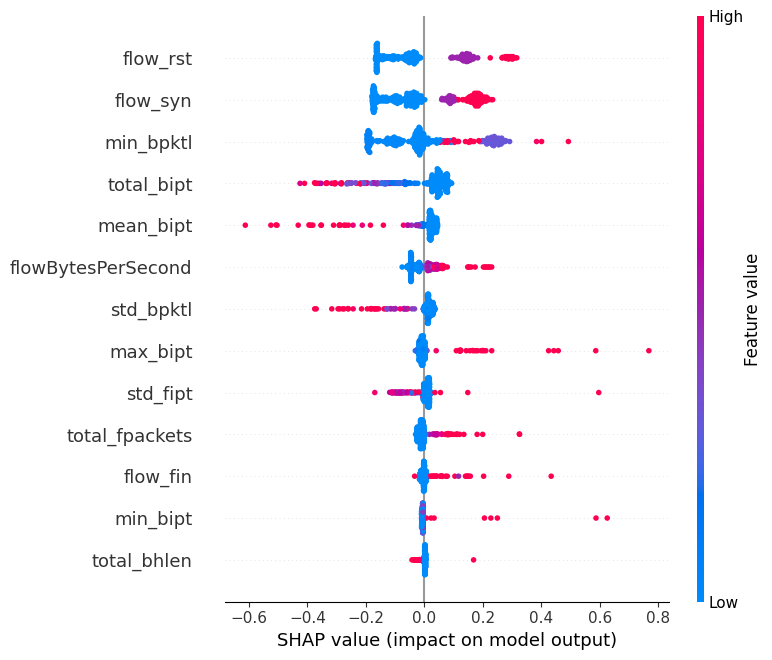

In [154]:


# Visualización resumen
shap.summary_plot(shap_valuesrfe, X_test_rfe)

In [155]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testrfe, y_predfrnrfe))

El coeficiente de correlacion de Matthews es de  0.9338694746586438


In [156]:
y_predfrnrfe_flat=y_predfrnrfe.flatten()
df_resultados = pd.DataFrame({
    'Clase': RFE_test,
    'Real': y_testrfe,
    'Predicción': y_predfrnrfe_flat
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Quinceavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Quinceavo, dtype: int64
Aciertos de Predicción:
 0    143
4    213
5      5
1      3
3      4
2      1
Name: Quinceavo, dtype: int64
Errores de Predicción:
 3    4
0    6
4    2
Name: Quinceavo, dtype: int64
Total Correctas: 369, Total Errores: 12


### 16.- ANN con Optuna y FI

In [157]:
start=perf_counter()

# Extraemos el número de features
num_features = X_train_fi.shape[1]

#Creo el modelo
best_modelrnfi= None

def build_model(trial):
    # Inicializa la lista de capas
    num_layers = trial.suggest_int('num_layers', 1, 8)
    units_per_layer = [trial.suggest_int(f'units_layer_{i}', 256, 1024,256) for i in range(num_layers)]
    #dropout_rate = [trial.suggest_uniform(f'dropout_rate_{i}', 0.0, 0.2) for i in range(num_layers)]
    activators= [trial.suggest_categorical(f'activator_{i}', ['relu', 'leaky_relu', 'tanh']) for i in range(num_layers)]
    kernelinit= [trial.suggest_categorical(f'kernelinit_{i}',['HeNormal','HeUniform','GlorotNormal','GlorotUniform']) for i in range(num_layers)]
    print("Capas ", num_layers, "units per layer: ", units_per_layer)
    # Determina el número de épocas y el tamaño del lote (batch size)
    num_epochs = trial.suggest_int('num_epochs', 10, 50,10)
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 16, 32])

    # Construye el modelo
    model = Sequential()
    model.add(Dense(units_per_layer[0], activation=activators[0], kernel_initializer=kernelinit[0], input_shape=(num_features,)))
    #model.add(Dropout(dropout_rate[0]))

    # Añade las capas ocultas
    for i in range(1,num_layers):
        model.add(Dense(units_per_layer[i], activation=activators[i], kernel_initializer=kernelinit[i]))

        #model.add(Dropout(dropout_rate[i]))


    # Capa de salida
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    # Compila el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model, num_epochs, batch_size

def objective(trial):
    # Construye y compila el modelo
    modelrnfi, num_epochs, batch_size = build_model(trial)

    #Cargo el best_model
    global best_modelrnfi

    #Callback
    callback= EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
    # Entrena el modelo
    modelrnfi.fit(X_train_fi, y_trainfi, epochs=num_epochs, batch_size=batch_size, verbose=0, callbacks=[callback])

    # Evalúa el modelo
    score = modelrnfi.evaluate(X_test_fi, y_testfi, verbose=0)

    # Si no hay un trial registrado o si el modelo actual es mejor, almacénalo en 'best_model'
    if trial.number == 0 or score[1] > trial.study.best_value:
        best_modelrnfi = modelrnfi  # Almacena el modelo si es el mejor hasta ahora

    return score[1]

# Crea un estudio de Optuna
studyrn = optuna.create_study(direction='maximize')
studyrn.optimize(objective, n_trials=100, show_progress_bar=True)

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f min.' %tl)

  0%|          | 0/100 [00:00<?, ?it/s]

Capas  4 units per layer:  [256, 512, 256, 512]
Capas  2 units per layer:  [256, 256]
Capas  6 units per layer:  [512, 256, 768, 768, 256, 768]
Capas  1 units per layer:  [512]
Capas  7 units per layer:  [512, 256, 1024, 768, 768, 1024, 1024]
Capas  3 units per layer:  [512, 512, 768]
Capas  2 units per layer:  [1024, 512]
Capas  6 units per layer:  [768, 512, 512, 512, 768, 768]
Capas  3 units per layer:  [768, 256, 512]
Capas  6 units per layer:  [768, 768, 768, 256, 256, 256]
Capas  1 units per layer:  [1024]
Capas  3 units per layer:  [1024, 1024, 256]
Capas  4 units per layer:  [1024, 768, 512, 1024]
Capas  2 units per layer:  [768, 256]
Capas  2 units per layer:  [1024, 512]
Capas  2 units per layer:  [768, 768]
Capas  8 units per layer:  [1024, 256, 1024, 256, 1024, 256, 256, 1024]
Capas  5 units per layer:  [768, 512, 1024, 1024, 512]
Capas  1 units per layer:  [1024]
Capas  2 units per layer:  [768, 1024]
Capas  4 units per layer:  [1024, 256, 256, 1024]
Capas  3 units per lay

In [158]:
X_test_fi.shape

(381, 7)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.99      0.98      0.98       232

    accuracy                           0.98       381
   macro avg       0.98      0.98      0.98       381
weighted avg       0.98      0.98      0.98       381



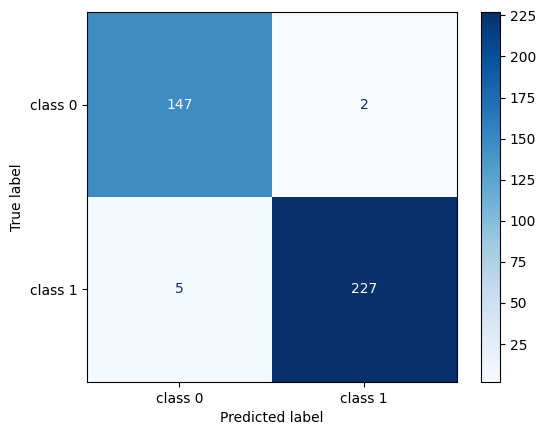

In [159]:
y_pred_probafi = best_modelrnfi.predict(X_test_fi)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnfi = (y_pred_probafi > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(y_testfi, y_predfrnfi))
ConfusionMatrixDisplay.from_predictions(y_testfi, y_predfrnfi, display_labels=target_names, cmap=plt.cm.Blues)

In [160]:
explainerfi= shap.Explainer(best_modelrnfi.predict, X_test_fi)
shap_valuesfi = explainerfi(X_test_fi)

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
2

ExactExplainer explainer:   4%|▍         | 17/381 [00:00<?, ?it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 19/381 [00:10<01:38,  3.66it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 20/381 [00:11<02:29,  2.41it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 21/381 [00:11<02:46,  2.16it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 22/381 [00:12<02:57,  2.02it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 23/381 [00:12<03:04,  1.94it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▋         | 24/381 [00:13<03:06,  1.92it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 25/381 [00:14<03:07,  1.89it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 26/381 [00:14<03:04,  1.92it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 27/381 [00:15<03:13,  1.83it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 28/381 [00:15<03:11,  1.84it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 29/381 [00:16<03:13,  1.82it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 30/381 [00:16<03:09,  1.85it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 31/381 [00:17<03:13,  1.81it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 32/381 [00:17<03:09,  1.84it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 33/381 [00:18<03:07,  1.86it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:   9%|▉         | 34/381 [00:18<03:08,  1.84it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 35/381 [00:19<03:08,  1.83it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 36/381 [00:20<03:14,  1.77it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 37/381 [00:20<03:11,  1.80it/s]

333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 38/381 [00:21<03:12,  1.79it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 39/381 [00:21<03:07,  1.82it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 40/381 [00:22<03:04,  1.85it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 41/381 [00:22<03:04,  1.85it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  11%|█         | 42/381 [00:23<03:06,  1.82it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█▏        | 43/381 [00:23<03:10,  1.78it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 44/381 [00:24<03:06,  1.80it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 45/381 [00:25<03:10,  1.77it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 46/381 [00:25<03:07,  1.79it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 47/381 [00:26<03:05,  1.80it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 48/381 [00:26<03:06,  1.79it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 49/381 [00:27<03:05,  1.79it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 50/381 [00:27<03:07,  1.77it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 51/381 [00:28<03:03,  1.79it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▎        | 52/381 [00:28<03:00,  1.82it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 53/381 [00:29<03:05,  1.76it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 54/381 [00:30<03:03,  1.78it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 55/381 [00:30<03:02,  1.79it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 56/381 [00:31<03:03,  1.77it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 57/381 [00:31<03:00,  1.80it/s]

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 58/381 [00:32<03:02,  1.77it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 59/381 [00:32<03:01,  1.78it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 60/381 [00:33<03:00,  1.77it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 61/381 [00:34<02:58,  1.80it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▋        | 62/381 [00:34<02:55,  1.82it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 63/381 [00:35<02:59,  1.77it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 64/381 [00:35<02:56,  1.79it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 65/381 [00:36<02:57,  1.78it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 66/381 [00:36<03:01,  1.74it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 67/381 [00:37<02:56,  1.78it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 68/381 [00:37<02:53,  1.80it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 69/381 [00:38<02:51,  1.82it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 70/381 [00:38<02:49,  1.83it/s]

400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▊        | 71/381 [00:39<02:56,  1.76it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 72/381 [00:40<02:52,  1.79it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 73/381 [00:40<02:52,  1.79it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  19%|█▉        | 74/381 [00:41<02:46,  1.84it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 75/381 [00:41<02:44,  1.86it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 76/381 [00:42<02:51,  1.78it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 77/381 [00:42<02:50,  1.79it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 78/381 [00:43<02:49,  1.79it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 79/381 [00:44<02:49,  1.78it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 80/381 [00:44<02:48,  1.79it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██▏       | 81/381 [00:45<02:47,  1.79it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 82/381 [00:45<02:48,  1.77it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 83/381 [00:46<02:49,  1.76it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 84/381 [00:46<02:47,  1.78it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 85/381 [00:47<02:45,  1.79it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 86/381 [00:47<02:43,  1.81it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 87/381 [00:48<02:43,  1.80it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  23%|██▎       | 88/381 [00:49<02:40,  1.82it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 89/381 [00:49<02:35,  1.87it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▎       | 90/381 [00:50<02:38,  1.84it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 91/381 [00:50<02:39,  1.82it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 92/381 [00:51<02:42,  1.78it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 93/381 [00:51<02:40,  1.80it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  25%|██▍       | 94/381 [00:52<02:36,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 95/381 [00:52<02:35,  1.84it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 96/381 [00:53<02:34,  1.84it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 97/381 [00:53<02:34,  1.84it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 98/381 [00:54<02:33,  1.84it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 99/381 [00:55<02:30,  1.88it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 100/381 [00:55<02:35,  1.80it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 101/381 [00:56<02:34,  1.82it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 102/381 [00:56<02:33,  1.82it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 103/381 [00:57<02:34,  1.79it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 104/381 [00:57<02:35,  1.78it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 105/381 [00:58<02:34,  1.79it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 106/381 [00:58<02:28,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 107/381 [00:59<02:29,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 108/381 [01:00<02:28,  1.84it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▊       | 109/381 [01:00<02:24,  1.88it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 110/381 [01:01<02:30,  1.80it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 111/381 [01:01<02:31,  1.79it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 112/381 [01:02<02:26,  1.84it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 113/381 [01:02<02:22,  1.87it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 114/381 [01:03<02:24,  1.84it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 115/381 [01:03<02:22,  1.87it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 116/381 [01:04<02:19,  1.90it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 117/381 [01:04<02:21,  1.87it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 118/381 [01:05<02:21,  1.86it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 119/381 [01:05<02:19,  1.87it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███▏      | 120/381 [01:06<02:17,  1.90it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 121/381 [01:07<02:22,  1.83it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 122/381 [01:07<02:20,  1.84it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 123/381 [01:08<02:20,  1.83it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 124/381 [01:08<02:23,  1.79it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 125/381 [01:09<02:20,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  33%|███▎      | 126/381 [01:09<02:18,  1.84it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 127/381 [01:10<02:22,  1.79it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▎      | 128/381 [01:10<02:22,  1.77it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  34%|███▍      | 129/381 [01:11<02:19,  1.80it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 130/381 [01:11<02:15,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 131/381 [01:12<02:17,  1.82it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 132/381 [01:13<02:16,  1.82it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 133/381 [01:13<02:15,  1.83it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 134/381 [01:14<02:18,  1.79it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  35%|███▌      | 135/381 [01:14<02:16,  1.80it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 136/381 [01:15<02:13,  1.83it/s]

335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 137/381 [01:15<02:13,  1.82it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 138/381 [01:16<02:13,  1.82it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▋      | 139/381 [01:16<02:12,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 140/381 [01:17<02:11,  1.84it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 141/381 [01:18<02:14,  1.79it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 142/381 [01:18<02:11,  1.82it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 143/381 [01:19<02:07,  1.86it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 144/381 [01:19<02:11,  1.80it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 145/381 [01:20<02:09,  1.83it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 146/381 [01:20<02:10,  1.81it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▊      | 147/381 [01:21<02:08,  1.82it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 148/381 [01:21<02:05,  1.85it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 149/381 [01:22<02:04,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 150/381 [01:22<02:05,  1.84it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|███▉      | 151/381 [01:23<02:08,  1.79it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|███▉      | 152/381 [01:24<02:08,  1.78it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 153/381 [01:24<02:06,  1.80it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 154/381 [01:25<02:08,  1.77it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 155/381 [01:25<02:03,  1.83it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 156/381 [01:26<02:01,  1.85it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 157/381 [01:26<01:59,  1.88it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  41%|████▏     | 158/381 [01:27<02:01,  1.84it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 159/381 [01:27<01:59,  1.85it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 160/381 [01:28<01:59,  1.86it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 161/381 [01:28<01:55,  1.90it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 162/381 [01:29<01:59,  1.83it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 163/381 [01:30<01:57,  1.86it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 164/381 [01:30<01:56,  1.86it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 165/381 [01:31<01:58,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▎     | 166/381 [01:31<01:57,  1.84it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 167/381 [01:32<01:56,  1.84it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 168/381 [01:32<01:57,  1.82it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 169/381 [01:33<01:58,  1.79it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▍     | 170/381 [01:33<01:57,  1.80it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▍     | 171/381 [01:34<01:58,  1.78it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 172/381 [01:35<01:57,  1.77it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 173/381 [01:35<01:55,  1.80it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 174/381 [01:36<01:54,  1.81it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 175/381 [01:36<01:56,  1.77it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 176/381 [01:37<01:54,  1.80it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▋     | 177/381 [01:37<01:50,  1.85it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 178/381 [01:38<01:51,  1.83it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 179/381 [01:38<01:49,  1.85it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  47%|████▋     | 180/381 [01:39<01:48,  1.86it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 181/381 [01:39<01:47,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 182/381 [01:40<01:49,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 183/381 [01:41<01:47,  1.83it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 184/381 [01:41<01:47,  1.84it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▊     | 185/381 [01:42<01:50,  1.77it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 186/381 [01:42<01:48,  1.79it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 187/381 [01:43<01:44,  1.85it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 188/381 [01:43<01:43,  1.87it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|████▉     | 189/381 [01:44<01:43,  1.85it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|████▉     | 190/381 [01:44<01:44,  1.82it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 191/381 [01:45<01:48,  1.76it/s]

335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 192/381 [01:46<01:45,  1.79it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 193/381 [01:46<01:43,  1.81it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 194/381 [01:47<01:45,  1.78it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 195/381 [01:47<01:44,  1.79it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████▏    | 196/381 [01:48<01:42,  1.80it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  52%|█████▏    | 197/381 [01:48<01:40,  1.84it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 198/381 [01:49<01:39,  1.83it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 199/381 [01:49<01:42,  1.77it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  52%|█████▏    | 200/381 [01:50<01:40,  1.81it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 201/381 [01:51<01:40,  1.80it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 202/381 [01:51<01:40,  1.78it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 203/381 [01:52<01:37,  1.83it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▎    | 204/381 [01:52<01:39,  1.77it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 205/381 [01:53<01:38,  1.79it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 206/381 [01:53<01:37,  1.80it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 207/381 [01:54<01:35,  1.82it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▍    | 208/381 [01:54<01:36,  1.80it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▍    | 209/381 [01:55<01:34,  1.82it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 210/381 [01:55<01:33,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 211/381 [01:56<01:34,  1.80it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 212/381 [01:57<01:32,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 213/381 [01:57<01:32,  1.82it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 214/381 [01:58<01:31,  1.83it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▋    | 215/381 [01:58<01:33,  1.78it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 216/381 [01:59<01:31,  1.81it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 217/381 [01:59<01:29,  1.82it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 218/381 [02:00<01:30,  1.81it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 219/381 [02:00<01:28,  1.83it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 220/381 [02:01<01:27,  1.84it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  58%|█████▊    | 221/381 [02:02<01:28,  1.81it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 222/381 [02:02<01:26,  1.83it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▊    | 223/381 [02:03<01:24,  1.88it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 224/381 [02:03<01:27,  1.80it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 225/381 [02:04<01:25,  1.81it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 226/381 [02:04<01:24,  1.83it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|█████▉    | 227/381 [02:05<01:22,  1.87it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|█████▉    | 228/381 [02:05<01:21,  1.87it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 229/381 [02:06<01:23,  1.82it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 230/381 [02:06<01:20,  1.87it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 231/381 [02:07<01:22,  1.83it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 232/381 [02:07<01:20,  1.84it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 233/381 [02:08<01:20,  1.83it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████▏   | 234/381 [02:09<01:20,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 235/381 [02:09<01:21,  1.80it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  62%|██████▏   | 236/381 [02:10<01:21,  1.78it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 237/381 [02:10<01:19,  1.80it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 238/381 [02:11<01:20,  1.77it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 239/381 [02:11<01:19,  1.79it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 240/381 [02:12<01:19,  1.77it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 241/381 [02:13<01:16,  1.82it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▎   | 242/381 [02:13<01:15,  1.85it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  64%|██████▍   | 243/381 [02:14<01:13,  1.87it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 244/381 [02:14<01:14,  1.85it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 245/381 [02:15<01:16,  1.79it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▍   | 246/381 [02:15<01:16,  1.78it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▍   | 247/381 [02:16<01:14,  1.81it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 248/381 [02:16<01:15,  1.76it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  65%|██████▌   | 249/381 [02:17<01:13,  1.81it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 250/381 [02:17<01:13,  1.79it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 251/381 [02:18<01:13,  1.77it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 252/381 [02:19<01:10,  1.83it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▋   | 253/381 [02:19<01:09,  1.84it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 254/381 [02:20<01:07,  1.88it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 255/381 [02:20<01:09,  1.81it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 256/381 [02:21<01:08,  1.83it/s]

327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 257/381 [02:21<01:07,  1.83it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 258/381 [02:22<01:09,  1.78it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 259/381 [02:22<01:08,  1.79it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 260/381 [02:23<01:06,  1.83it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▊   | 261/381 [02:24<01:07,  1.78it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 262/381 [02:24<01:07,  1.77it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 263/381 [02:25<01:04,  1.84it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 264/381 [02:25<01:03,  1.85it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|██████▉   | 265/381 [02:26<01:02,  1.86it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|██████▉   | 266/381 [02:26<01:01,  1.86it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 267/381 [02:27<01:03,  1.80it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 268/381 [02:27<01:03,  1.78it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 269/381 [02:28<01:01,  1.81it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 270/381 [02:29<01:03,  1.76it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 271/381 [02:29<01:02,  1.76it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████▏  | 272/381 [02:30<00:59,  1.83it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 273/381 [02:30<00:58,  1.84it/s]

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 274/381 [02:31<00:59,  1.81it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  72%|███████▏  | 275/381 [02:31<00:57,  1.84it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 276/381 [02:32<00:56,  1.85it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 277/381 [02:32<00:56,  1.83it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 278/381 [02:33<00:56,  1.83it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  73%|███████▎  | 279/381 [02:33<00:56,  1.80it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 280/381 [02:34<00:56,  1.79it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  74%|███████▍  | 281/381 [02:35<00:54,  1.82it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 282/381 [02:35<00:54,  1.81it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 283/381 [02:36<00:53,  1.82it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▍  | 284/381 [02:36<00:53,  1.80it/s]

335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▍  | 285/381 [02:37<00:52,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 286/381 [02:37<00:51,  1.83it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 287/381 [02:38<00:51,  1.81it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 288/381 [02:38<00:50,  1.83it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 289/381 [02:39<00:49,  1.86it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 290/381 [02:39<00:49,  1.83it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▋  | 291/381 [02:40<00:48,  1.85it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 292/381 [02:41<00:48,  1.83it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 293/381 [02:41<00:48,  1.81it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 294/381 [02:42<00:48,  1.79it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 295/381 [02:42<00:47,  1.83it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 296/381 [02:43<00:46,  1.82it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 297/381 [02:43<00:46,  1.82it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 298/381 [02:44<00:45,  1.83it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 299/381 [02:44<00:44,  1.85it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▊  | 300/381 [02:45<00:42,  1.88it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  79%|███████▉  | 301/381 [02:45<00:42,  1.88it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 302/381 [02:46<00:42,  1.85it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|███████▉  | 303/381 [02:47<00:43,  1.79it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|███████▉  | 304/381 [02:47<00:41,  1.85it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  80%|████████  | 305/381 [02:48<00:41,  1.85it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 306/381 [02:48<00:40,  1.84it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  81%|████████  | 307/381 [02:49<00:40,  1.85it/s]

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 308/381 [02:49<00:39,  1.86it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 309/381 [02:50<00:38,  1.85it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████▏ | 310/381 [02:50<00:39,  1.82it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 311/381 [02:51<00:38,  1.81it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 312/381 [02:51<00:38,  1.80it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 313/381 [02:52<00:37,  1.80it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 314/381 [02:53<00:37,  1.81it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 315/381 [02:53<00:36,  1.79it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 316/381 [02:54<00:35,  1.81it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 317/381 [02:54<00:34,  1.84it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  83%|████████▎ | 318/381 [02:55<00:35,  1.80it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▎ | 319/381 [02:55<00:35,  1.77it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 320/381 [02:56<00:34,  1.78it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  84%|████████▍ | 321/381 [02:57<00:34,  1.76it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▍ | 322/381 [02:57<00:33,  1.77it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  85%|████████▍ | 323/381 [02:58<00:32,  1.79it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▌ | 324/381 [02:58<00:31,  1.83it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  85%|████████▌ | 325/381 [02:59<00:30,  1.83it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  86%|████████▌ | 326/381 [02:59<00:29,  1.84it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 327/381 [03:00<00:29,  1.81it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 328/381 [03:00<00:28,  1.86it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▋ | 329/381 [03:01<00:28,  1.84it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 330/381 [03:01<00:27,  1.85it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 331/381 [03:02<00:27,  1.85it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 332/381 [03:03<00:26,  1.84it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 333/381 [03:03<00:25,  1.90it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 334/381 [03:04<00:25,  1.82it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 335/381 [03:04<00:25,  1.80it/s]

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 336/381 [03:05<00:25,  1.80it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 337/381 [03:05<00:23,  1.85it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▊ | 338/381 [03:06<00:23,  1.81it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 339/381 [03:06<00:22,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 340/381 [03:07<00:22,  1.82it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|████████▉ | 341/381 [03:07<00:21,  1.86it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|████████▉ | 342/381 [03:08<00:21,  1.84it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 343/381 [03:09<00:20,  1.83it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 344/381 [03:09<00:20,  1.78it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 345/381 [03:10<00:19,  1.81it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 346/381 [03:10<00:19,  1.84it/s]

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 347/381 [03:11<00:18,  1.82it/s]

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████▏| 348/381 [03:11<00:17,  1.87it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 349/381 [03:12<00:17,  1.86it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 350/381 [03:12<00:16,  1.85it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 351/381 [03:13<00:16,  1.85it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 352/381 [03:13<00:15,  1.85it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 353/381 [03:14<00:15,  1.84it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 354/381 [03:14<00:14,  1.84it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 355/381 [03:15<00:14,  1.86it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  93%|█████████▎| 356/381 [03:16<00:13,  1.87it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▎| 357/381 [03:16<00:13,  1.80it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 358/381 [03:17<00:12,  1.82it/s]

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 359/381 [03:17<00:11,  1.84it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 360/381 [03:18<00:11,  1.85it/s]

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▍| 361/381 [03:18<00:10,  1.85it/s]

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 362/381 [03:19<00:10,  1.88it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer:  95%|█████████▌| 363/381 [03:19<00:09,  1.88it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 364/381 [03:20<00:09,  1.80it/s]

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 365/381 [03:20<00:08,  1.82it/s]

334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 366/381 [03:21<00:08,  1.83it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▋| 367/381 [03:22<00:07,  1.81it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 368/381 [03:22<00:07,  1.82it/s]

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 369/381 [03:23<00:06,  1.82it/s]

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 370/381 [03:23<00:06,  1.77it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 371/381 [03:24<00:05,  1.78it/s]

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 372/381 [03:24<00:04,  1.82it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 373/381 [03:25<00:04,  1.77it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 374/381 [03:26<00:03,  1.76it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 375/381 [03:26<00:03,  1.78it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▊| 376/381 [03:27<00:02,  1.82it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 377/381 [03:27<00:02,  1.77it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 378/381 [03:28<00:01,  1.75it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 379/381 [03:28<00:01,  1.75it/s]

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ExactExplainer explainer: 100%|█████████▉| 380/381 [03:29<00:00,  1.74it/s]

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 381/381 [03:29<00:00,  1.78it/s]

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 382it [03:30,  1.73it/s]                         


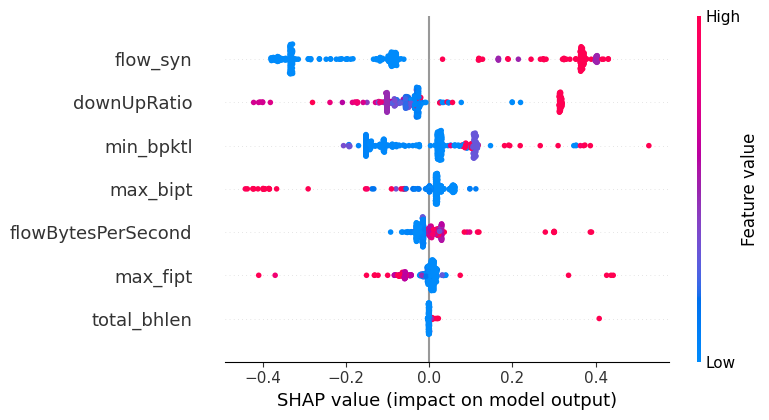

In [161]:
# Visualización resumen
shap.summary_plot(shap_valuesfi, X_test_fi)

In [162]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(y_testfi, y_predfrnfi))

El coeficiente de correlacion de Matthews es de  0.9616927932989439


In [163]:
y_predfrnfi_flat=y_predfrnfi.flatten()

df_resultados = pd.DataFrame({
    'Clase': FI_test,
    'Real': y_testfi,
    'Predicción': y_predfrnfi_flat
})

# Añadir una columna para indicar si la predicción fue correcta o no
df_resultados['Correcto'] = df_resultados['Real'] == df_resultados['Predicción']

# Ver los resultados de predicción junto con los casos específicos
aciertos = df_resultados.Clase[df_resultados['Correcto']==True]
errores = df_resultados.Clase[df_resultados['Correcto'] == False]



val='Dieciseisavo'

R_totales[val] = collections.Counter(df_resultados['Clase'])
R_aciertos[val] = collections.Counter(aciertos)
R_errores[val] = collections.Counter(errores)


print("Totales por clase: \n", R_totales[val])

print("Aciertos de Predicción:\n", R_aciertos[val])

print("Errores de Predicción:\n", R_errores[val] )

total_correctas = df_resultados['Correcto'].sum()
total_errores = len(df_resultados) - total_correctas
print(f"Total Correctas: {total_correctas}, Total Errores: {total_errores}")

Totales por clase: 
 0    149
4    215
3      8
5      5
1      3
2      1
Name: Dieciseisavo, dtype: int64
Aciertos de Predicción:
 0    147
4    214
5      5
1      3
3      4
2      1
Name: Dieciseisavo, dtype: int64
Errores de Predicción:
 3    4
0    2
4    1
Name: Dieciseisavo, dtype: int64
Total Correctas: 374, Total Errores: 7


# Calculo de desempeño con Validacion

## RFE

In [164]:
X_test_rfe.columns



Index(['total_fpackets', 'min_bpktl', 'std_bpktl', 'total_bipt', 'min_bipt',
       'max_bipt', 'mean_bipt', 'std_fipt', 'total_bhlen',
       'flowBytesPerSecond', 'flow_fin', 'flow_syn', 'flow_rst'],
      dtype='object')

In [165]:

# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_test_rfe.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dftrfe = df_val_f[columnas_utiles].copy()
print(dftrfe.shape)
dftrfe=dftrfe.dropna()
print(dftrfe.shape)
# Eliminar duplicados
print("Duplicados: ",dftrfe.duplicated().sum())

print("Duplicados A ",dftrfe.drop(['label'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dftrfe_cleaned = dftrfe.drop(['label'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dftrfe_cleaned = dftrfe[~dftrfe_cleaned]
dftrfe=dftrfe_cleaned.copy()

print("Duplicados D ",dftrfe.drop(['label'],axis=1,inplace=False).duplicated().sum())



dftrfe = dftrfe.drop_duplicates()

print("Valores nulos: ", dftrfe.isnull().values.sum())
dftrfe=dftrfe.dropna()

#collections.Counter(df.dftrfe.values)



# Balancear clases con subsampling (reduce clase mayoritaria)
df_class0_val = dftrfe[dftrfe['label'] == 0]
df_class1_val = dftrfe[dftrfe['label'] == 1]


df_class1_down_val = resample(df_class1_val,
                             replace=False,
                             n_samples=len(df_class0_val),
                             random_state=42)

# Dataset balanceado para validación
df_val_balanced = pd.concat([df_class0_val, df_class1_down_val])

# Mezclar datos
df_val_balanced = df_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_val_balanced['label'].value_counts())


dftrfe_test = df_val_balanced['label']
dftrfet = df_val_balanced.drop(columns=['label'])

#dftrfe_test=dftrfe['label']
#dftrfet=dftrfe.drop(columns=['label'])


numeric_colsdftr = dftrfet.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_colsdftr)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(dftrfet)
dftrfet_stand = preprocessor.transform(dftrfet)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.


labelsdftrfe=list(dftrfet.columns.values.tolist())
df_rfe_dft_stand=pd.DataFrame(dftrfet_stand,columns=labelsdftrfe)

print("Valores nulos: ", df_rfe_dft_stand.isnull().values.sum())
print("Duplicados: ",df_rfe_dft_stand.duplicated().sum())


(2018, 14)
(2018, 14)
Duplicados:  0
Duplicados A  0
Duplicados D  0
Valores nulos:  0
label
0    145
1    145
Name: count, dtype: int64
Valores nulos:  0
Duplicados:  0


### Comparacion de distribucion datos entrenamiento y validacion RFE

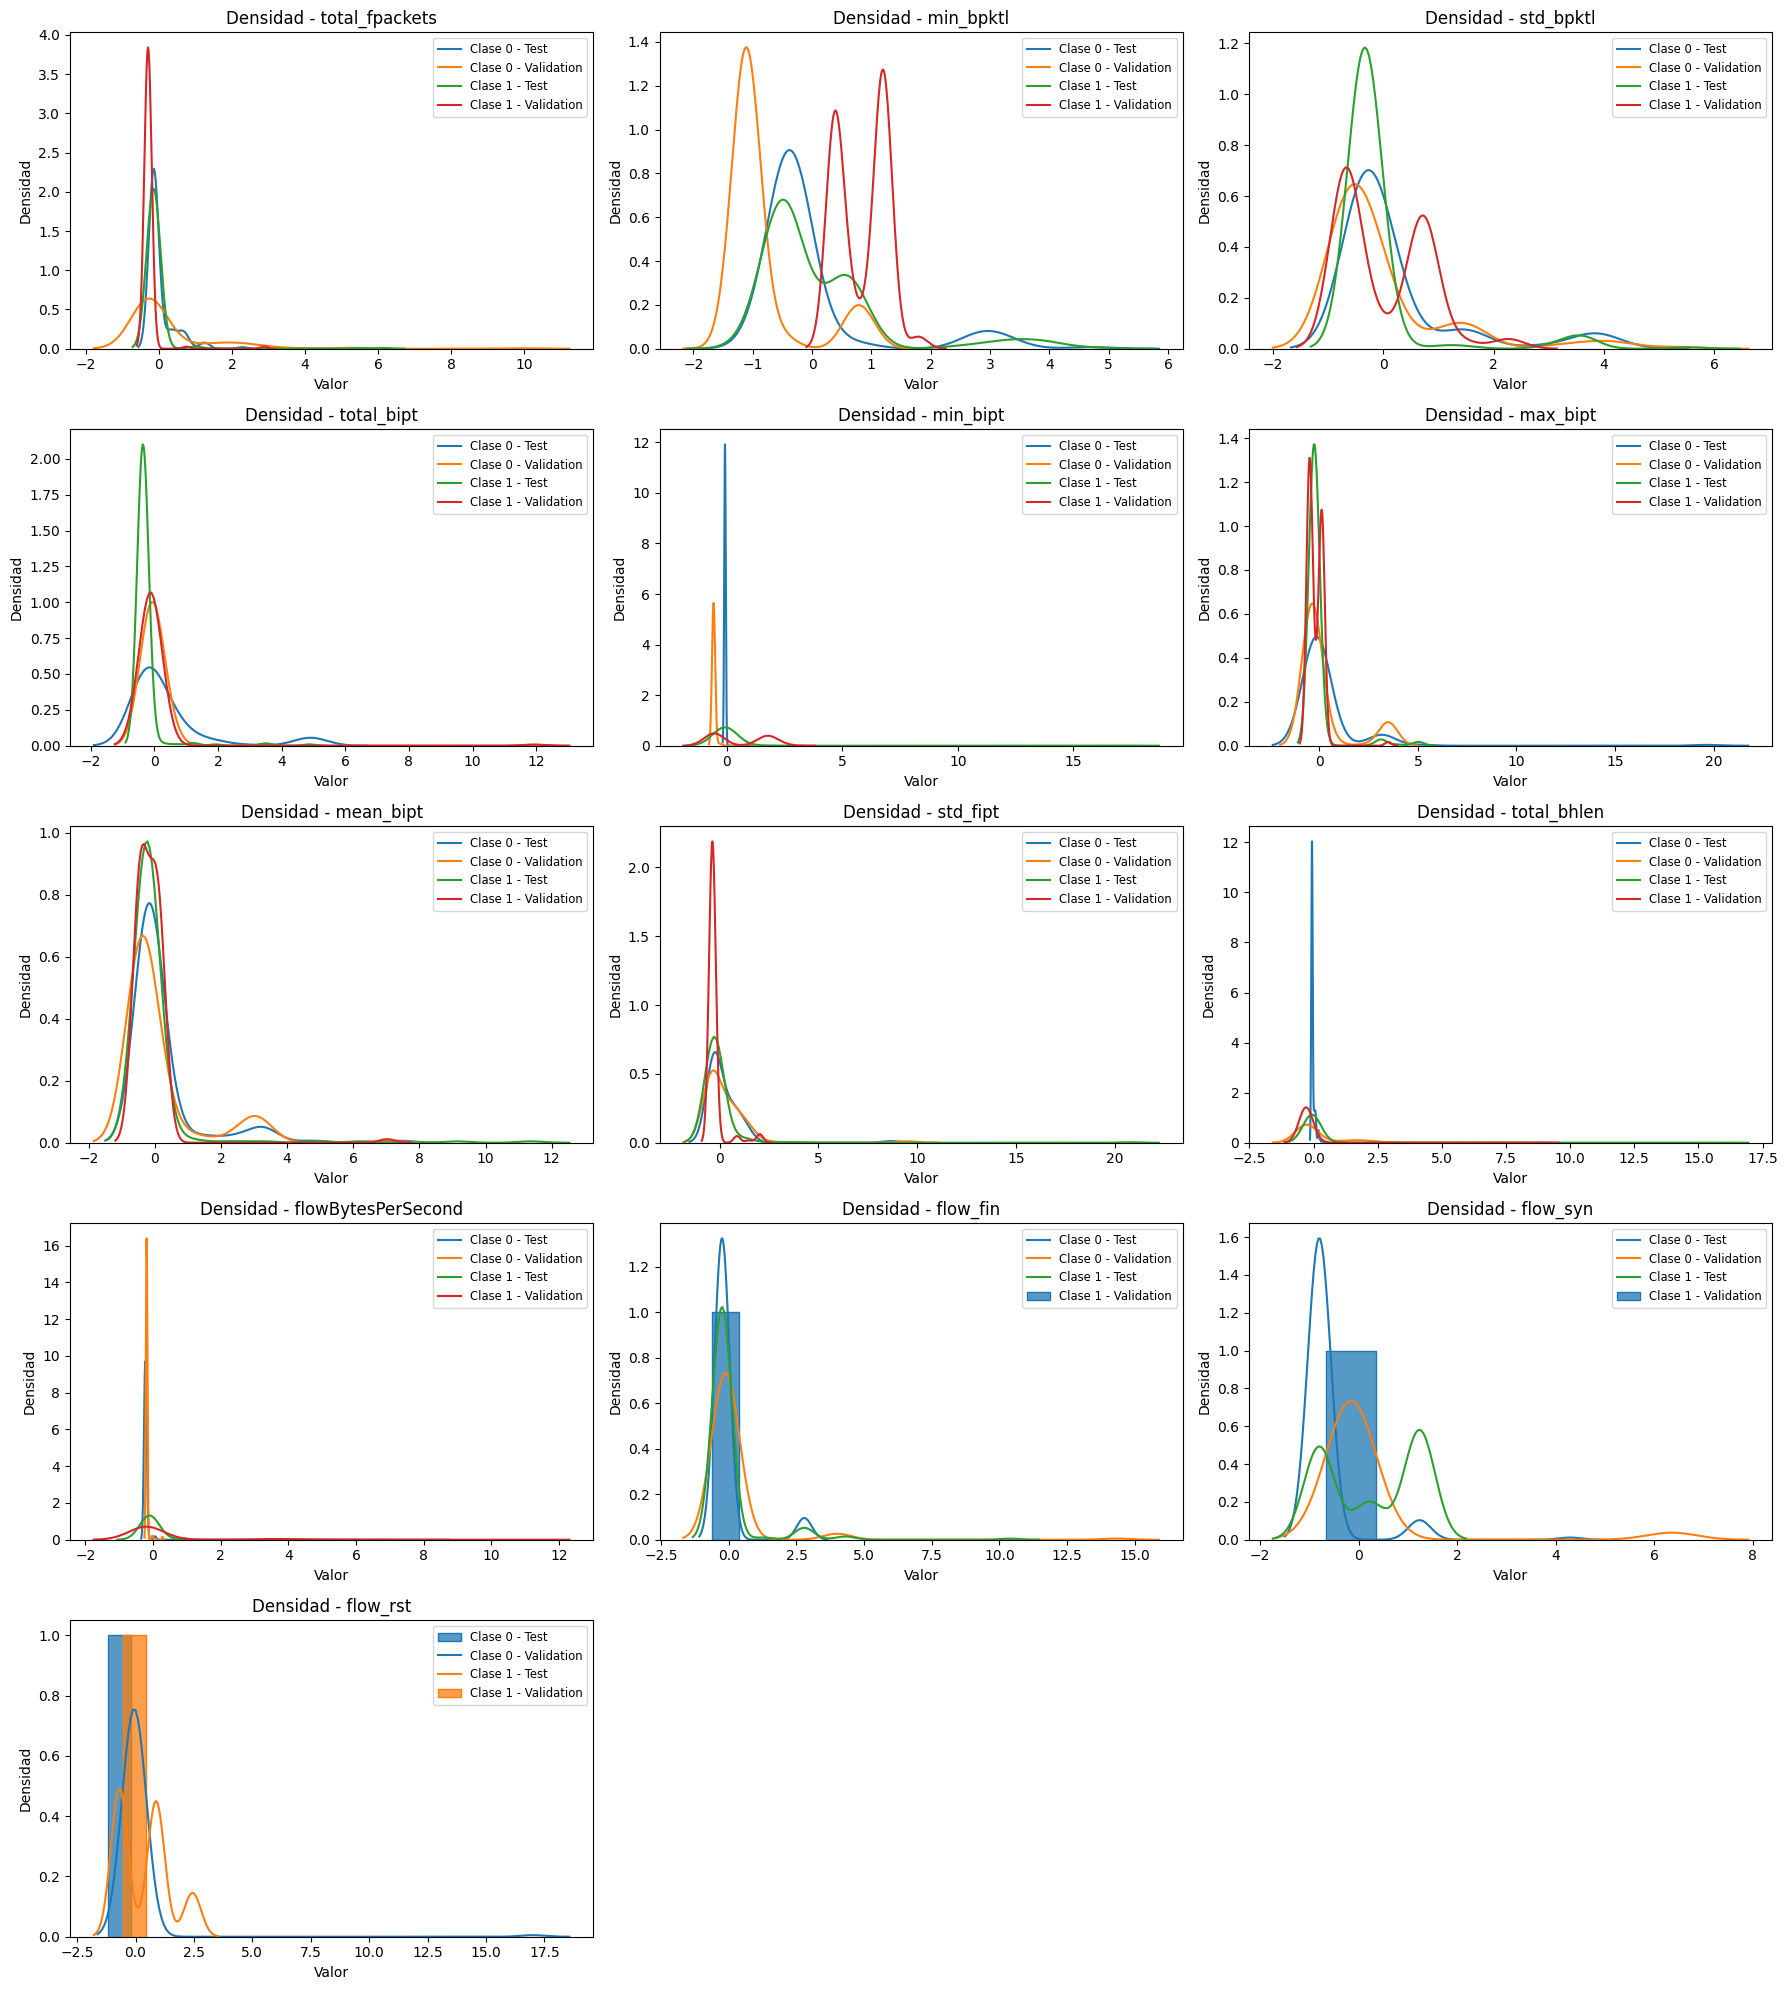

In [166]:
# Etiquetar conjunto de testing
X_test_labeled_rfe = X_test_rfe.copy()
X_test_labeled_rfe["Set"] = "Test"
X_test_labeled_rfe["Class"] = y_testrfe.values  # Asegura alineación por posición

# Etiquetar conjunto de validación
X_val_labeled_rfe = df_rfe_dft_stand.copy()
X_val_labeled_rfe["Set"] = "Validation"
X_val_labeled_rfe["Class"] = dftrfe_test.values  # Asegura alineación por posición

# Unir ambos conjuntos
X_all_rfe = pd.concat([X_test_labeled_rfe, X_val_labeled_rfe])

# Obtener lista de features a graficar
features_rfe_plot = X_test_rfe.columns
num_features_rfe = len(features_rfe_plot)

# Calcular layout dinámico para subplots
cols = 3
rows = math.ceil(num_features_rfe / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Graficar cada feature
for i, feature in enumerate(features_rfe_plot):
    ax = axs[i]
    data_ok = False
    for label_class in sorted(X_all_rfe["Class"].unique()):
        for label_set in ["Test", "Validation"]:
            subset = X_all_rfe[(X_all_rfe["Class"] == label_class) & (X_all_rfe["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Ocultar ejes sobrantes
for j in range(num_features_rfe, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Desepeño de los modelos

#### 4.- RL con Optuna y RFE

              precision    recall  f1-score   support

     class 0       0.99      0.89      0.94       145
     class 1       0.90      0.99      0.94       145

    accuracy                           0.94       290
   macro avg       0.95      0.94      0.94       290
weighted avg       0.95      0.94      0.94       290



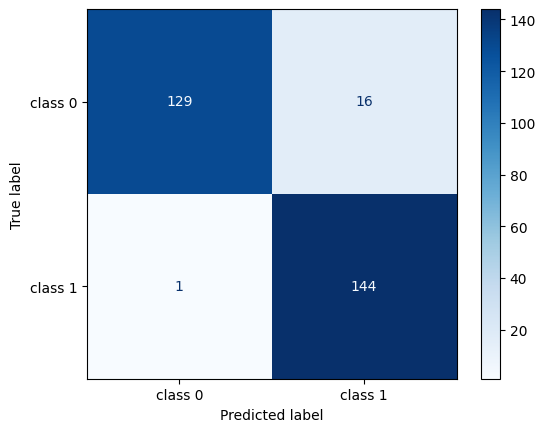

In [167]:
#Modelo 4 
#Regresion Logistica con Optuna y RFE

y_predbrlorfedt = best_modelrlo.predict(df_rfe_dft_stand)



#performance results
print(classification_report(dftrfe_test, y_predbrlorfedt, target_names=target_names))

cm = confusion_matrix(dftrfe_test, y_predbrlorfedt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 8.- XGBoost con GridSearch y RFE

Best Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.34), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(8), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(359), n_jobs=None,
              num_parallel_tree=None, ...)
Score: 0.9789780127173829
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.12      0.15       145
           1       0.

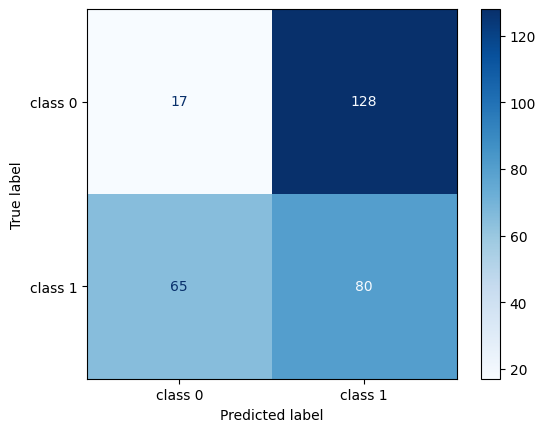

In [168]:
#Modelo 8. 
# XGBoost con GRid Search y RFE 

# Predecir y evaluar el modelo
y_predxgbrfedft = grid_xgbrfe.predict(df_rfe_dft_stand)
print("Best Parameters:", grid_xgbrfe.best_estimator_)
print("Score:", grid_xgbrfe.best_score_)
print("Classification Report:\n", classification_report(dftrfe_test, y_predxgbrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predxgbrfedft, display_labels=target_names, cmap=plt.cm.Blues)

#### 11.- SVC con RandomizedSearchCV y RFE

Accuracy: 0.7413793103448276
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.77       145
           1       0.84      0.60      0.70       145

    accuracy                           0.74       290
   macro avg       0.76      0.74      0.74       290
weighted avg       0.76      0.74      0.74       290



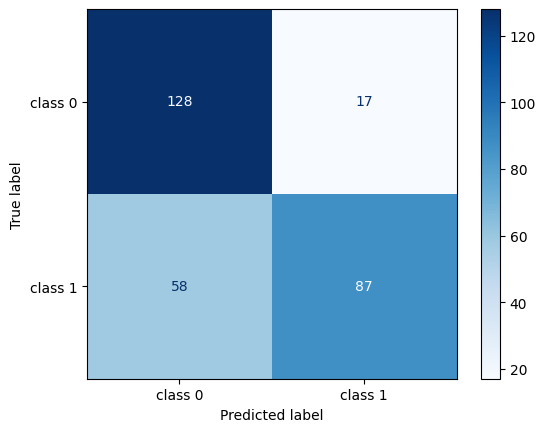

In [169]:
#Modelo 11 
# SVC con RandomSearc y RFE 

y_predsvmrfedft = best_modelsvmrfe.predict(df_rfe_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dftrfe_test, y_predsvmrfedft))
print("Classification Report:\n", classification_report(dftrfe_test, y_predsvmrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predsvmrfedft, display_labels=target_names, cmap=plt.cm.Blues)

#### 13.- NV con RFE

Accuracy: 0.5758620689655173
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.16      0.27       145
           1       0.54      0.99      0.70       145

    accuracy                           0.58       290
   macro avg       0.75      0.58      0.49       290
weighted avg       0.75      0.58      0.49       290

El coeficiente de correlacion de Matthews es de  0.2753443958769674


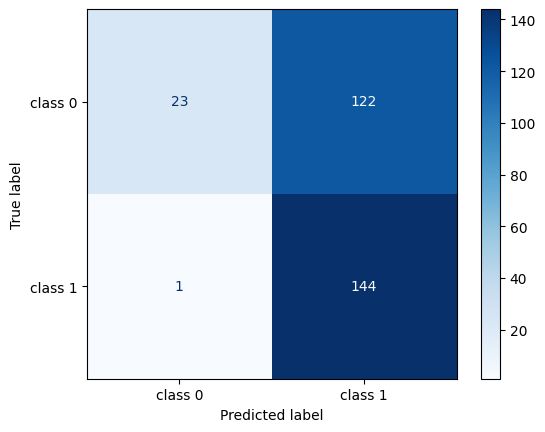

In [170]:
#Modelo 13 
# Naive Bayes y RFE 

y_prednvrfedft=clfnvrfe.predict(df_rfe_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dftrfe_test, y_prednvrfedft))
print("Classification Report:\n", classification_report(dftrfe_test, y_prednvrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_prednvrfedft, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dftrfe_test, y_prednvrfedft))

#### 15.- ANN con Optuna y RFE

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.42      0.45       145
           1       0.49      0.55      0.52       145

    accuracy                           0.49       290
   macro avg       0.49      0.49      0.48       290
weighted avg       0.49      0.49      0.48       290



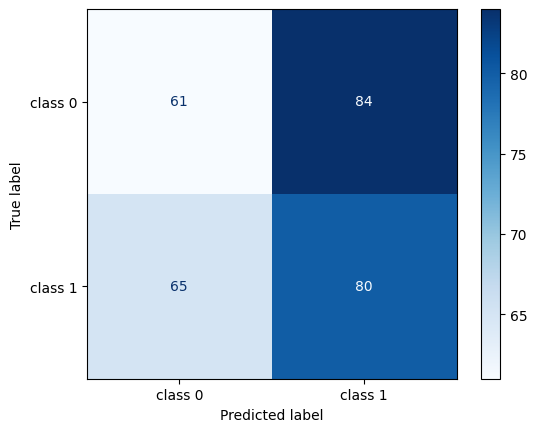

In [171]:
#Modelo 15 
# ANN con Optuna y RFE 

y_pred_probarfedft = best_modelfrnrfe.predict(df_rfe_dft_stand)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrnrfedft = (y_pred_probarfedft > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(dftrfe_test, y_predfrnrfedft))
ConfusionMatrixDisplay.from_predictions(dftrfe_test, y_predfrnrfedft, display_labels=target_names, cmap=plt.cm.Blues)

In [172]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dftrfe_test, y_predfrnrfedft))

El coeficiente de correlacion de Matthews es de  -0.02782612903765607


## FI


In [173]:
X_test_fi.columns

Index(['min_bpktl', 'max_fipt', 'max_bipt', 'total_bhlen',
       'flowBytesPerSecond', 'flow_syn', 'downUpRatio'],
      dtype='object')

In [174]:
# Convertir las columnas a lista y añadir 'label'
columnas_utiles = list(X_test_fi.columns) + ['label']

# Crear el nuevo DataFrame con esas columnas
dftee = df_val_f[columnas_utiles].copy()


dftee.shape


# Eliminar duplicados
print("Duplicados A ",dftee.drop(['label'],axis=1,inplace=False).duplicated().sum())

# Eliminar duplicados en todas las columnas excepto 'label' y 'Ataque'
dft_cleaned = dftee.drop(['label'], axis=1).duplicated(keep='first')

# Filtrar el DataFrame original solo por las filas no duplicadas
dft_cleaned = dftee[~dft_cleaned]
dft=dft_cleaned.copy()

print("Duplicados D ",dft.drop(['label'],axis=1,inplace=False).duplicated().sum())




print("Valores nulos: ", dft.isnull().values.sum())
dft.dropna(inplace=True)

#collections.Counter(df.dft.values)

# Balancear clases con subsampling (reduce clase mayoritaria)
dffi_class0_val = dft[dft['label'] == 0]
dffi_class1_val = dft[dft['label'] == 1]


dffi_class1_down_val = resample(dffi_class1_val,
                             replace=False,
                             n_samples=len(dffi_class0_val),
                             random_state=42)

# Dataset balanceado para validación
dffi_val_balanced = pd.concat([dffi_class0_val, dffi_class1_down_val])

# Mezclar datos
dffi_val_balanced = dffi_val_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(dffi_val_balanced['label'].value_counts())


dft_test = dffi_val_balanced['label']
dftt = dffi_val_balanced.drop(columns=['label'])

# dft_test=dft['label']
# dftt=dft.drop(columns=['label'])


numeric_colsdft = dftt.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_colsdft)], remainder='passthrough')

# fit on the trainning dataset
preprocessor.fit_transform(dftt)
dft_stand = preprocessor.transform(dftt)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.


labelsdft=list(dftt.columns.values.tolist())
df_dft_stand=pd.DataFrame(dft_stand,columns=labelsdft)

print("Valores nulos: ", dftt.isnull().values.sum())
print("Duplicados: ",dftt.duplicated().sum())



Duplicados A  0
Duplicados D  0
Valores nulos:  0
label
0    145
1    145
Name: count, dtype: int64
Valores nulos:  0
Duplicados:  0


In [175]:
dft.shape

(2018, 8)

### Comparacion de distribucion datos entrenamiento y validacion FI

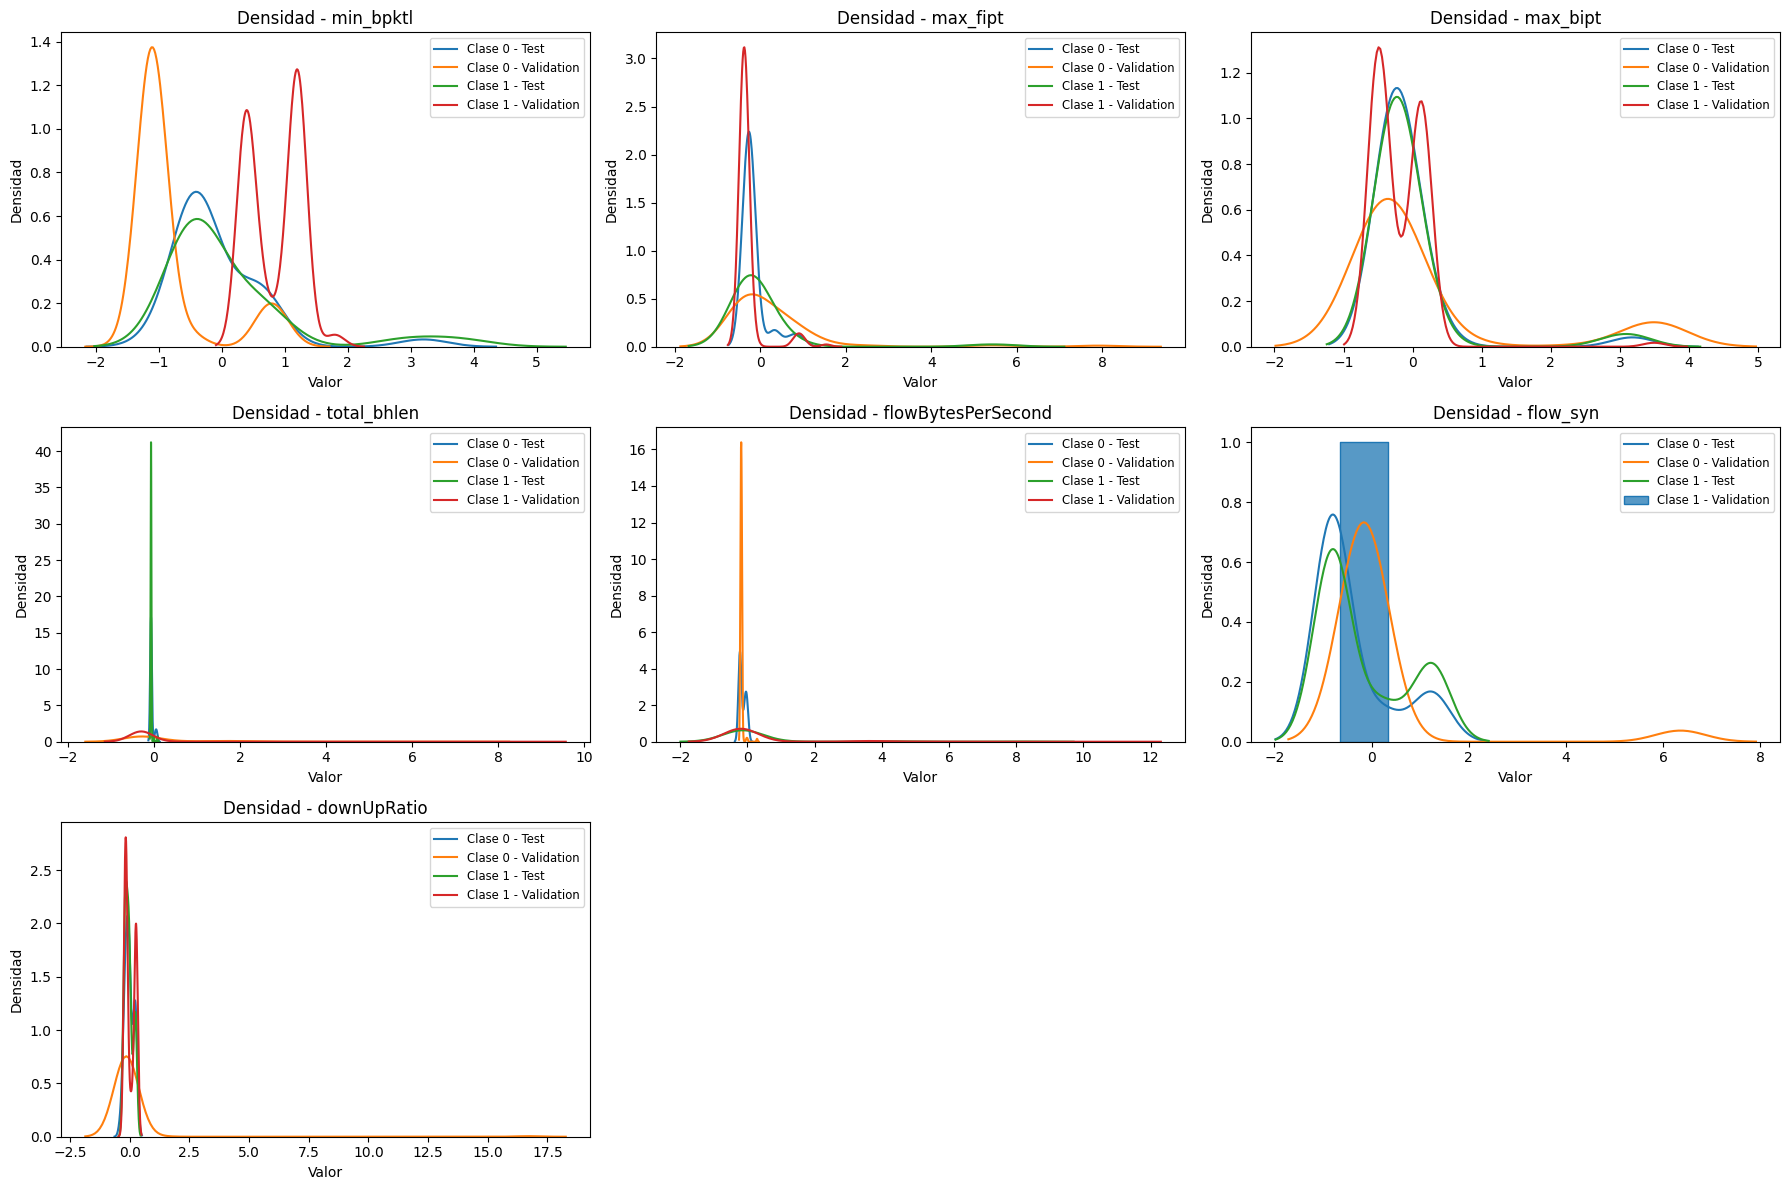

In [176]:
# Crear copia con etiquetas
X_test_labeled_fi = X_test_fi.copy()
X_test_labeled_fi["Set"] = "Test"
X_test_labeled_fi["Class"] = y_testrfe  # Asegúrate de que los índices coincidan

X_val_labeled_fi = df_dft_stand.copy()
X_val_labeled_fi["Set"] = "Validation"
X_val_labeled_fi["Class"] = dftrfe_test  # Asegúrate de que los índices coincidan

# Concatenar
X_all_fi = pd.concat([X_test_labeled_fi, X_val_labeled_fi])
features_to_plot_fi = X_test_fi.columns
num_features_fi = len(features_to_plot_fi)

# Layout dinámico
cols = 3
rows = math.ceil(num_features_fi / cols)
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Plot por feature, clase y conjunto
for i, feature in enumerate(features_to_plot_fi):
    ax = axs[i]
    data_ok = False
    for label_class in [0, 1]:
        for label_set in ["Test", "Validation"]:
            subset = X_all_fi[(X_all_fi["Class"] == label_class) & (X_all_fi["Set"] == label_set)][feature]
            if subset.nunique() > 1 and subset.shape[0] > 1:
                sns.kdeplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax)
                data_ok = True
            elif subset.shape[0] > 0:
                sns.histplot(subset, label=f"Clase {label_class} - {label_set}", ax=ax, kde=False, stat='density', element='step')
                data_ok = True
    if data_ok:
        ax.set_title(f"Densidad - {feature}")
        ax.set_xlabel("Valor")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
    else:
        ax.set_visible(False)

# Eliminar gráficos vacíos
for j in range(num_features_fi, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Desempeño de modelos FI

#### 7.- DT con GridSearchCV y FI

In [177]:
#Modelo 7 
# DT optimizado y FI 

y_preddttfi = mdtop.predict(df_dft_stand)
y_probdttfi = mdtop.predict_proba(df_dft_stand)
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_preddttfi, dft_test))

Accuracy of Decision Tree-Test:  0.5


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.50      1.00      0.67       145

    accuracy                           0.50       290
   macro avg       0.25      0.50      0.33       290
weighted avg       0.25      0.50      0.33       290



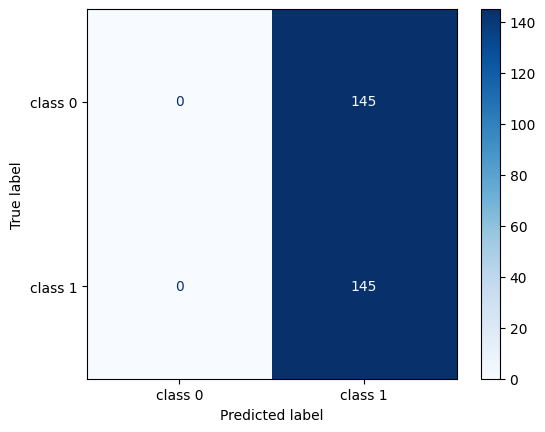

In [178]:
#Classification for test before hyperparameter tuning
print(classification_report(dft_test,y_preddttfi))
ConfusionMatrixDisplay.from_predictions(dft_test, y_preddttfi, display_labels=target_names, cmap=plt.cm.Blues)

#### 9.- XGBoost con GridSearch y FI

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.30      0.32       145
           1       0.40      0.47      0.43       145

    accuracy                           0.38       290
   macro avg       0.38      0.38      0.38       290
weighted avg       0.38      0.38      0.38       290



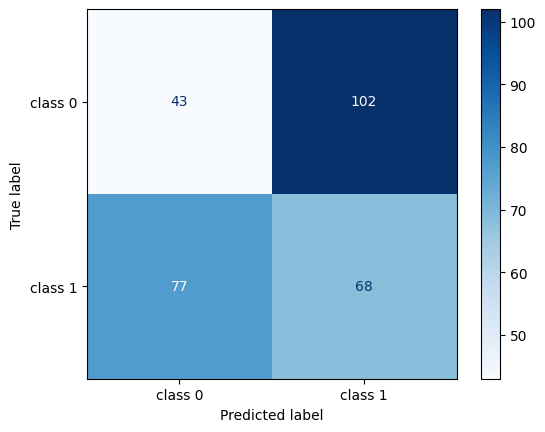

In [179]:
#Modelo 9 
# XGBoost con GridSearch y FI 

# Predecir y evaluar el modelo
y_predxgbfit = grid_xgbfi.predict(df_dft_stand)
print("Classification Report:\n", classification_report(dft_test, y_predxgbfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predxgbfit, display_labels=target_names, cmap=plt.cm.Blues)

In [180]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_predxgbfit))

El coeficiente de correlacion de Matthews es de  -0.23804761428476168


#### 10.- Random Forest

Mejor modelo accuracy score: 0.5414
Mejores parámetros:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': np.int64(340)}
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.15      0.25       145
           1       0.52      0.93      0.67       145

    accuracy                           0.54       290
   macro avg       0.61      0.54      0.46       290
weighted avg       0.61      0.54      0.46       290



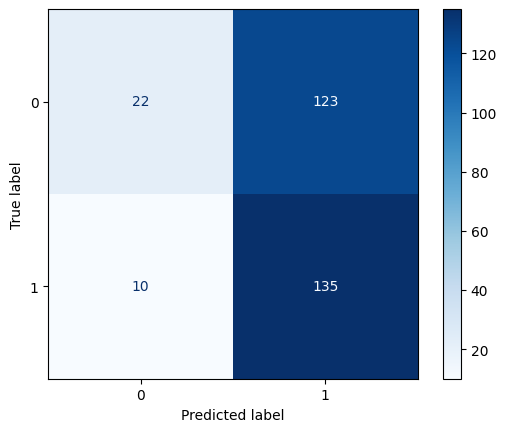

In [181]:
#Modelo 10 
# Random Forest con RandomSearch y FI 

y_predrft = best_clfrf.predict(df_dft_stand)

# Evaluar el mejor modelo
print('Mejor modelo accuracy score: {0:0.4f}'. format(accuracy_score(dft_test, y_predrft)))
print("Mejores parámetros: ", grid_searchrf.best_params_)

print("Classification Report:\n", classification_report(dft_test, y_predrft))

# Print the Confusion Matrix and slice it into four pieces

ConfusionMatrixDisplay.from_predictions(dft_test, y_predrft, cmap=plt.cm.Blues);

In [182]:
print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_predrft))

El coeficiente de correlacion de Matthews es de  0.13206763594884358


#### 12.- SVC con RandomizedSearchCV y FI

Accuracy: 0.7586206896551724
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       145
           1       0.88      0.60      0.71       145

    accuracy                           0.76       290
   macro avg       0.79      0.76      0.75       290
weighted avg       0.79      0.76      0.75       290



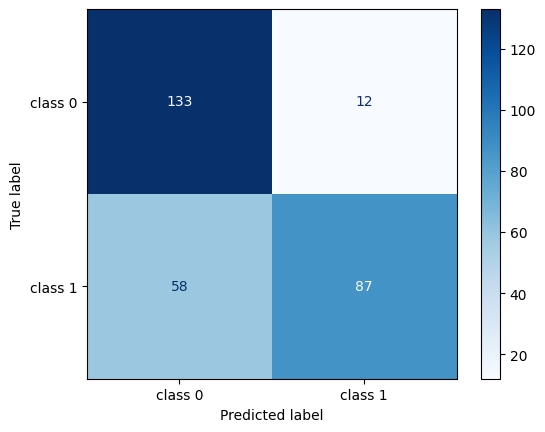

In [183]:
#Modelo 12
# SVC RandomSearch y FI 

y_predsvmtfit = best_modelsvmdt.predict(df_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dft_test, y_predsvmtfit))
print("Classification Report:\n", classification_report(dft_test, y_predsvmtfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predsvmtfit, display_labels=target_names, cmap=plt.cm.Blues)

#### 14.- NV con FI

Accuracy: 0.5620689655172414
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22       145
           1       0.53      1.00      0.70       145

    accuracy                           0.56       290
   macro avg       0.77      0.56      0.46       290
weighted avg       0.77      0.56      0.46       290

El coeficiente de correlacion de Matthews es de  0.25724787771376323


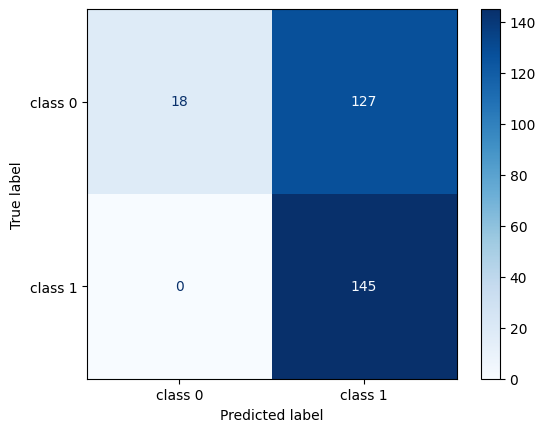

In [184]:
#Modelo 14 
# Naive Bayes y FI 

y_prednvfit=clfnv.predict(df_dft_stand)

# Evaluar el modelo
print("Accuracy:", accuracy_score(dft_test, y_prednvfit))
print("Classification Report:\n", classification_report(dft_test, y_prednvfit))
ConfusionMatrixDisplay.from_predictions(dft_test, y_prednvfit, display_labels=target_names, cmap=plt.cm.Blues)

print("El coeficiente de correlacion de Matthews es de ",matthews_corrcoef(dft_test, y_prednvfit))

#### 16.- ANN con Optuna y FI

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.15      0.15       145
           1       0.10      0.09      0.09       145

    accuracy                           0.12       290
   macro avg       0.12      0.12      0.12       290
weighted avg       0.12      0.12      0.12       290



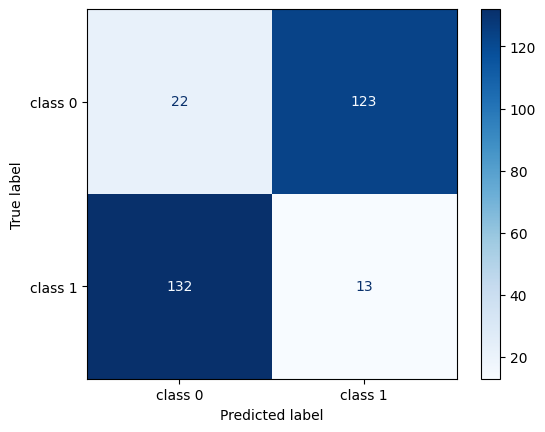

In [185]:
#Modelo 16
# ANN Optuna y FI
#  
y_pred_probadftt = best_modelrnfi.predict(df_dft_stand)

# Convierte las probabilidades en clases binarias (0 o 1)
y_predfrndftt = (y_pred_probadftt > 0.5).astype(int)

# Calcula la matriz de confusión
print("Classification Report:\n", classification_report(dft_test, y_predfrndftt))
ConfusionMatrixDisplay.from_predictions(dft_test, y_predfrndftt, display_labels=target_names, cmap=plt.cm.Blues)

# Validaciones

## Conjunto de Testing

Modelo  Accuracy  Recall (Macro)  F1 Score (Macro)  \
15            16. ANN+FI  0.981627        0.982513          0.980780   
7             8. XGB+RFE  0.973753        0.972446          0.972446   
9              10. RF+FI  0.971129        0.971491          0.969797   
5               6. DT+FI  0.971129        0.971491          0.969797   
4         5. DT-Baseline  0.971129        0.970290          0.969726   
8              9. XGB+FI  0.971129        0.970290          0.969726   
14           15. ANN+RFE  0.968504        0.966935          0.966935   
6           7. DT+FI+Opt  0.952756        0.951603          0.950519   
2           3. RL-Optuna  0.950131        0.944645          0.947321   
3       4. RL-Optuna+RFE  0.944882        0.937934          0.941625   
1   2. RL-GridSearch+RFE  0.942257        0.941781          0.939663   
10           11. SVC+RFE  0.942257        0.940581          0.939524   
0     1. RL-RandomSearch  0.937008        0.931468          0.933543   
11            12. SVC+FI  0.850394        0.861548          0.847554   
12            13. NB+RFE  0.753281        0.781807          0.752898   
13             14. NB+FI  0.708661        0.736765          0.708372   

     ROC AUC       MCC  
15  0.982513  0.961693  
7   0.972446  0.944891  
9   0.971491  0.939725  
5   0.971491  0.939725  
4   0.970290  0.939467  
8   0.970290  0.939467  
14  0.966935  0.933869  
6   0.951603  0.901096  
2   0.944645  0.895005  
3   0.937934  0.883960  
1   0.941781  0.879552  
10  0.940581  0.879104  
0   0.931468  0.867314  
11  0.861548  0.706804  
12  0.781807  0.555478  
13  0.736765  0.467801

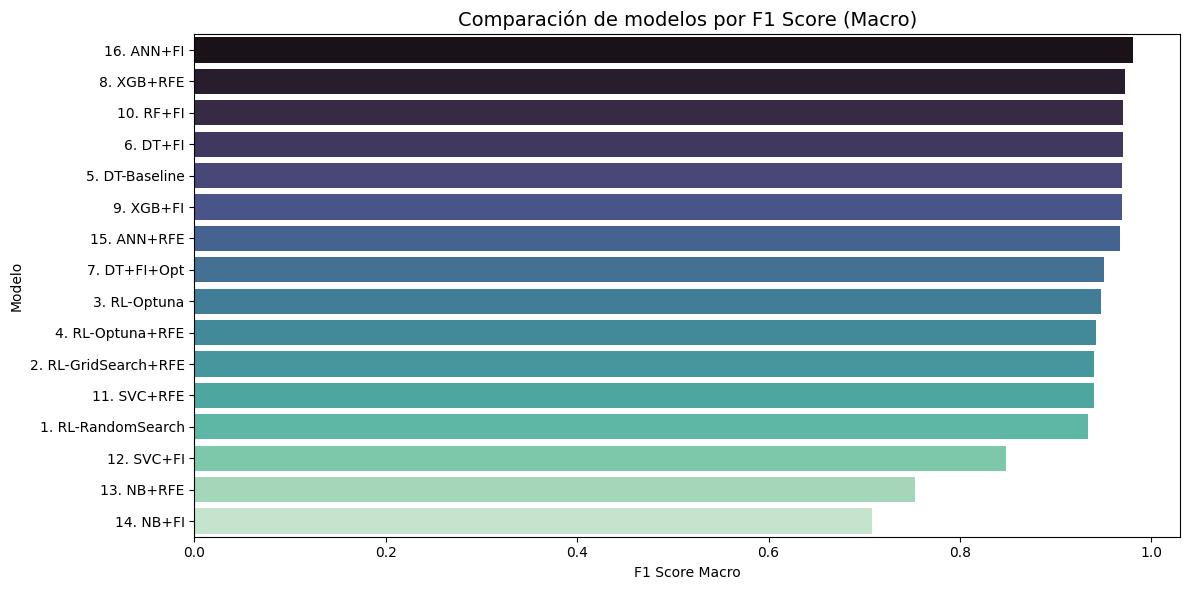

In [186]:
# Nombres de modelos y sus predicciones 
modelos = [
    ("1. RL-RandomSearch", y_test, y_predrlrs),
    ("2. RL-GridSearch+RFE", y_testrfe, y_predrlgs),
    ("3. RL-Optuna", y_test, y_predbrlo),
    ("4. RL-Optuna+RFE", y_testrfe, y_predbrlorfe),
    ("5. DT-Baseline", y_test, y_preddt),
    ("6. DT+FI", y_testfi, y_preddtfi),
    ("7. DT+FI+Opt", y_testfi, y_preddtop),
    ("8. XGB+RFE", y_testrfe, y_predxgbrfe),
    ("9. XGB+FI", y_testfi, y_predxgbfi),
    ("10. RF+FI", y_testfi, y_predrf),
    ("11. SVC+RFE", y_testrfe, y_predsvmrfe),
    ("12. SVC+FI", y_testfi, y_predsvmfi),
    ("13. NB+RFE", y_testrfe, y_prednvrfe),
    ("14. NB+FI", y_testfi, y_prednvfi),
    ("15. ANN+RFE", y_testrfe, y_predfrnrfe),
    ("16. ANN+FI", y_testfi, y_predfrnfi)
]

# Calcular métricas
resultados = []
for nombre, y_true, y_pred in modelos:
    try:
        resultados.append({
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
            "F1 Score (Macro)": f1_score(y_true, y_pred, average='macro'),
            "ROC AUC": roc_auc_score(y_true, y_pred),  
            "MCC": matthews_corrcoef(y_true, y_pred)
        })
    except Exception as e:
        print(f"Error en modelo {nombre}: {e}")
        continue

# Crear DataFrame
df_resultados = pd.DataFrame(resultados).sort_values(by="F1 Score (Macro)", ascending=False)

# Mostrar tabla
display(df_resultados)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="F1 Score (Macro)", y="Modelo", data=df_resultados, palette="mako")
plt.title("Comparación de modelos por F1 Score (Macro)", fontsize=14)
plt.xlabel("F1 Score Macro")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()


## Conjunto de validacion

Modelo  Accuracy  Recall (Macro)  F1 Score (Macro)   ROC AUC  \
0   4. RL-Optuna+RFE  0.941379        0.941379          0.941222  0.941379   
6         12. SVC+FI  0.758621        0.758621          0.752391  0.758621   
5        11. SVC+RFE  0.741379        0.741379          0.736105  0.741379   
7         13. NB+RFE  0.575862        0.575862          0.486460  0.575862   
9        15. ANN+RFE  0.486207        0.486207          0.483992  0.486207   
4          10. RF+FI  0.541379        0.541379          0.459281  0.541379   
8          14. NB+FI  0.562069        0.562069          0.458151  0.562069   
3          9. XGB+FI  0.382759        0.382759          0.378137  0.382759   
1       7. DT+FI+Opt  0.500000        0.500000          0.333333  0.500000   
2         8. XGB+RFE  0.334483        0.334483          0.301519  0.334483   
10        16. ANN+FI  0.120690        0.120690          0.119842  0.120690   

         MCC  
0   0.887520  
6   0.545415  
5   0.503298  
7   0.275344  
9  -0.027826  
4   0.132068  
8   0.257248  
3  -0.238048  
1   0.000000  
2  -0.367538  
10 -0.760086

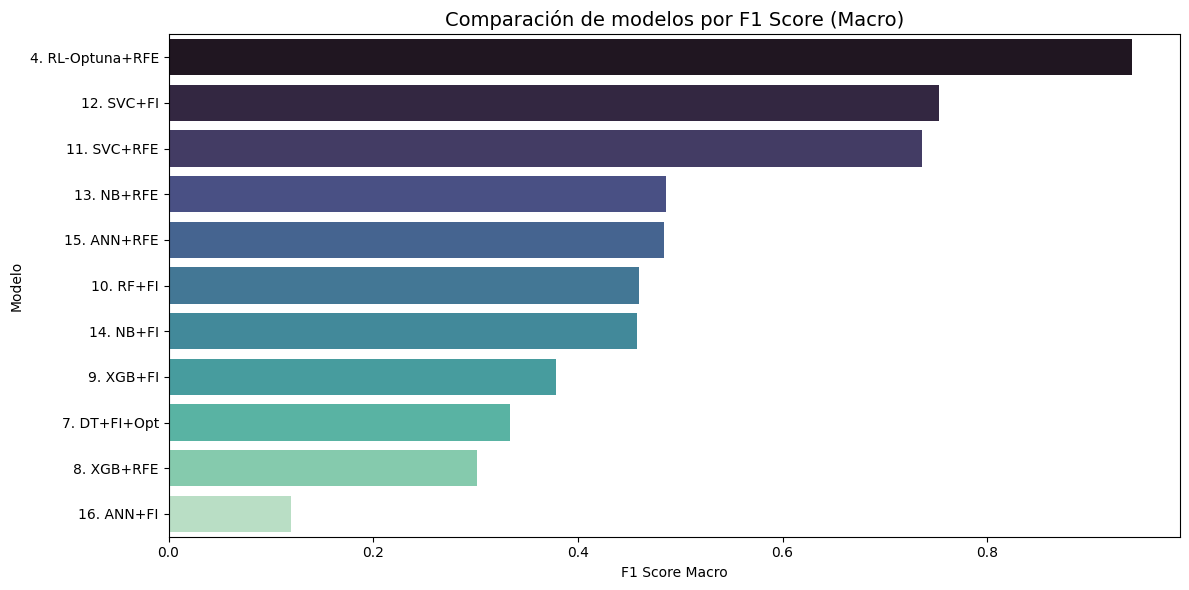

In [187]:
# Nombres de modelos y sus predicciones 
modelosv = [
    
    ("4. RL-Optuna+RFE", dftrfe_test, y_predbrlorfedt),
    ("7. DT+FI+Opt", dft_test, y_preddttfi),
    ("8. XGB+RFE", dftrfe_test, y_predxgbrfedft),
    ("9. XGB+FI", dft_test, y_predxgbfit),
    ("10. RF+FI", dft_test, y_predrft),
    ("11. SVC+RFE", dftrfe_test, y_predsvmrfedft),
    ("12. SVC+FI", dft_test, y_predsvmtfit),
    ("13. NB+RFE", dftrfe_test, y_prednvrfedft),
    ("14. NB+FI", dft_test, y_prednvfit),
    ("15. ANN+RFE", dftrfe_test, y_predfrnrfedft),
    ("16. ANN+FI", dft_test, y_predfrndftt)
]

# Calcular métricas
resultadosv = []
for nombrev, y_truev, y_predv in modelosv:
    try:
        resultadosv.append({
            "Modelo": nombrev,
            "Accuracy": accuracy_score(y_truev, y_predv),
            "Recall (Macro)": recall_score(y_truev, y_predv, average='macro'),
            "F1 Score (Macro)": f1_score(y_truev, y_predv, average='macro'),
            "ROC AUC": roc_auc_score(y_truev, y_predv),  
            "MCC": matthews_corrcoef(y_truev, y_predv)
        })
    except Exception as e:
        print(f"Error en modelo {nombrev}: {e}")
        continue

# Crear DataFrame
df_resultadosv = pd.DataFrame(resultadosv).sort_values(by="F1 Score (Macro)", ascending=False)

# Mostrar tabla
display(df_resultadosv)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="F1 Score (Macro)", y="Modelo", data=df_resultadosv, palette="mako")
plt.title("Comparación de modelos por F1 Score (Macro)", fontsize=14)
plt.xlabel("F1 Score Macro")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()
